In [23]:
import pandas as pd
import numpy as np
import rasterio
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, Dense, concatenate, Reshape, UpSampling2D
from tensorflow.keras.models import Model
import tqdm
from tensorflow.keras.layers import BatchNormalization, Dropout
import matplotlib.pyplot as plt


In [2]:
def build_2d_cnn(input_shape=(256, 256, 2)):
    input_2d = Input(shape=input_shape, name='Raster_Input')
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_2d)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)

    return input_2d, x

def build_1d_cnn(input_shape=(189, 1)): 
    input_1d = Input(shape=input_shape, name='Rainfall_Input')
    y = Conv1D(16, 3, activation='relu', padding='same')(input_1d)
    y = BatchNormalization()(y)
    y = MaxPooling1D(2)(y)

    y = Conv1D(32, 3, activation='relu', padding='same')(y)
    y = Dropout(0.3)(y)
    y = Flatten()(y)

    return input_1d, y

def build_combined_model():
    input_2d, raster_features = build_2d_cnn()
    input_1d, rainfall_features = build_1d_cnn(input_shape=(189, 1))

    combined = concatenate([raster_features, rainfall_features])
    z = Dense(1024, activation='relu')(combined)
    z = Dropout(0.4)(z)
    z = Dense(256*256, activation='sigmoid')(z)
    output_map = Reshape((256, 256, 1), name='Flood_Map_Output')(z)

    model = Model(inputs=[input_2d, input_1d], outputs=output_map)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_combined_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Raster_Input        │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        304 │ Raster_Input[0][… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Rainfall_Input      │ (None, 189, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 189, 16)   │         64 │ Rainfall_Input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 189, 16)   │         64 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 94, 16)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 94, 32)    │      1,568 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 94, 32)    │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 262144)    │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 3008)      │          0 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 265152)    │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 338,716,400 (1.26 GB)

 Trainable params: 338,716,272 (1.26 GB)

 Non-trainable params: 128 (512.00 B)

In [27]:
# Synthetic Rainfall Data
rainfall_df = pd.read_excel(r'C:\Users\sistudent\Desktop\SI_NN\Input_Data\Synthetic_Rainfall\synthetic_rainfall_variable_duration.xlsx')
rainfall_data = rainfall_df.iloc[:, 1:]
rainfall_vectors = []

for col in rainfall_data.columns:
    vector = rainfall_data[col].values.reshape(-1, 1)
    rainfall_vectors.append(vector)

rainfall_vectors = np.array(rainfall_vectors)  

print("Rainfall vectors shape:", rainfall_vectors.shape)

rainfall_data.head()

Rainfall vectors shape: (204, 189, 1)


0         1         2         3         4         5         6    \
0  0.143422  0.000000  0.000000  0.000000  0.033272  0.084364  0.102032   
1  0.111742  0.000000  0.037739  0.033673  0.278264  0.000000  0.223326   
2  0.009092  0.062920  0.095485  0.039999  0.000000  0.065580  0.088490   
3  0.175437  0.156583  0.000000  0.059604  0.000000  0.000000  0.079713   
4  0.148566  0.096762  0.021109  0.059887  0.043382  0.000000  0.000000   

        7         8         9    ...       194       195       196       197  \
0  0.000000  0.000000  0.038488  ...  0.084112  0.000000  0.000000  0.067779   
1  0.022700  0.237635  0.064271  ...  0.018072  0.138171  0.082169  0.064973   
2  0.072366  0.259779  0.071798  ...  0.048885  0.150937  0.000000  0.002820   
3  0.000000  0.131643  0.036200  ...  0.018573  0.000000  0.000000  0.000000   
4  0.082910  0.207636  0.002990  ...  0.010618  0.008662  0.000000  0.043522   

        198       199   200   201   202   203  
0  0.000000  0.058876  0.19  0.01  0.01  0.01  
1  0.000000  0.078432  0.39  0.01  0.00  0.00  
2  0.007488  0.011535  0.23  0.00  0.01  0.00  
3  0.012509  0.005169  0.33  0.01  0.01  0.01  
4  0.000000  0.006104  0.05  0.01  0.02  0.01  

[5 rows x 204 columns]

In [4]:
def extract_patches(arr, patch_size=256):
    H, W = arr.shape
    patches = []
    indices = []

    for i in range(0, H - patch_size + 1, patch_size):
        for j in range(0, W - patch_size + 1, patch_size):
            patch = arr[i:i+patch_size, j:j+patch_size]
            patches.append(patch)
            indices.append((i, j))
    return np.array(patches), indices

In [5]:
# DEM and Building rasters
with rasterio.open(r'C:\Users\sistudent\Desktop\SI_NN\Input_Data\HBKDEM_FULL\HBKDEM_Full.tif') as src:
    dem = src.read(1)
dem = dem[1:-1, 2:-2]

with rasterio.open(r'C:\Users\sistudent\Desktop\SI_NN\Input_Data\HBK_Full_Extent\HBK_Full_Extent.tif') as src:
    bldg = src.read(1)

# Cut into patches
dem_patches, patch_indices = extract_patches(dem)
bldg_patches, _ = extract_patches(bldg)

# Stack
base_raster_patches = np.stack([dem_patches, bldg_patches], axis=-1)

In [6]:
X_raster_all = []
X_rainfall_all = []
Y_flood_all = []

for rainfall_id in range(151):
    rainfall_vector = rainfall_vectors[rainfall_id] 

    flt_path = rf'C:\Users\sistudent\Desktop\PCSWMM5\outputs\{rainfall_id}\{rainfall_id}DepthFLT\{rainfall_id}Depth.FLT'
    with rasterio.open(flt_path) as src:
        flood = (src.read(1) > 1.0).astype(np.float32)

    for patch_id, (i, j) in enumerate(patch_indices):
        raster_patch = base_raster_patches[patch_id]  
        flood_patch = flood[i:i+256, j:j+256][..., np.newaxis]  

        X_raster_all.append(raster_patch)
        X_rainfall_all.append(rainfall_vector)
        Y_flood_all.append(flood_patch)

X_raster_all = np.array(X_raster_all)   
X_rainfall_all = np.array(X_rainfall_all) 
Y_flood_all = np.array(Y_flood_all)  

In [7]:
print(np.shape(X_raster_all))
print(np.shape(X_rainfall_all))
print(np.shape(Y_flood_all))

(11627, 256, 256, 2)
(11627, 189, 1)
(11627, 256, 256, 1)


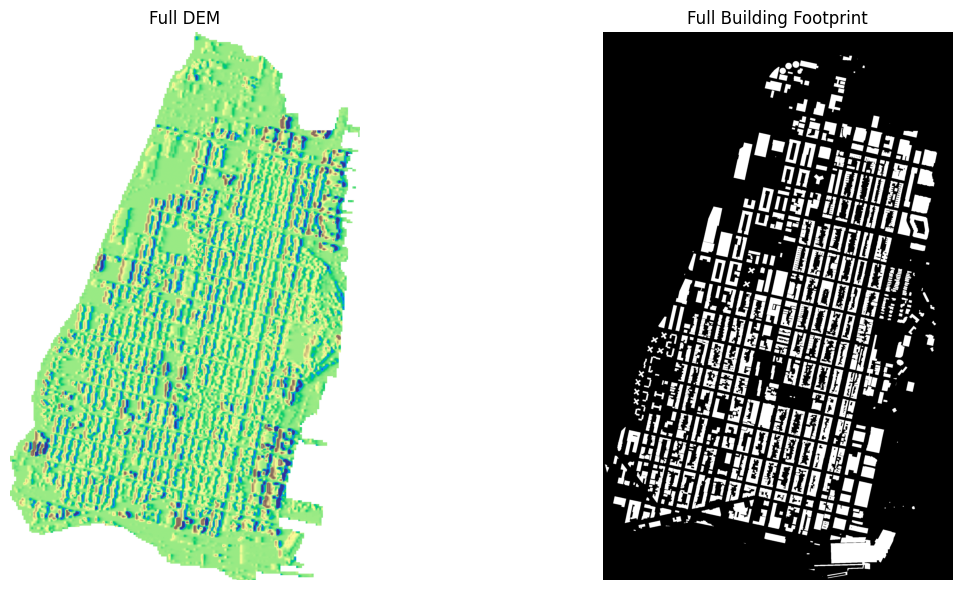

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].imshow(dem, cmap='terrain')
axes[0].set_title("Full DEM")
axes[0].axis('off')

axes[1].imshow(bldg, cmap='gray')
axes[1].set_title("Full Building Footprint")
axes[1].axis('off')

plt.tight_layout()
plt.show()

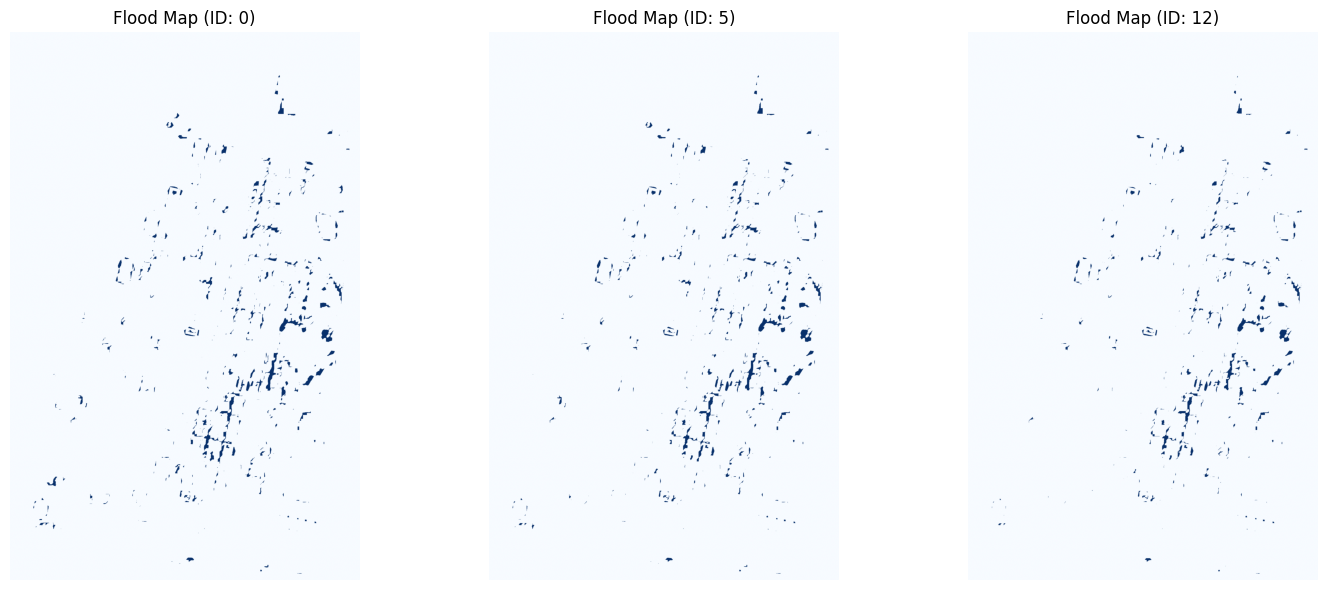

In [9]:
rainfall_ids = [0, 5, 12]

fig, axes = plt.subplots(1, len(rainfall_ids), figsize=(5 * len(rainfall_ids), 6))

for idx, rainfall_id in enumerate(rainfall_ids):
    flt_path = rf'C:\Users\sistudent\Desktop\PCSWMM5\outputs\{rainfall_id}\{rainfall_id}DepthFLT\{rainfall_id}Depth.FLT'
    with rasterio.open(flt_path) as src:
        depth = src.read(1)
        binary_flood = (depth > 1.0).astype(np.uint8)

    axes[idx].imshow(binary_flood, cmap='Blues')
    axes[idx].set_title(f"Flood Map (ID: {rainfall_id})")
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

In [10]:
from sklearn.model_selection import train_test_split

X_raster_train, X_raster_val, X_rain_train, X_rain_val, Y_train, Y_val = train_test_split(
    X_raster_all, X_rainfall_all, Y_flood_all, test_size=0.1, random_state=42
)

In [11]:
print(np.shape(X_raster_train))
print(np.shape(X_raster_val))
print(np.shape(X_rain_train))
print(np.shape(X_rain_val))
print(np.shape(Y_train))
print(np.shape(Y_val))

(10464, 256, 256, 2)
(1163, 256, 256, 2)
(10464, 189, 1)
(1163, 189, 1)
(10464, 256, 256, 1)
(1163, 256, 256, 1)


In [12]:
del X_raster_all, X_rainfall_all, Y_flood_all


import gc
gc.collect()

5224

In [13]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_loss', mode='min')
earlystop_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(
    x={"Raster_Input": X_raster_train, "Rainfall_Input": X_rain_train},
    y=Y_train,
    validation_data=({"Raster_Input": X_raster_val, "Rainfall_Input": X_rain_val}, Y_val),
    epochs=50,
    batch_size=8,  
    callbacks=[checkpoint_cb, earlystop_cb]
)

Epoch 1/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9904 - loss: 0.0438

1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1561s 1s/step - accuracy: 0.9904 - loss: 0.0438 - val_accuracy: 0.9929 - val_loss: 0.0404
Epoch 2/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9956 - loss: 0.0135

1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1543s 1s/step - accuracy: 0.9956 - loss: 0.0135 - val_accuracy: 0.9960 - val_loss: 0.0102
Epoch 3/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9963 - loss: 0.0098

1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1538s 1s/step - accuracy: 0.9963 - loss: 0.0098 - val_accuracy: 0.9964 - val_loss: 0.0087
Epoch 4/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9969 - loss: 0.0085

1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1545s 1s/step - accuracy: 0.9969 - loss: 0.0085 - val_accuracy: 0.9976 - val_loss: 0.0068
Epoch 5/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9973 - loss: 0.0075

1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1548s 1s/step - accuracy: 0.9973 - loss: 0.0075 - val_accuracy: 0.9979 - val_loss: 0.0057
Epoch 6/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1529s 1s/step - accuracy: 0.9978 - loss: 0.0059 - val_accuracy: 0.9972 - val_loss: 0.0117
Epoch 7/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9980 - loss: 0.0055

1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1550s 1s/step - accuracy: 0.9980 - loss: 0.0055 - val_accuracy: 0.9983 - val_loss: 0.0047
Epoch 8/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9982 - loss: 0.0050

1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1547s 1s/step - accuracy: 0.9982 - loss: 0.0050 - val_accuracy: 0.9983 - val_loss: 0.0045
Epoch 9/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9984 - loss: 0.0046

1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1548s 1s/step - accuracy: 0.9984 - loss: 0.0046 - val_accuracy: 0.9985 - val_loss: 0.0042
Epoch 10/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9985 - loss: 0.0042

1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1539s 1s/step - accuracy: 0.9985 - loss: 0.0042 - val_accuracy: 0.9987 - val_loss: 0.0037
Epoch 11/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9986 - loss: 0.0039

1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1536s 1s/step - accuracy: 0.9986 - loss: 0.0039 - val_accuracy: 0.9988 - val_loss: 0.0034
Epoch 12/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1518s 1s/step - accuracy: 0.9986 - loss: 0.0038 - val_accuracy: 0.9972 - val_loss: 0.0077
Epoch 13/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1503s 1s/step - accuracy: 0.9986 - loss: 0.0037 - val_accuracy: 0.9989 - val_loss: 0.0034
Epoch 14/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1500s 1s/step - accuracy: 0.9986 - loss: 0.0040 - val_accuracy: 0.9982 - val_loss: 0.0049
Epoch 15/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1494s 1s/step - accuracy: 0.9989 - loss: 0.0032 - val_accuracy: 0.9986 - val_loss: 0.0038
Epoch 16/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9988 - loss: 0.0033

1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1532s 1s/step - accuracy: 0.9988 - loss: 0.0033 - val_accuracy: 0.9991 - val_loss: 0.0027
Epoch 17/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9988 - loss: 0.0032

1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1527s 1s/step - accuracy: 0.9988 - loss: 0.0032 - val_accuracy: 0.9992 - val_loss: 0.0025
Epoch 18/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9990 - loss: 0.0028

1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1530s 1s/step - accuracy: 0.9990 - loss: 0.0028 - val_accuracy: 0.9992 - val_loss: 0.0024
Epoch 19/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1504s 1s/step - accuracy: 0.9989 - loss: 0.0030 - val_accuracy: 0.9992 - val_loss: 0.0025
Epoch 20/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1499s 1s/step - accuracy: 0.9990 - loss: 0.0028 - val_accuracy: 0.9991 - val_loss: 0.0026
Epoch 21/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1499s 1s/step - accuracy: 0.9990 - loss: 0.0029 - val_accuracy: 0.9992 - val_loss: 0.0024
Epoch 22/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1501s 1s/step - accuracy: 0.9990 - loss: 0.0028 - val_accuracy: 0.9992 - val_loss: 0.0024
Epoch 23/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1514s 1s/step - accuracy: 0.9991 - loss: 0.0025 - val_accuracy: 0.9992 - val_loss: 0.0026
Epoch 24/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1507s 1s/step - accuracy: 0.9991 - loss: 0.0025 - val_accuracy: 0.9989 - val_loss: 0.0031
Epoch 25/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9991 - loss: 

1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1545s 1s/step - accuracy: 0.9991 - loss: 0.0024 - val_accuracy: 0.9992 - val_loss: 0.0023
Epoch 26/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9991 - loss: 0.0025

1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1551s 1s/step - accuracy: 0.9991 - loss: 0.0025 - val_accuracy: 0.9993 - val_loss: 0.0022
Epoch 27/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1518s 1s/step - accuracy: 0.9992 - loss: 0.0022 - val_accuracy: 0.9991 - val_loss: 0.0028
Epoch 28/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1527s 1s/step - accuracy: 0.9992 - loss: 0.0023 - val_accuracy: 0.9990 - val_loss: 0.0032
Epoch 29/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1514s 1s/step - accuracy: 0.9992 - loss: 0.0021 - val_accuracy: 0.9993 - val_loss: 0.0023
Epoch 30/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1513s 1s/step - accuracy: 0.9992 - loss: 0.0022 - val_accuracy: 0.9992 - val_loss: 0.0026
Epoch 31/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9992 - loss: 0.0021

1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1570s 1s/step - accuracy: 0.9992 - loss: 0.0021 - val_accuracy: 0.9993 - val_loss: 0.0022
Epoch 32/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9992 - loss: 0.0022

1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1566s 1s/step - accuracy: 0.9992 - loss: 0.0022 - val_accuracy: 0.9994 - val_loss: 0.0020
Epoch 33/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1537s 1s/step - accuracy: 0.9993 - loss: 0.0019 - val_accuracy: 0.9993 - val_loss: 0.0021
Epoch 34/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1531s 1s/step - accuracy: 0.9993 - loss: 0.0018 - val_accuracy: 0.9993 - val_loss: 0.0021
Epoch 35/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1534s 1s/step - accuracy: 0.9993 - loss: 0.0019 - val_accuracy: 0.9990 - val_loss: 0.0031
Epoch 36/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1538s 1s/step - accuracy: 0.9993 - loss: 0.0019 - val_accuracy: 0.9990 - val_loss: 0.0031
Epoch 37/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1545s 1s/step - accuracy: 0.9993 - loss: 0.0020 - val_accuracy: 0.9993 - val_loss: 0.0022
Epoch 38/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1530s 1s/step - accuracy: 0.9993 - loss: 0.0021 - val_accuracy: 0.9990 - val_loss: 0.0033
Epoch 39/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1537s 1s/step - accuracy: 0.9993 - los

In [14]:
save_path = r'C:\Users\sistudent\Desktop\PCSWMM5\Trained_NN'

# Keras
model.save(f"{save_path}\\model_150.keras")

# HDF5
model.save(f"{save_path}\\model_150.h5")

In [49]:
Y_pred_prob = model.predict({"Raster_Input": X_raster_val, "Rainfall_Input": X_rain_val}, verbose=1)
Y_pred_bin = (Y_pred_prob > 0.5).astype(np.uint8)

37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step


In [63]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

y_true = Y_val.flatten().astype(np.uint8)
y_pred = Y_pred_bin.flatten().astype(np.uint8)

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

csi = tp / (tp + fp + fn) if (tp + fp + fn) != 0 else 0.0

print(f"Accuracy:      {acc:.4f}")
print(f"Precision:     {prec:.4f}")
print(f"Recall:        {rec:.4f}")
print(f"F1 Score:      {f1:.4f}")
print(f"CSI (Threat Score): {csi:.4f}")
print(f"Confusion Matrix:")
print(f"  TN = {tn}")
print(f"  FP = {fp}")
print(f"  FN = {fn}")
print(f"  TP = {tp}")

Accuracy:      0.9994
Precision:     0.9669
Recall:        0.9218
F1 Score:      0.9438
CSI (Threat Score): 0.8936
Confusion Matrix:
  TN = 75774690
  FP = 13577
  FN = 33649
  TP = 396452


In [17]:
def stitch_patches(patches, patch_indices, full_shape=(2842, 1812)):
    stitched = np.zeros(full_shape, dtype=np.float32)

    for patch, (i, j) in zip(patches, patch_indices):
        stitched[i:i+256, j:j+256] = patch.squeeze()  

    return stitched

Processing Rainfall #0...


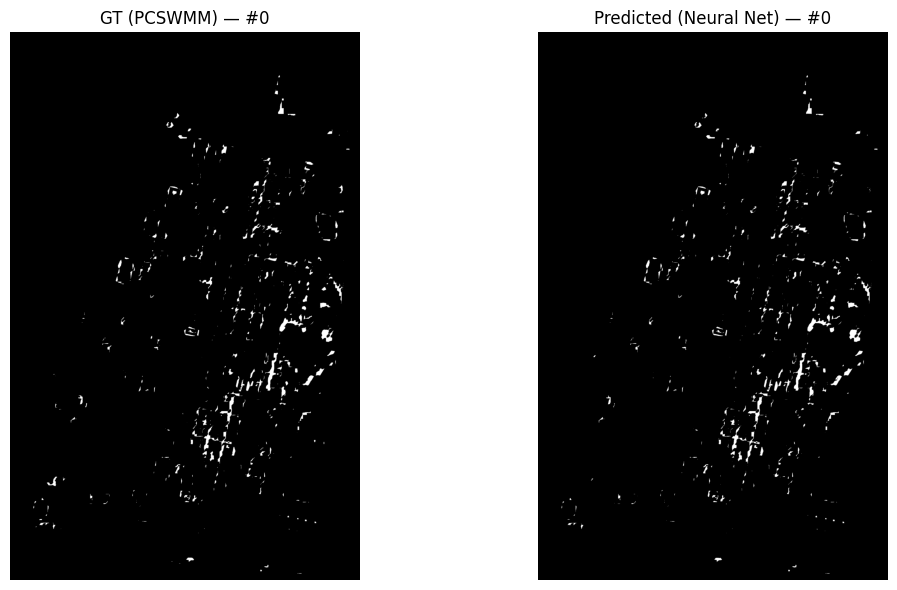

Processing Rainfall #1...


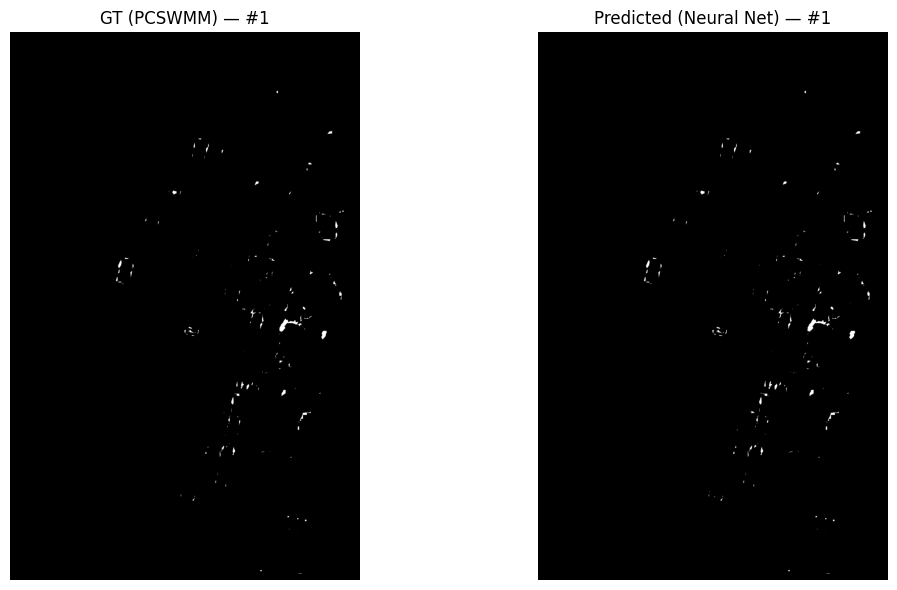

Processing Rainfall #2...


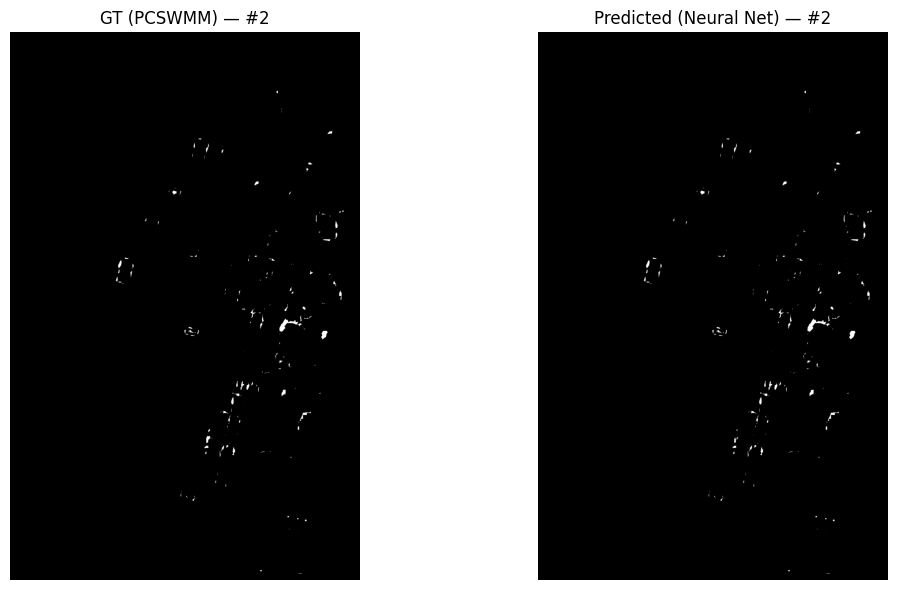

Processing Rainfall #3...


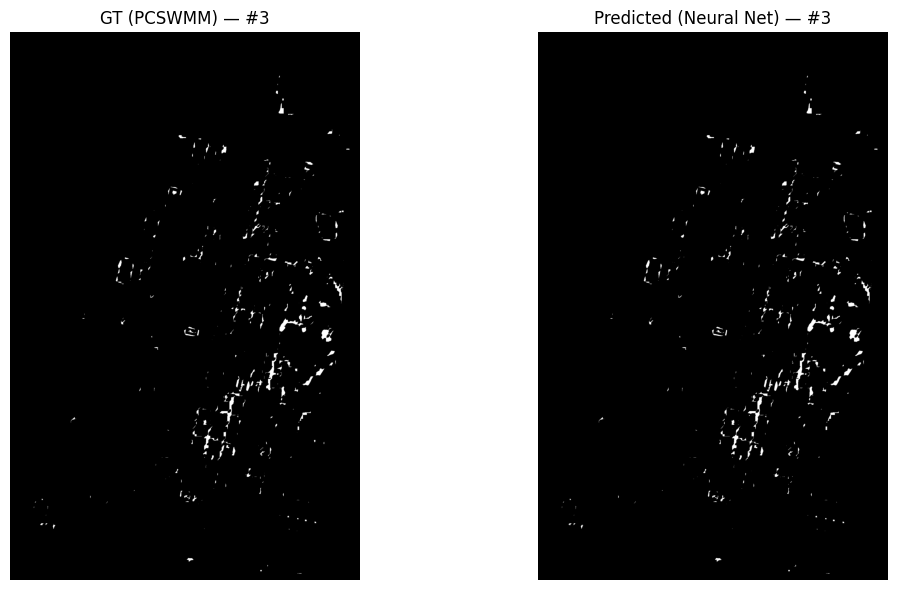

Processing Rainfall #4...


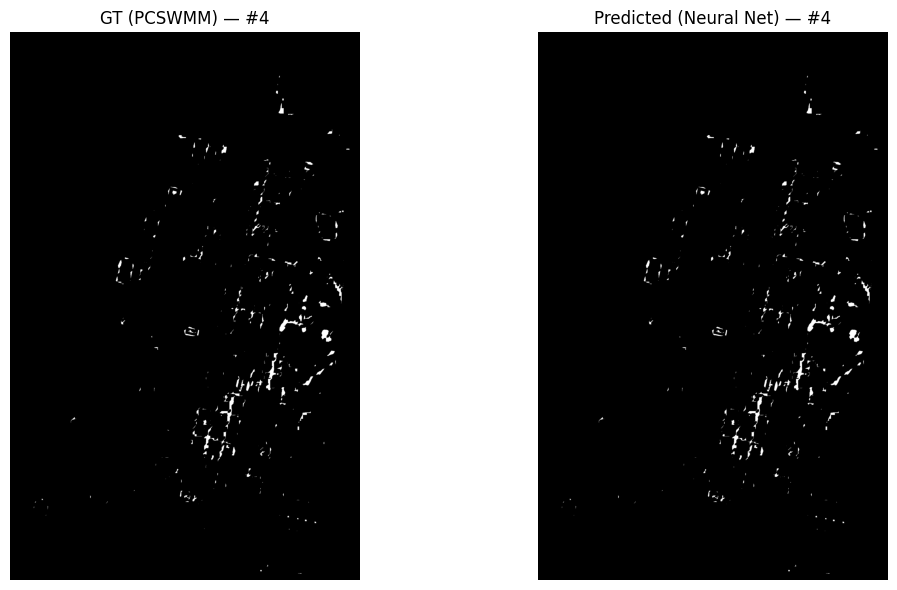

Processing Rainfall #5...


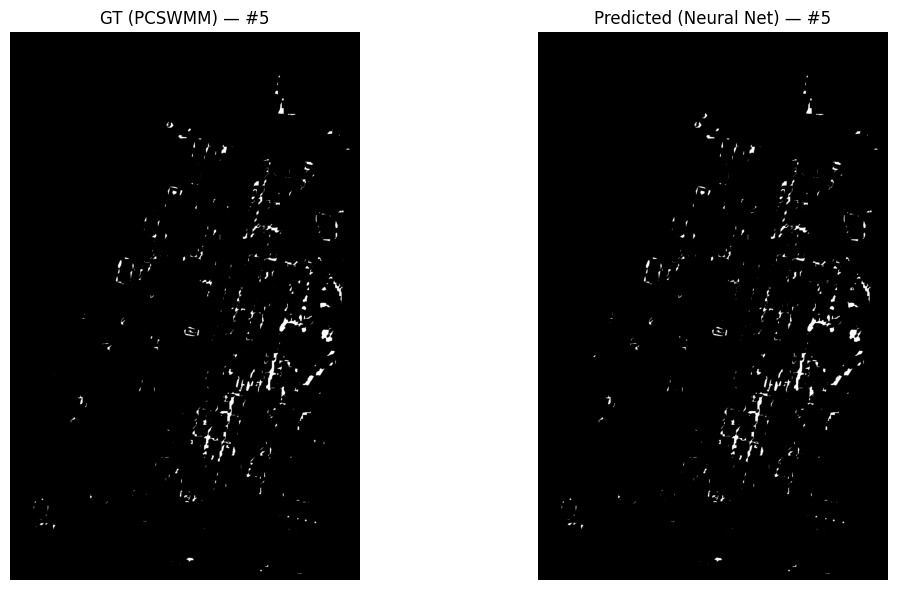

Processing Rainfall #6...


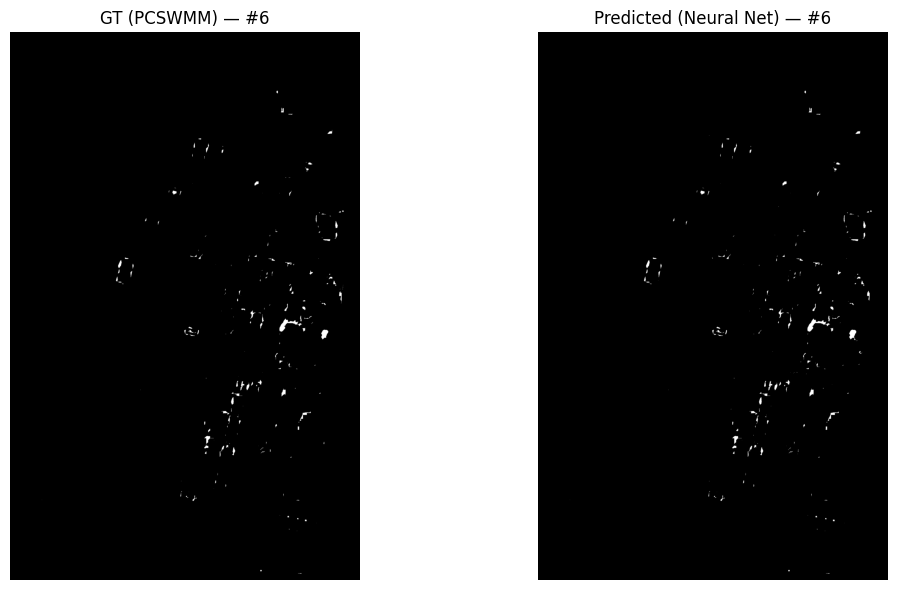

Processing Rainfall #7...


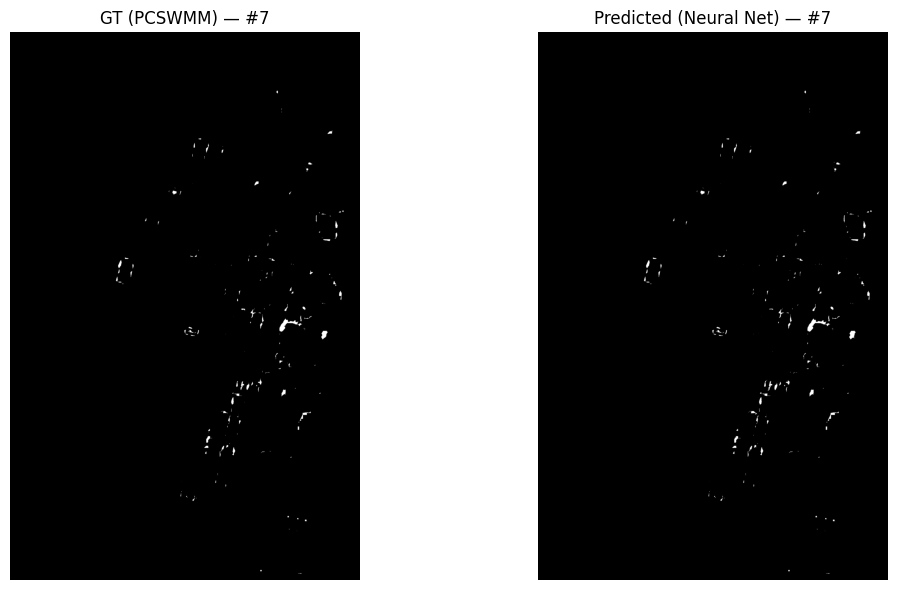

Processing Rainfall #8...


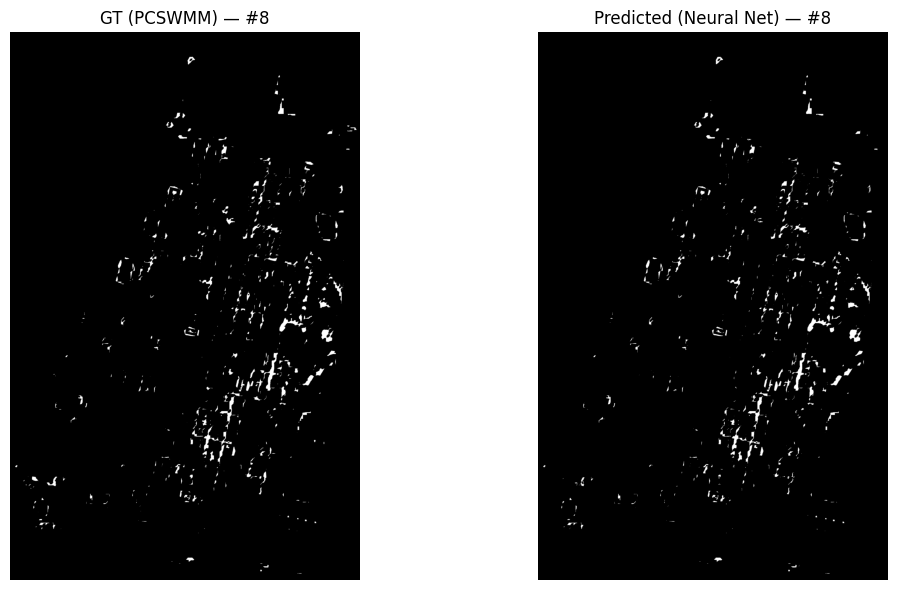

Processing Rainfall #9...


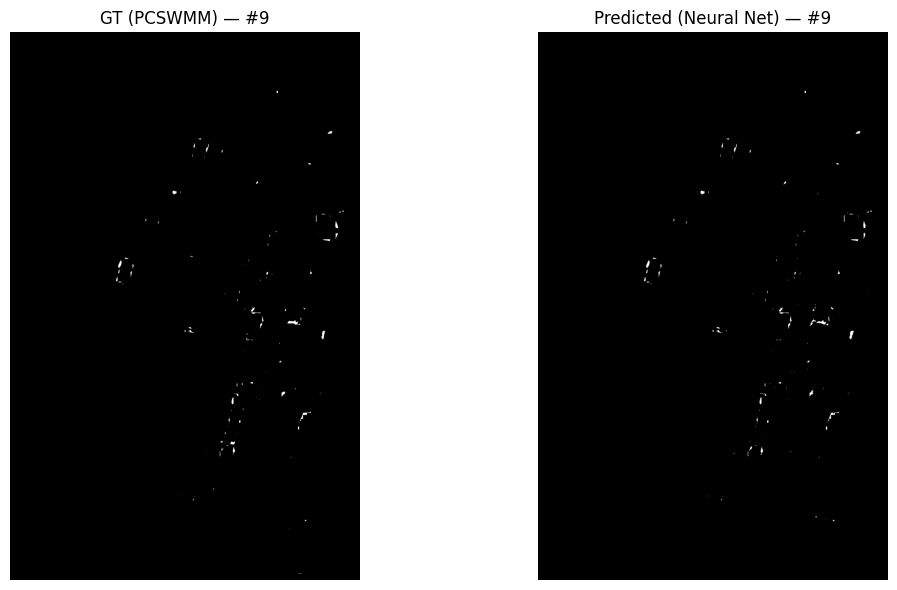

Processing Rainfall #10...


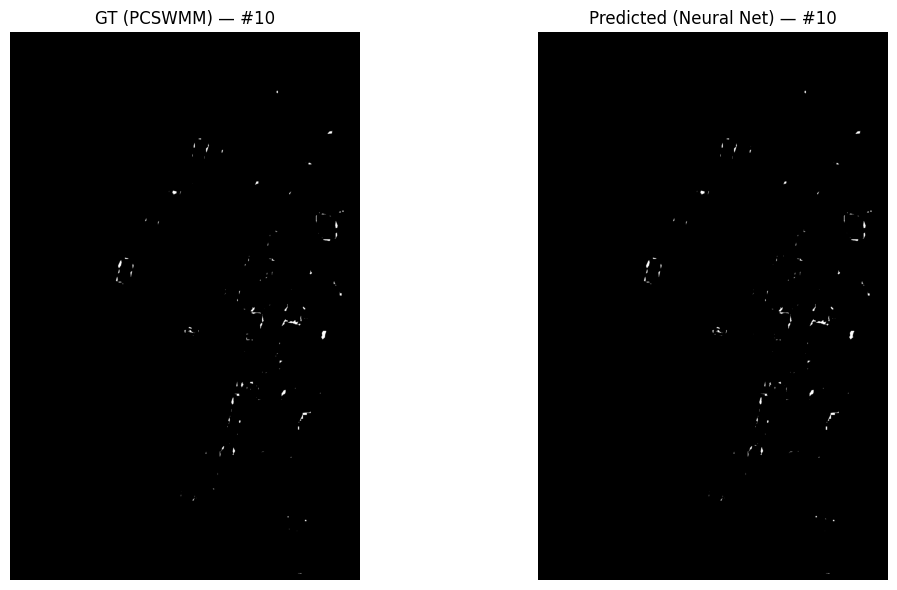

Processing Rainfall #11...


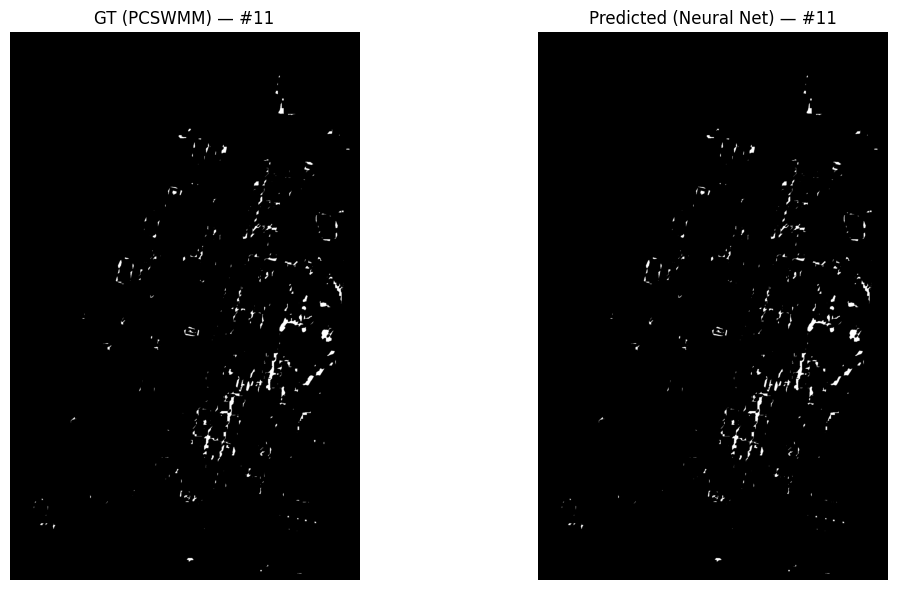

Processing Rainfall #12...


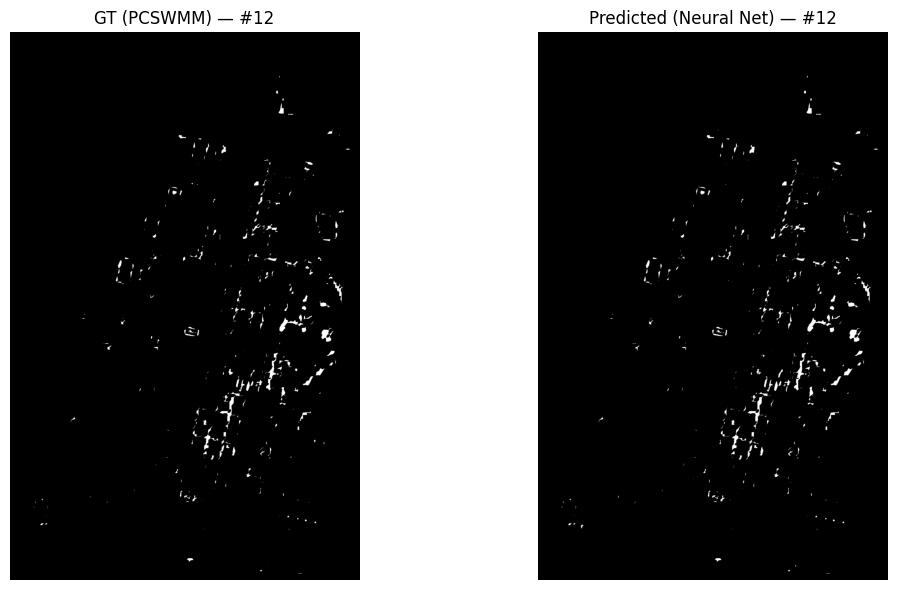

Processing Rainfall #13...


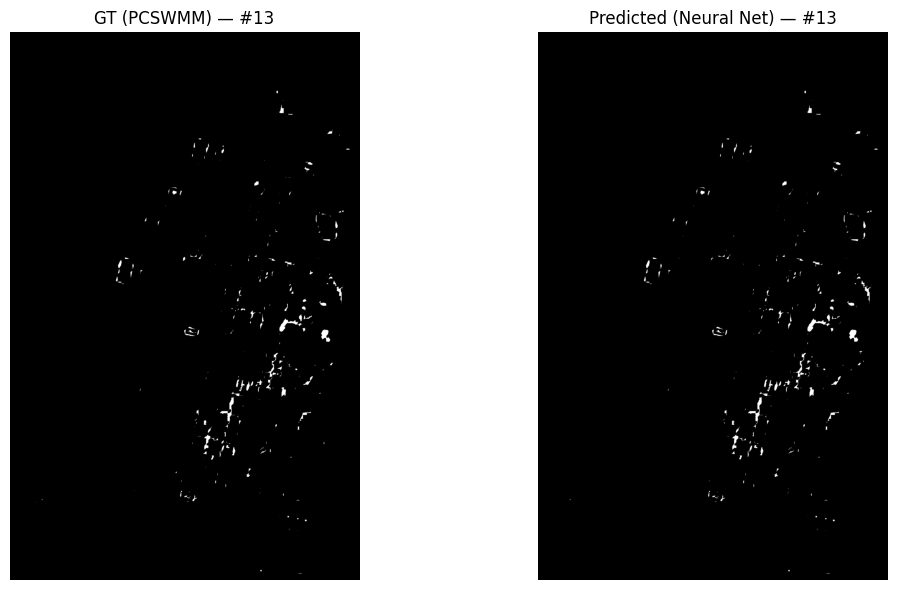

Processing Rainfall #14...


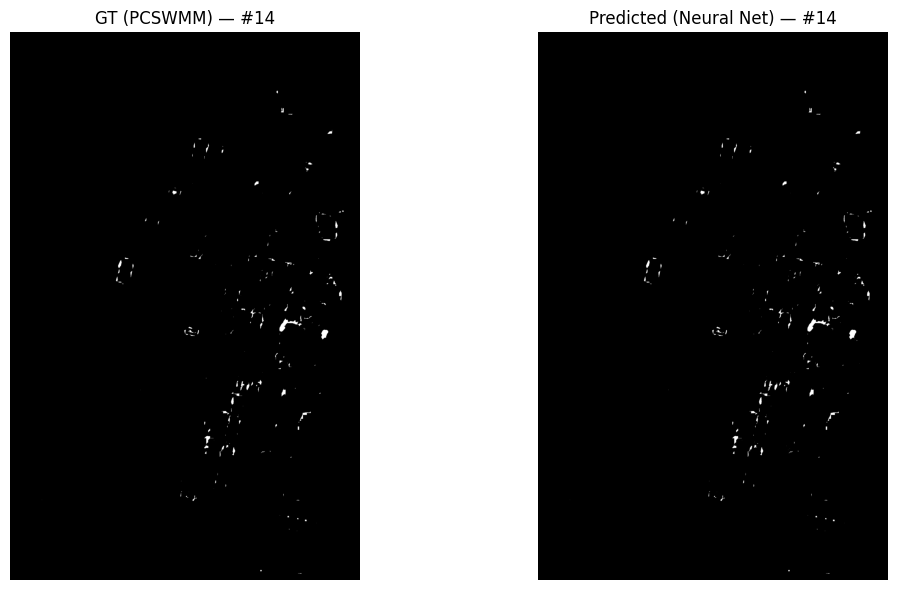

Processing Rainfall #15...


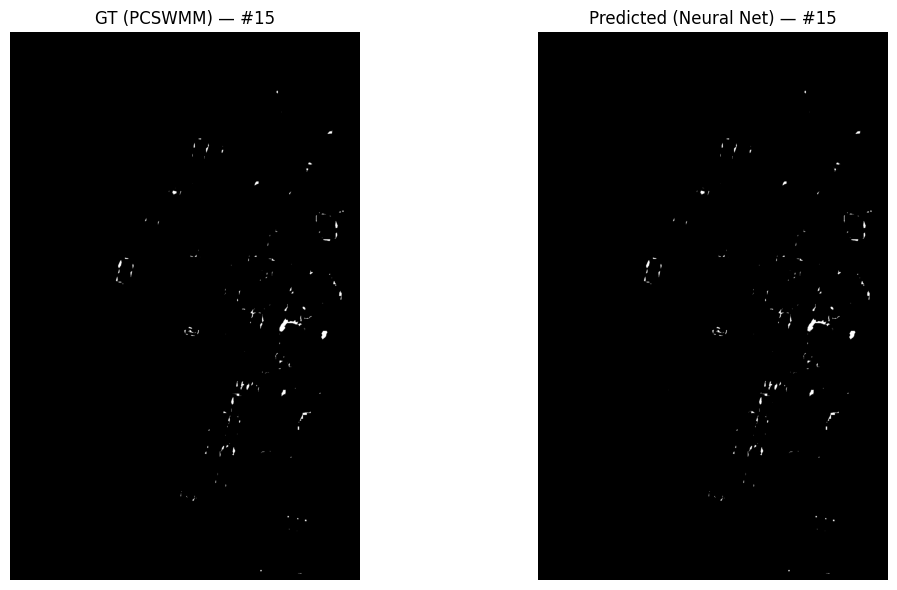

Processing Rainfall #16...


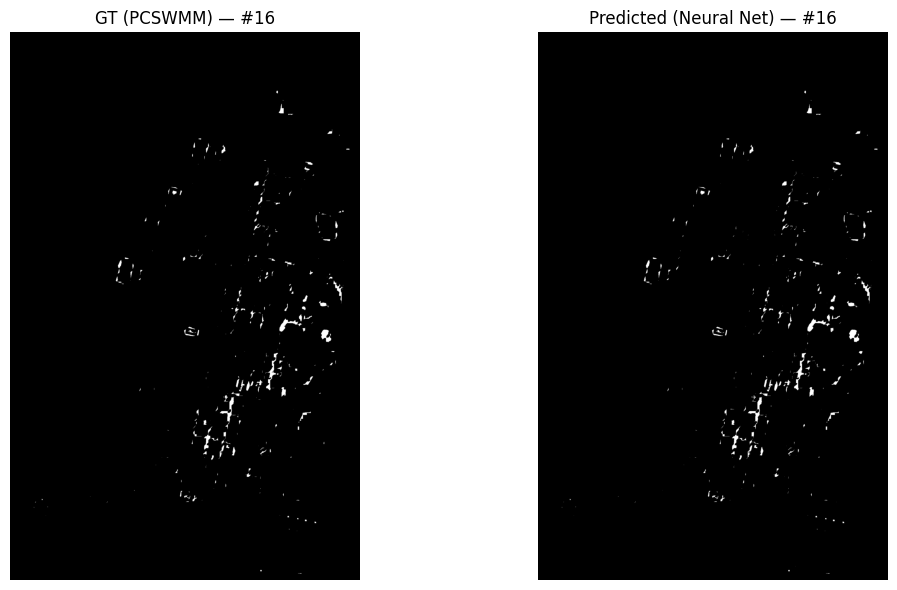

Processing Rainfall #17...


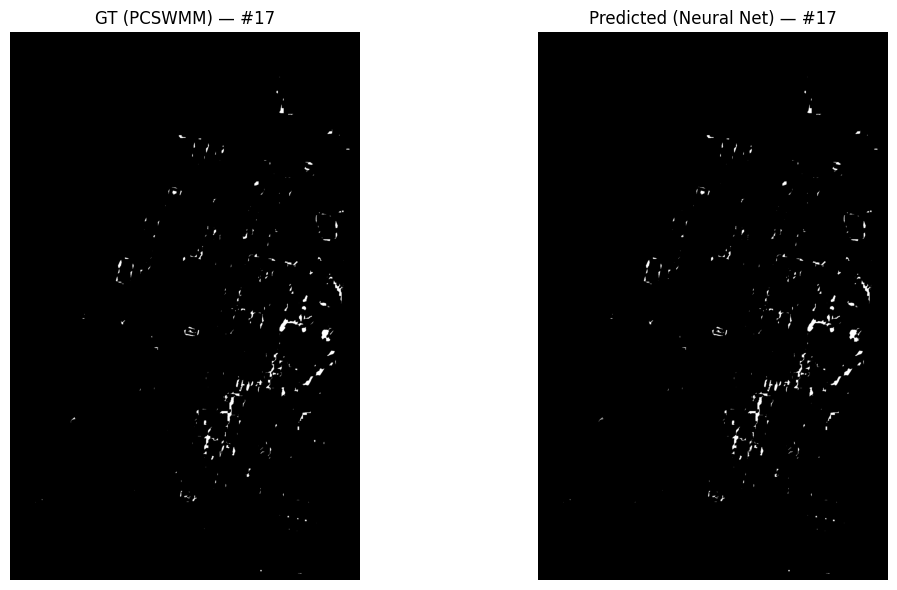

Processing Rainfall #18...


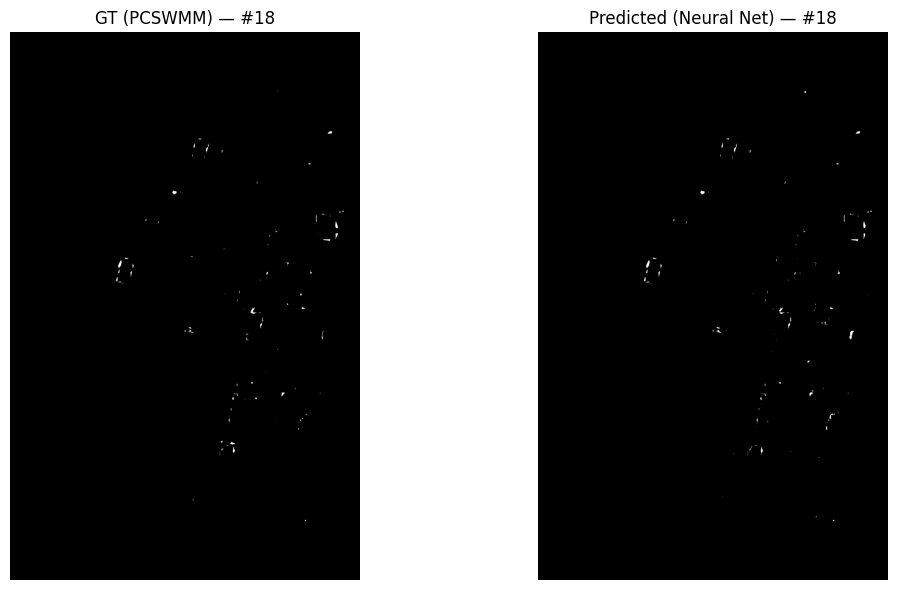

Processing Rainfall #19...


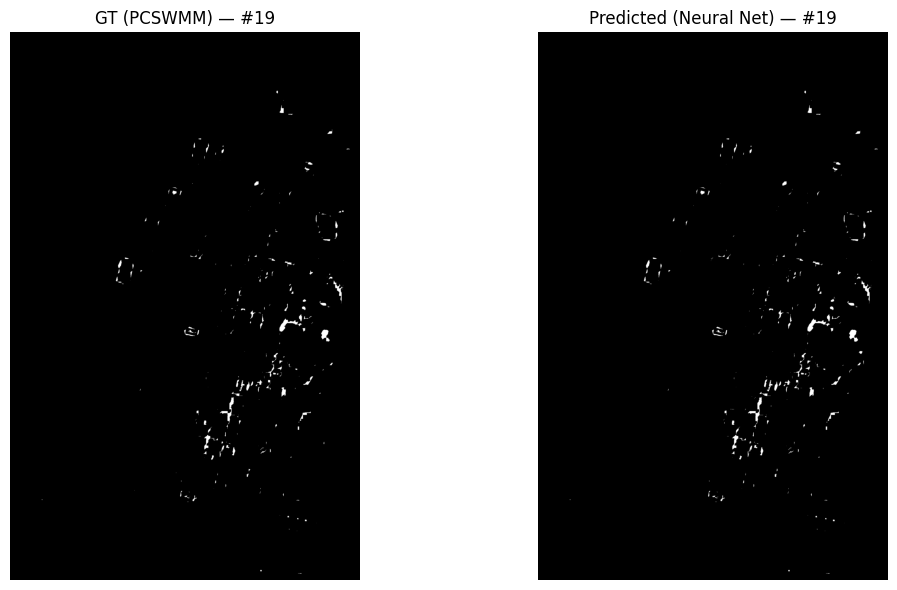

Processing Rainfall #20...


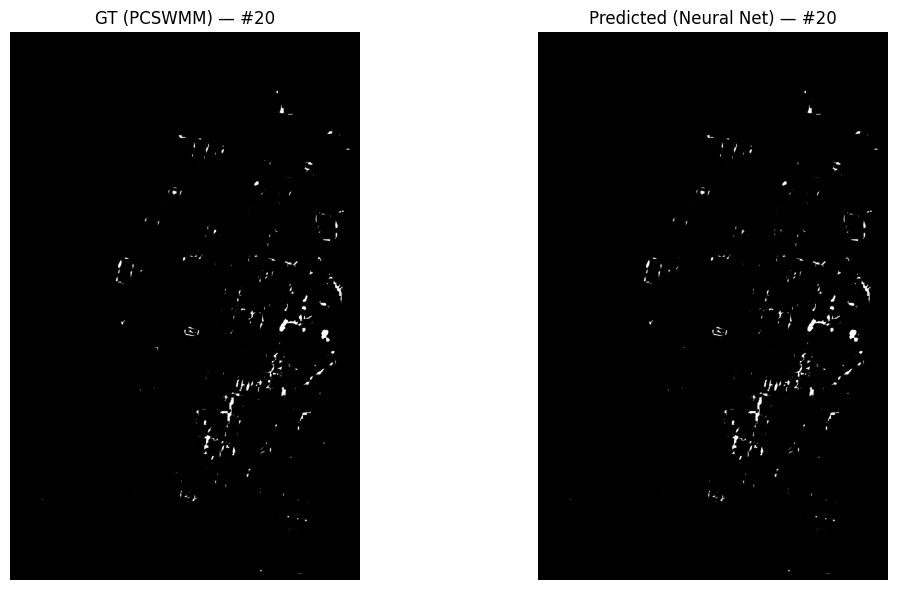

Processing Rainfall #21...


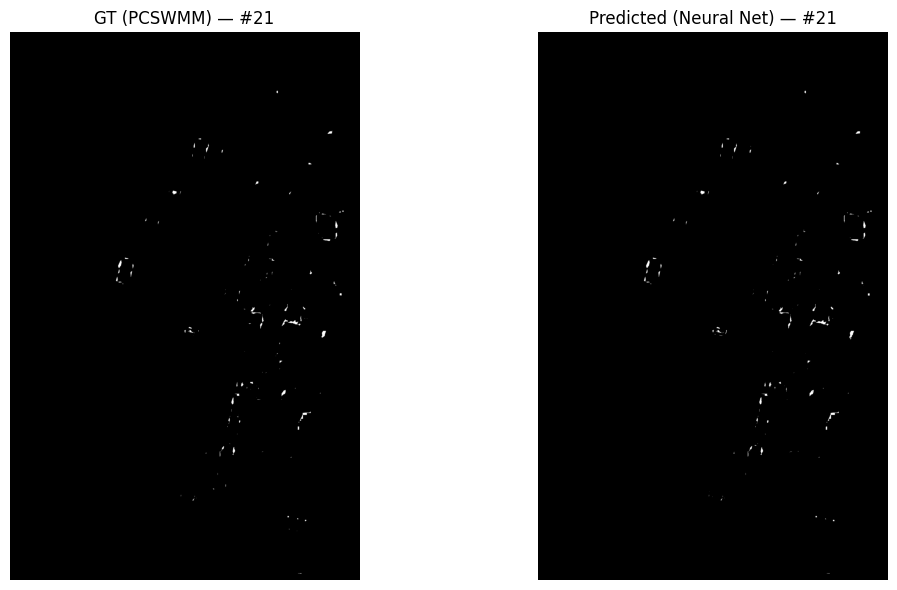

Processing Rainfall #22...


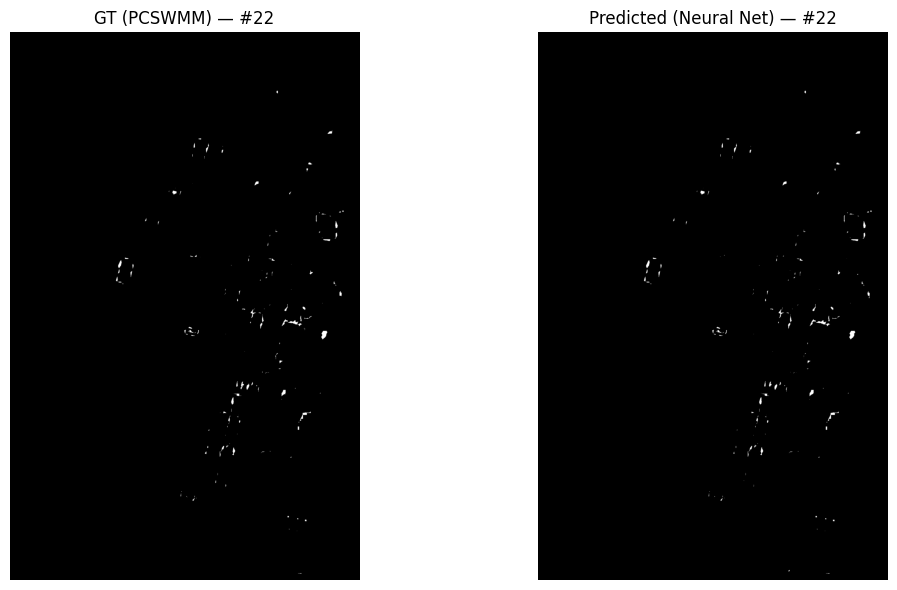

Processing Rainfall #23...


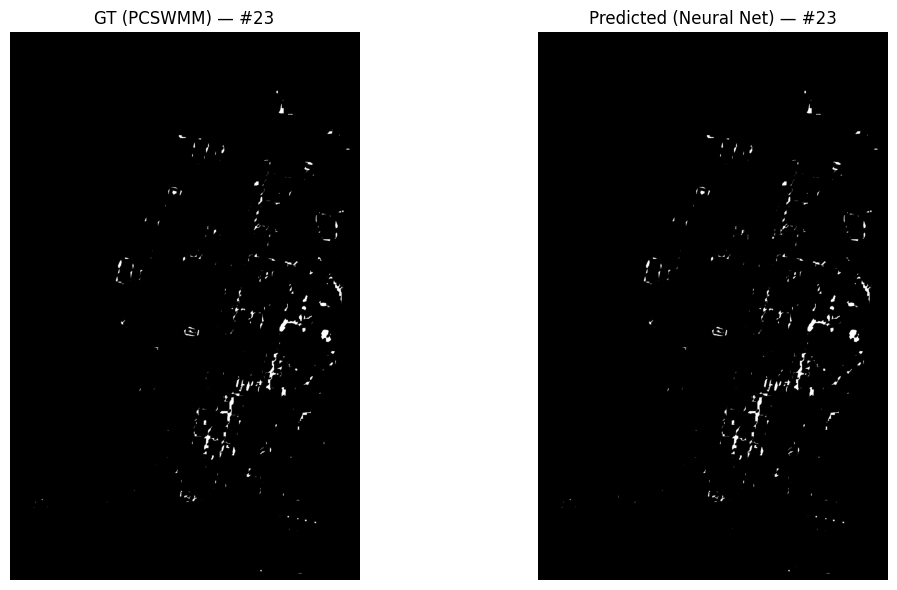

Processing Rainfall #24...


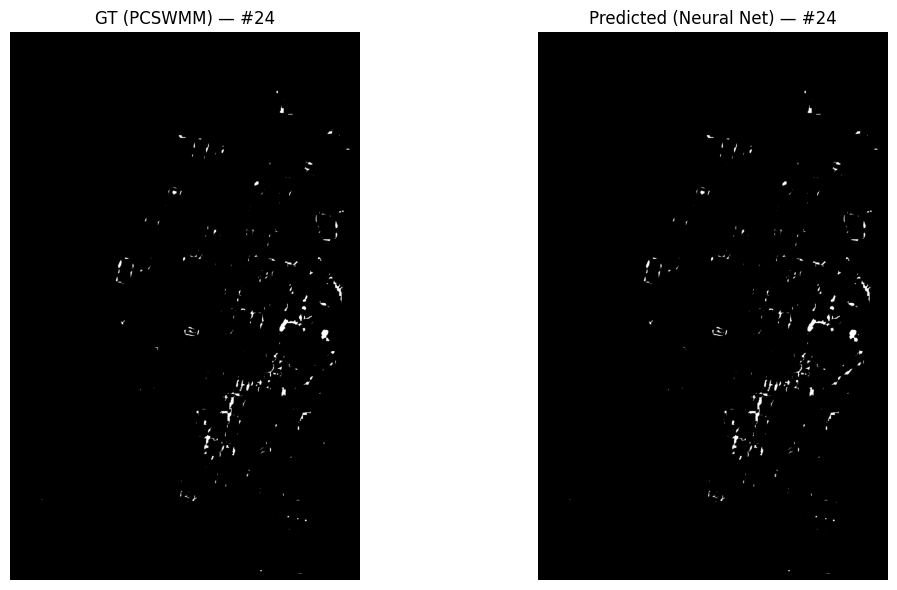

Processing Rainfall #25...


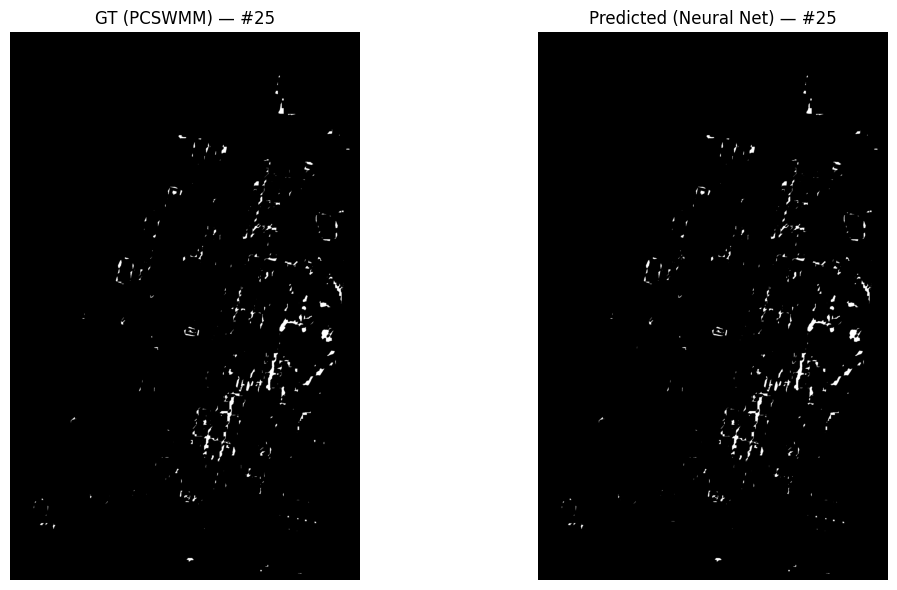

Processing Rainfall #26...


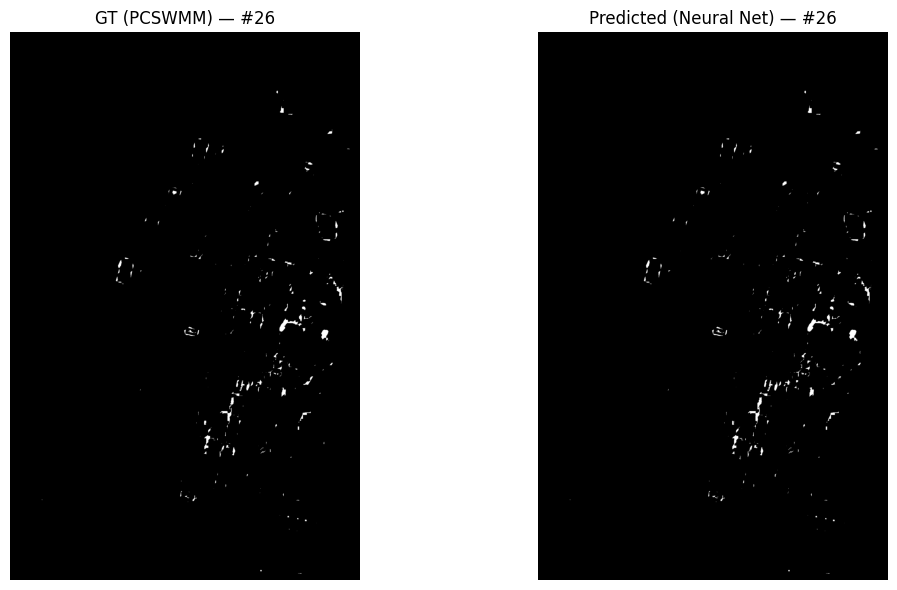

Processing Rainfall #27...


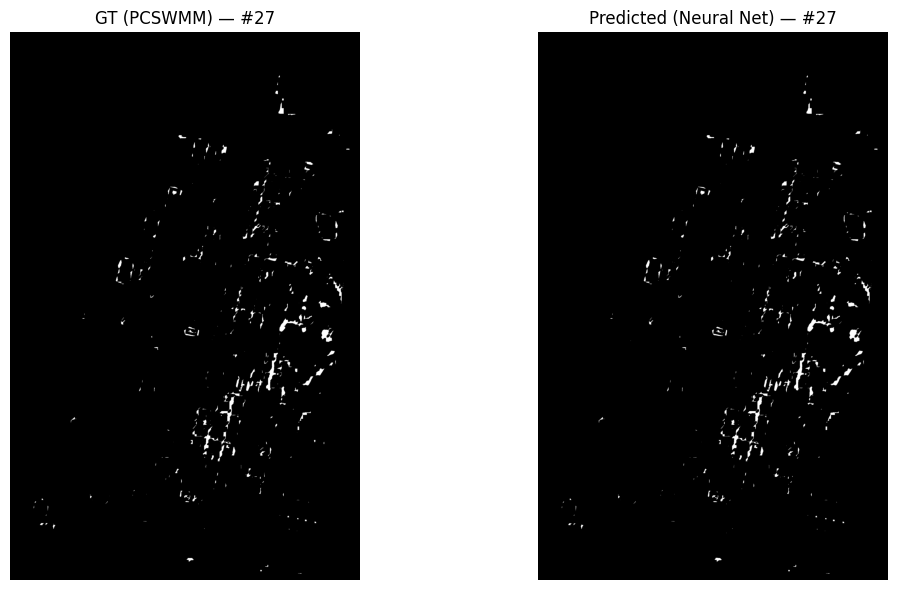

Processing Rainfall #28...


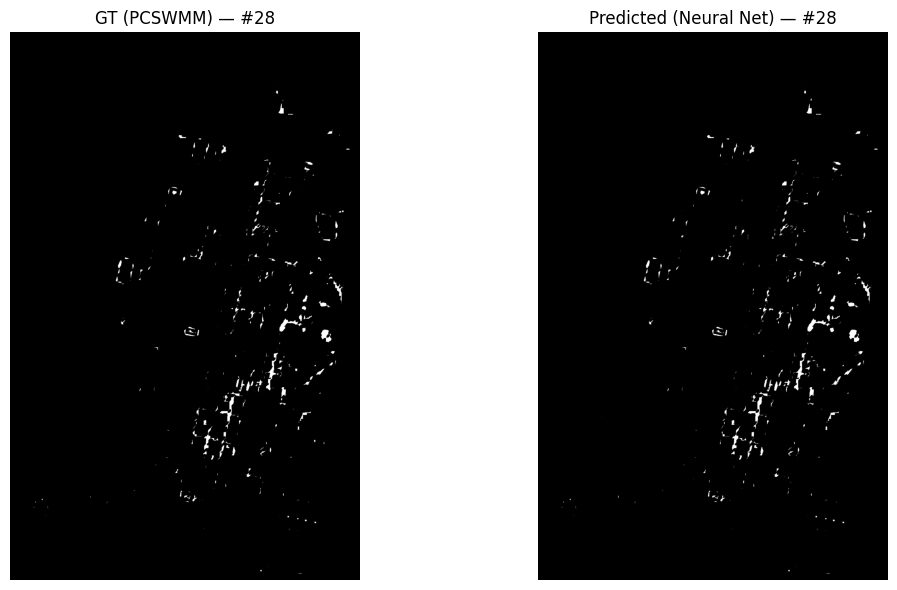

Processing Rainfall #29...


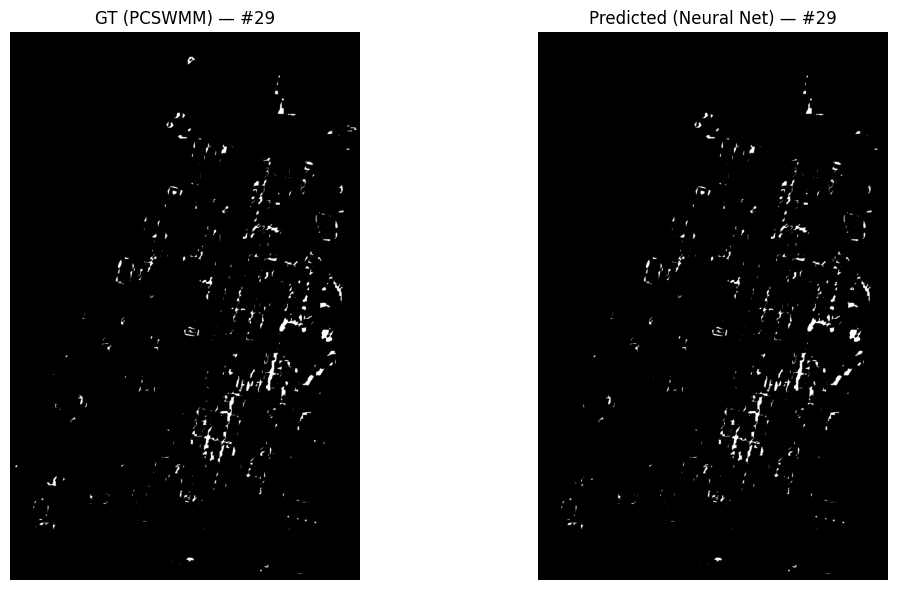

Processing Rainfall #30...


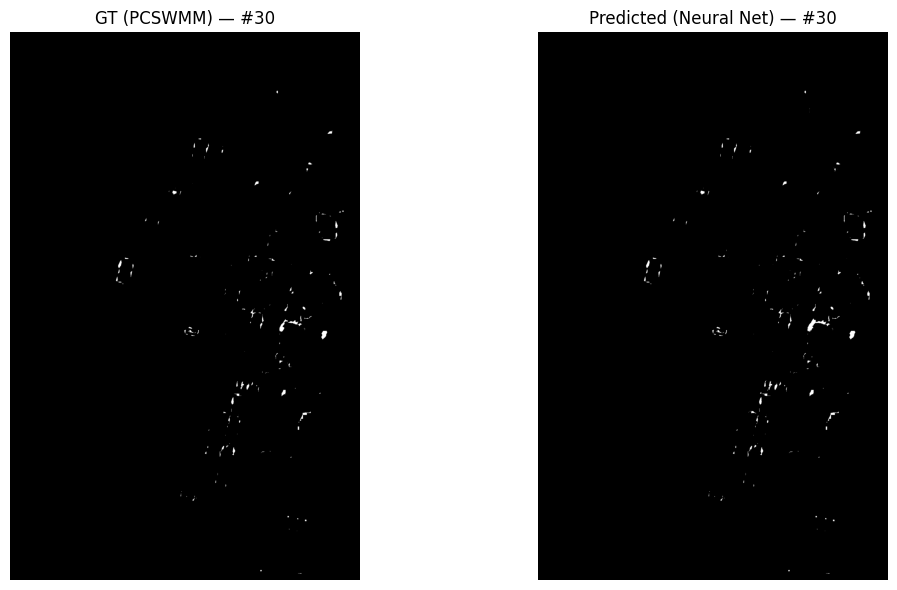

Processing Rainfall #31...


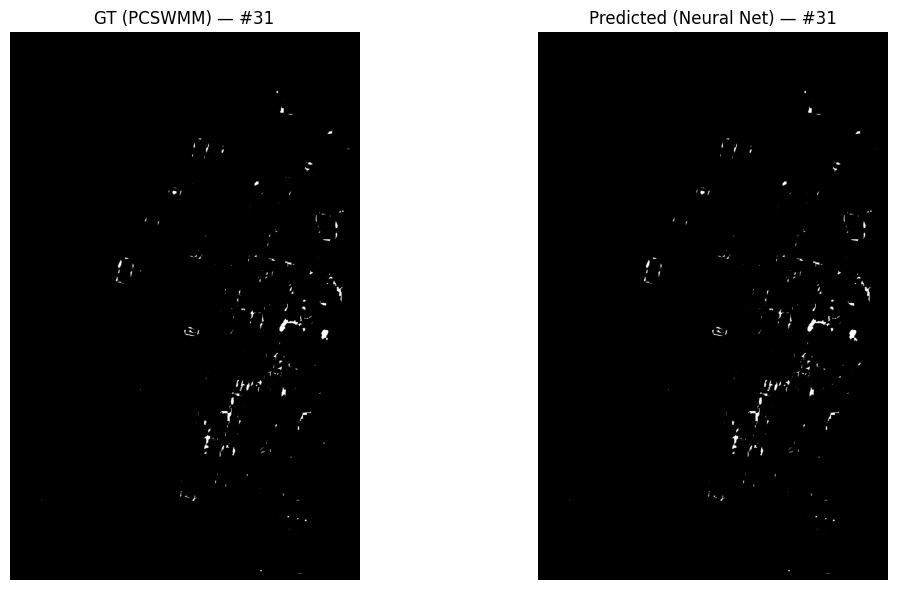

Processing Rainfall #32...


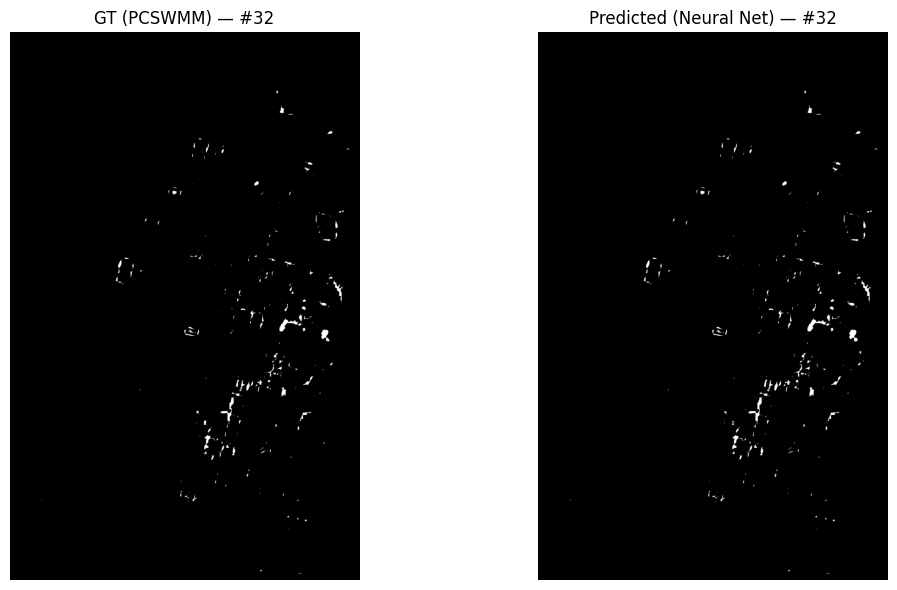

Processing Rainfall #33...


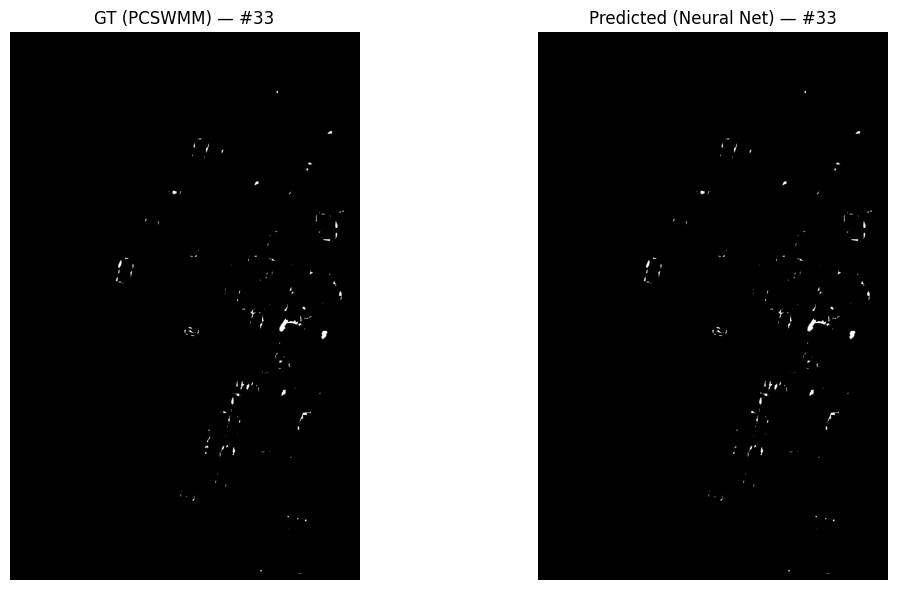

Processing Rainfall #34...


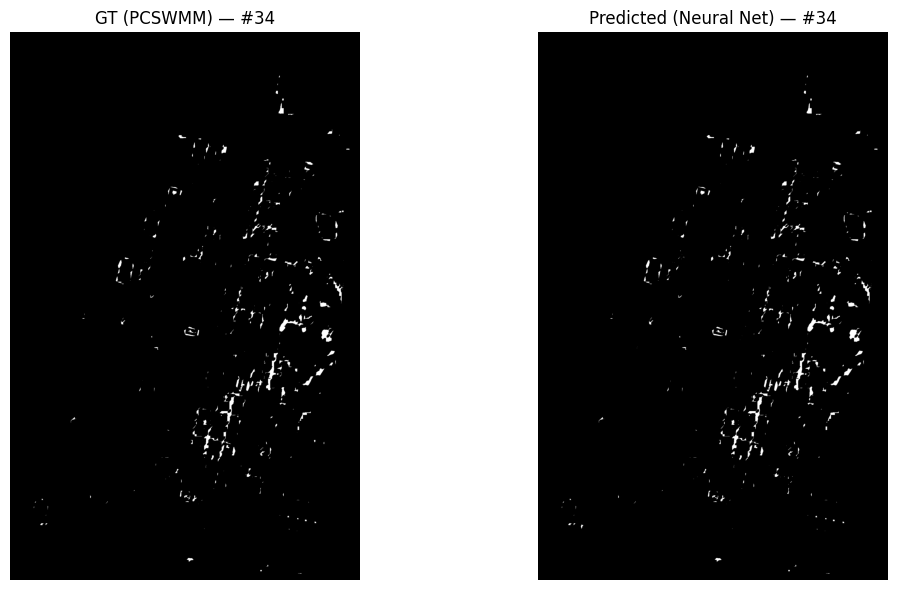

Processing Rainfall #35...


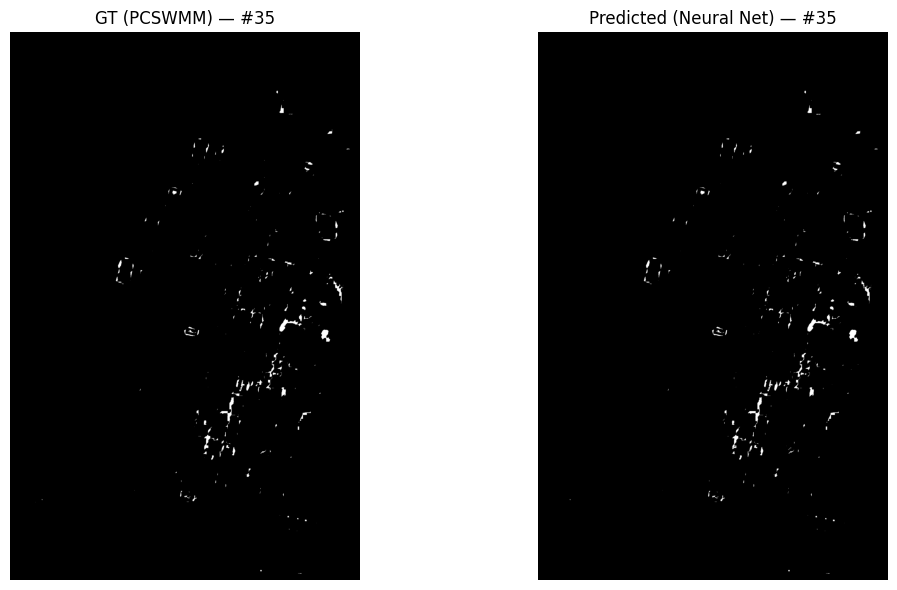

Processing Rainfall #36...


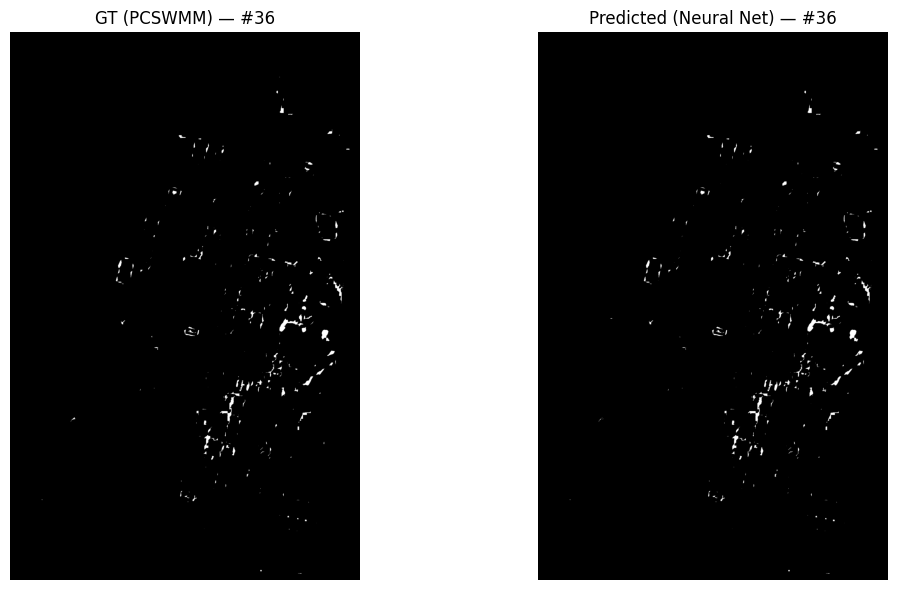

Processing Rainfall #37...


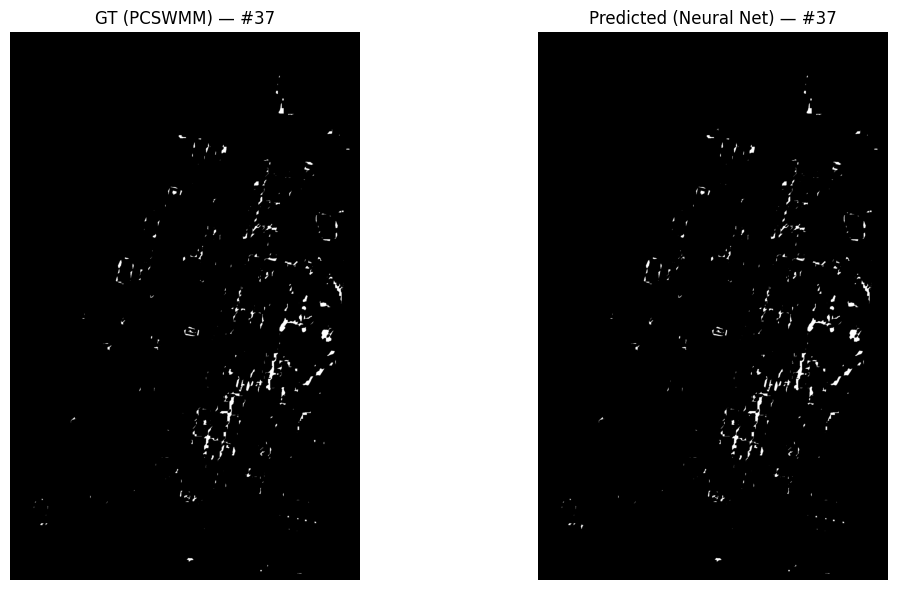

Processing Rainfall #38...


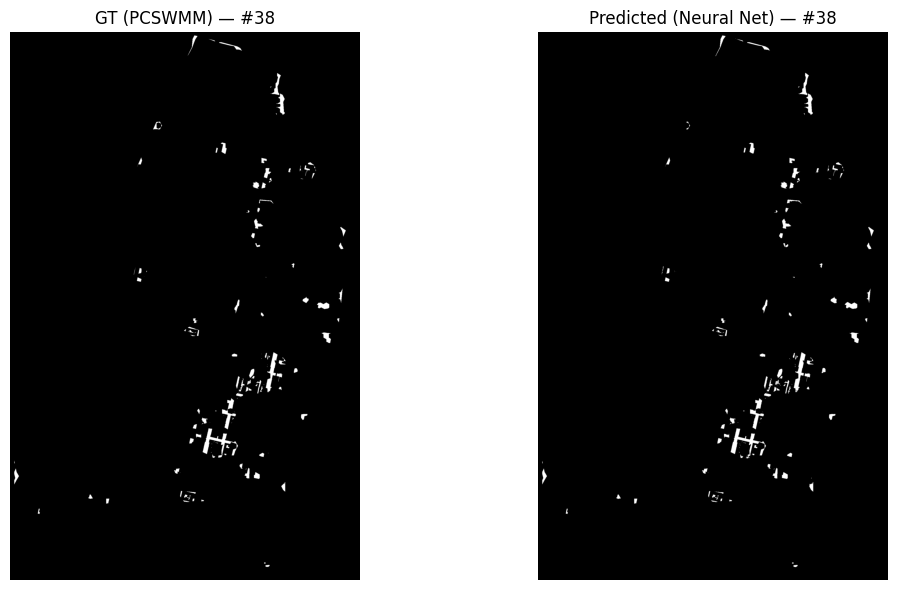

Processing Rainfall #39...


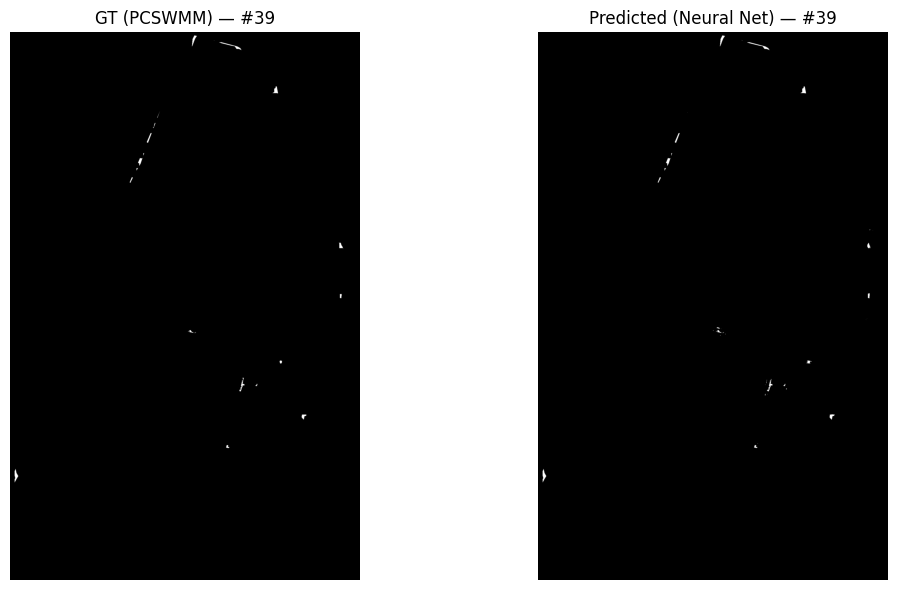

Processing Rainfall #40...


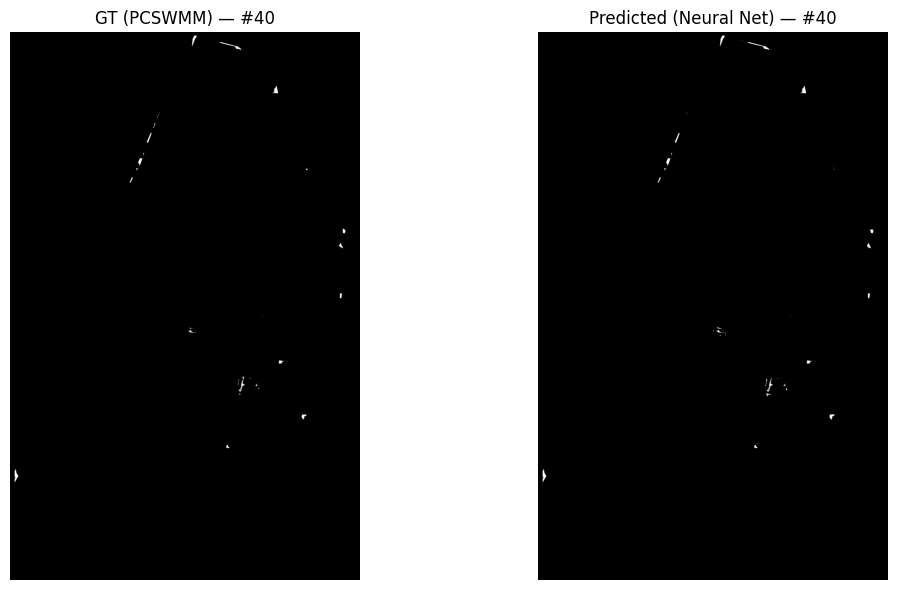

Processing Rainfall #41...


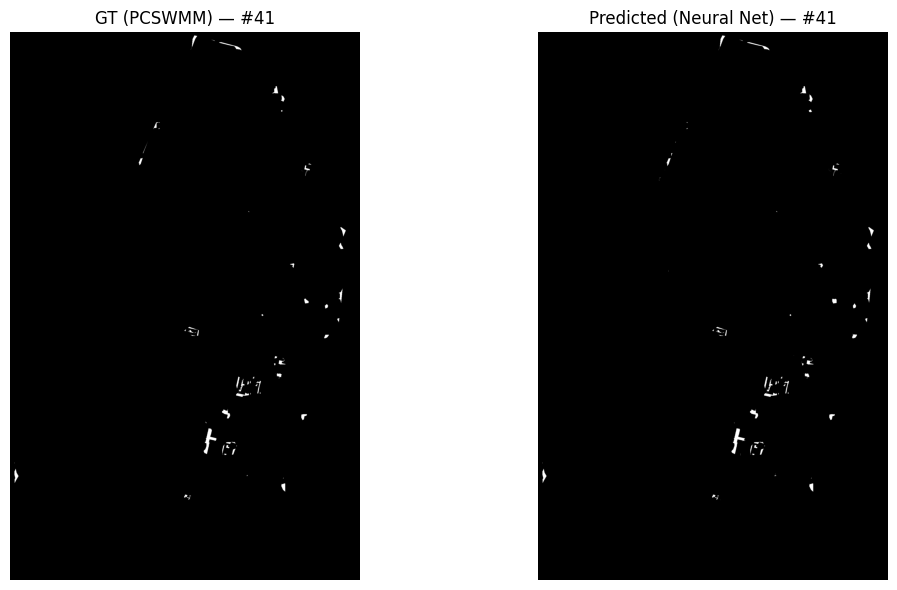

Processing Rainfall #42...


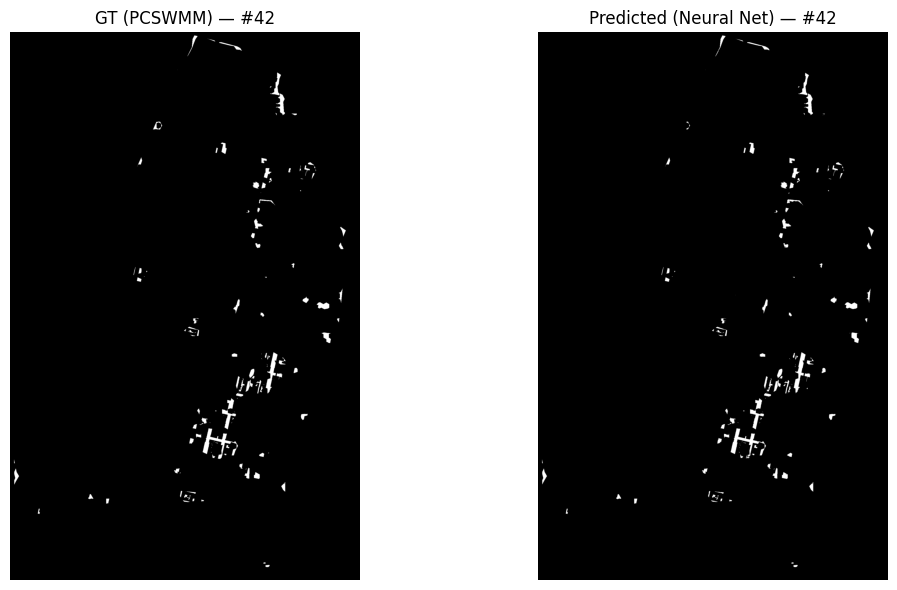

Processing Rainfall #43...


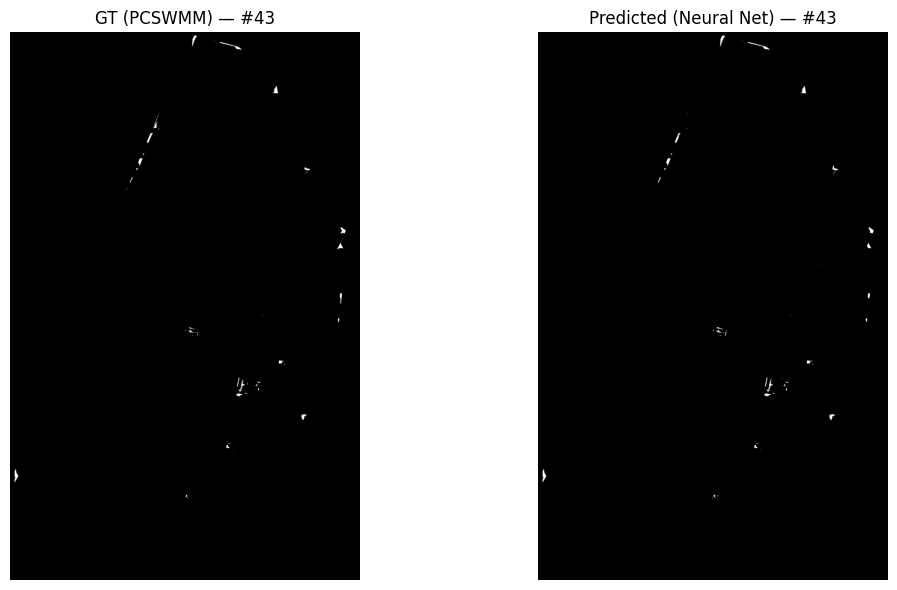

Processing Rainfall #44...


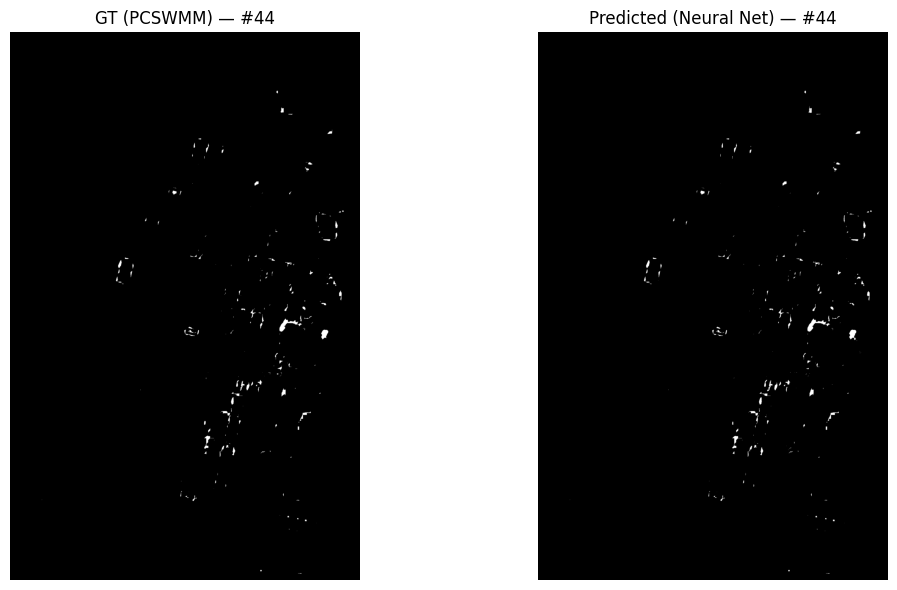

Processing Rainfall #45...


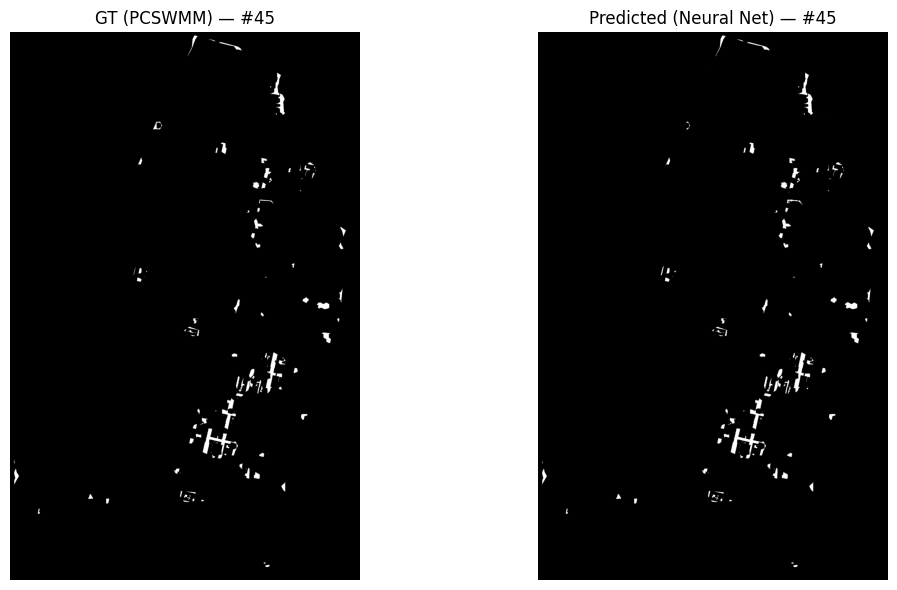

Processing Rainfall #46...


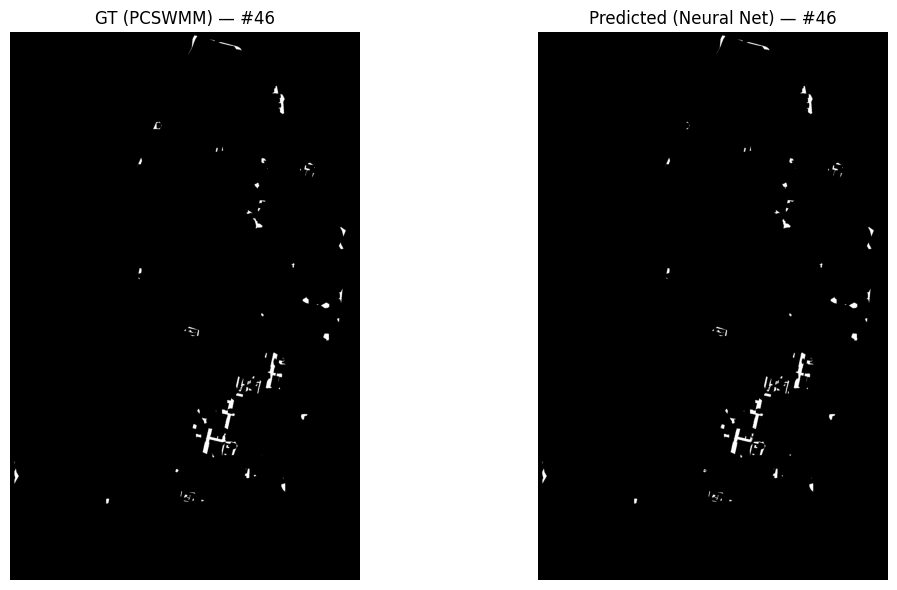

Processing Rainfall #47...


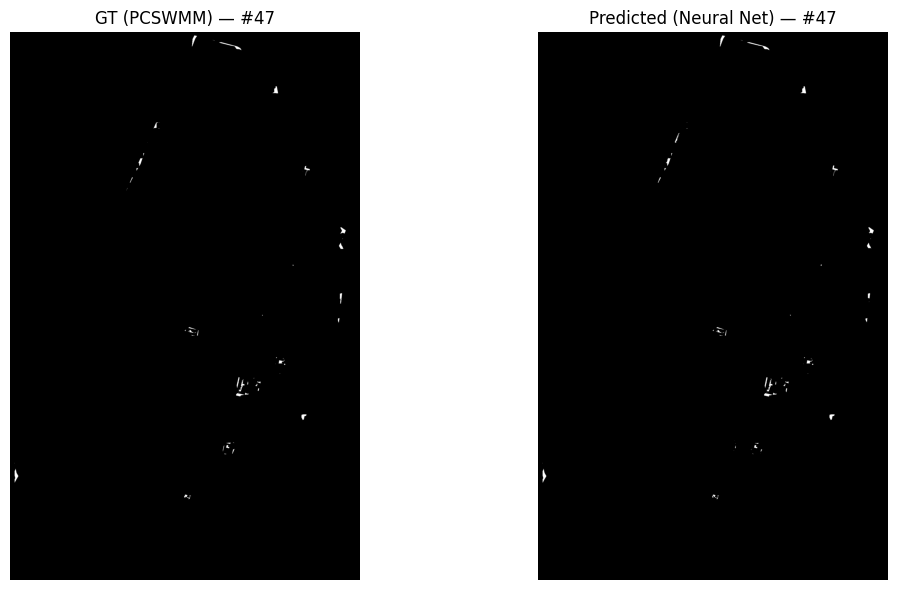

Processing Rainfall #48...


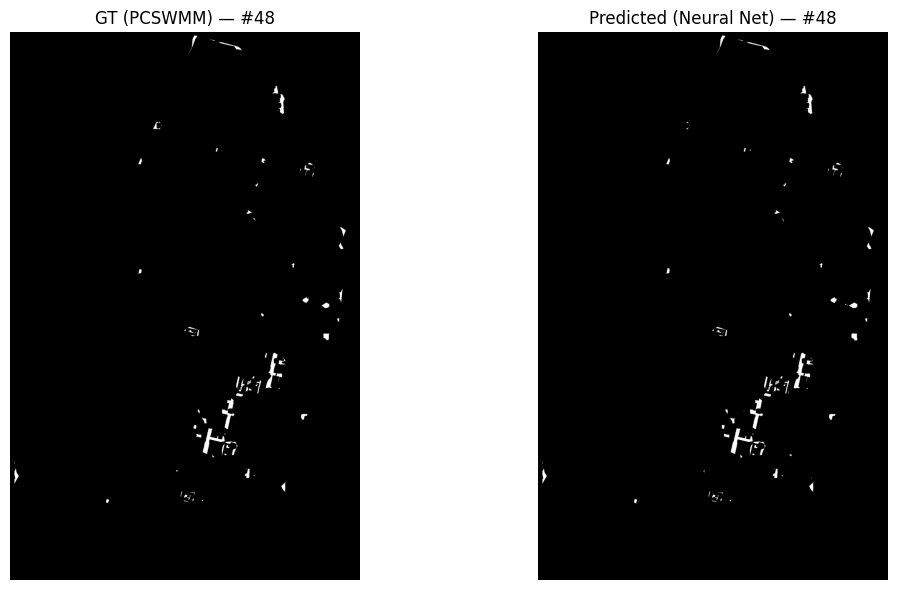

Processing Rainfall #49...


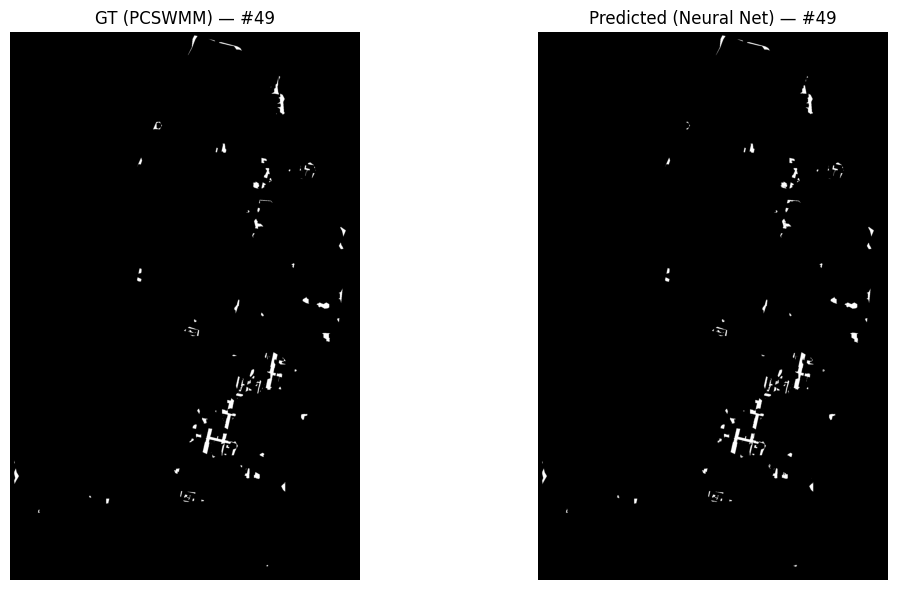

Processing Rainfall #50...


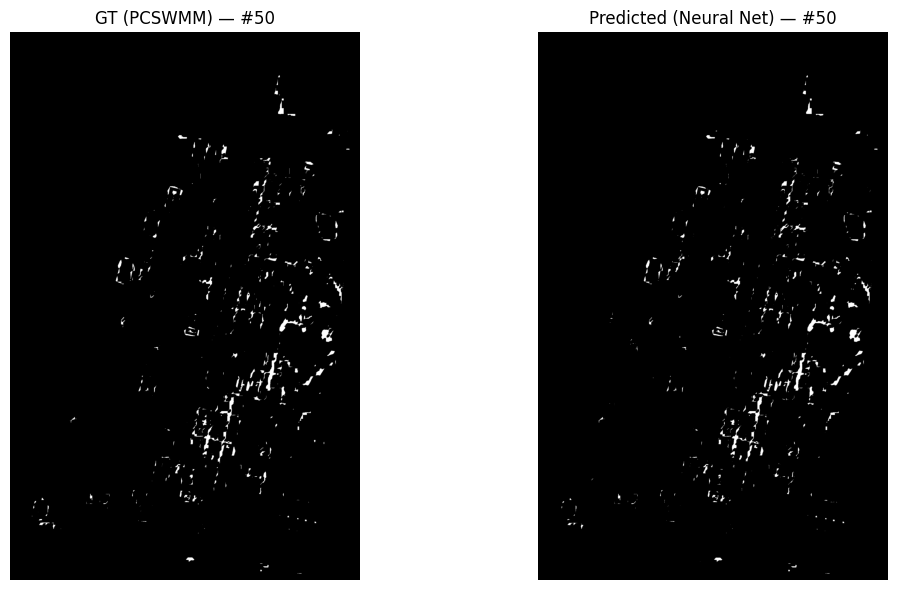

Processing Rainfall #51...


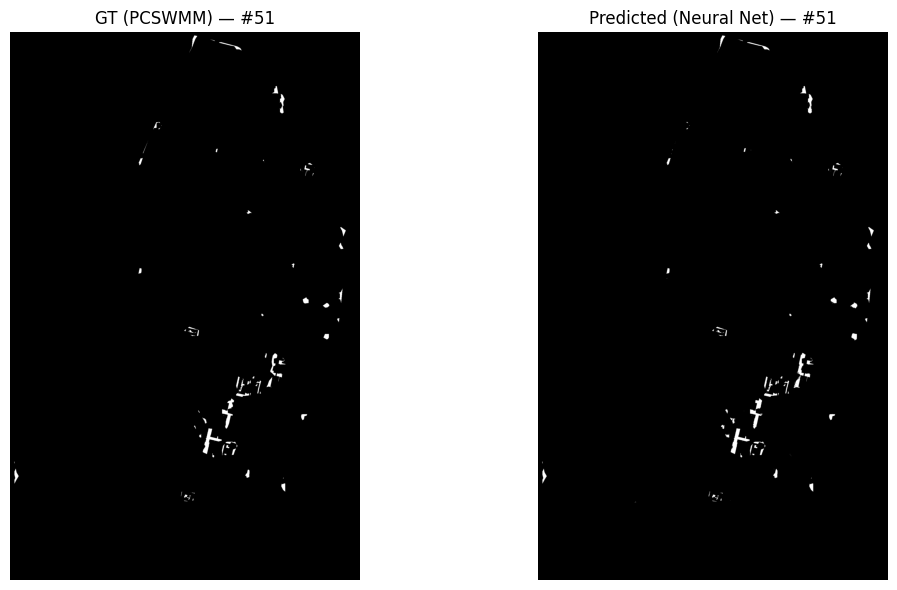

Processing Rainfall #52...


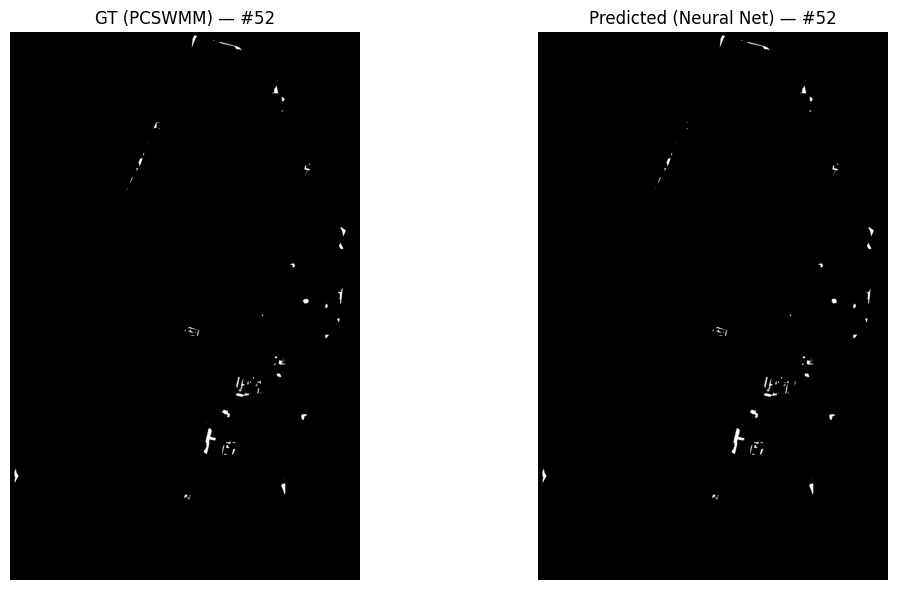

Processing Rainfall #53...


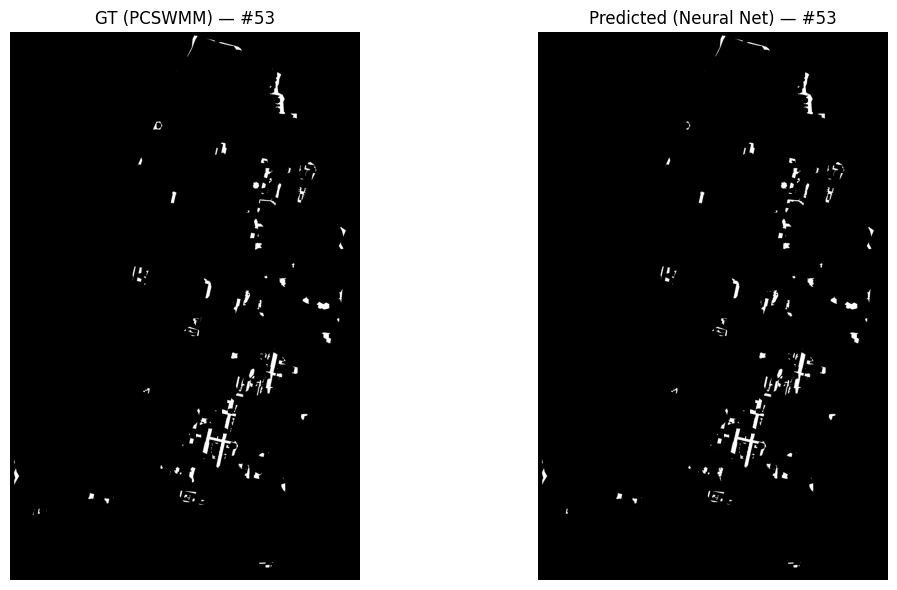

Processing Rainfall #54...


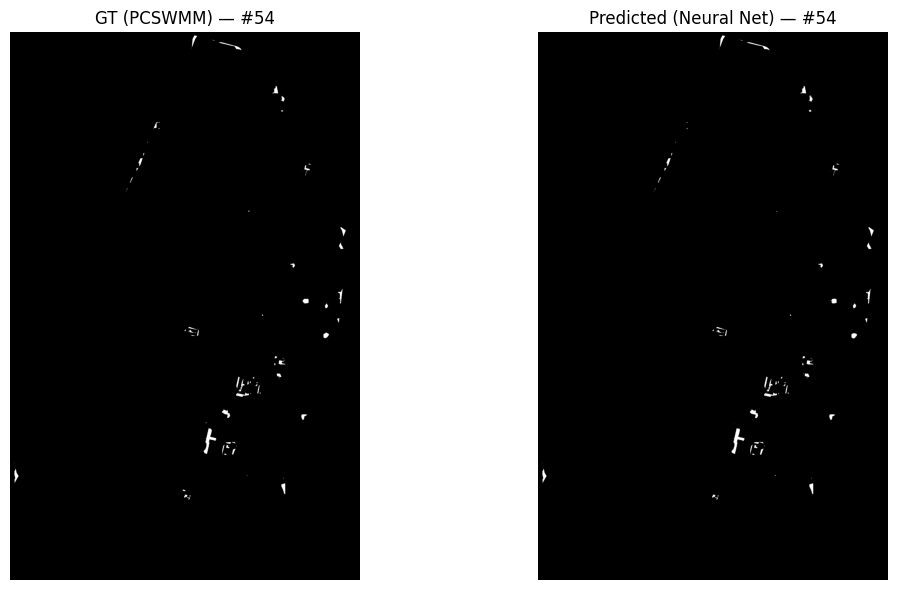

Processing Rainfall #55...


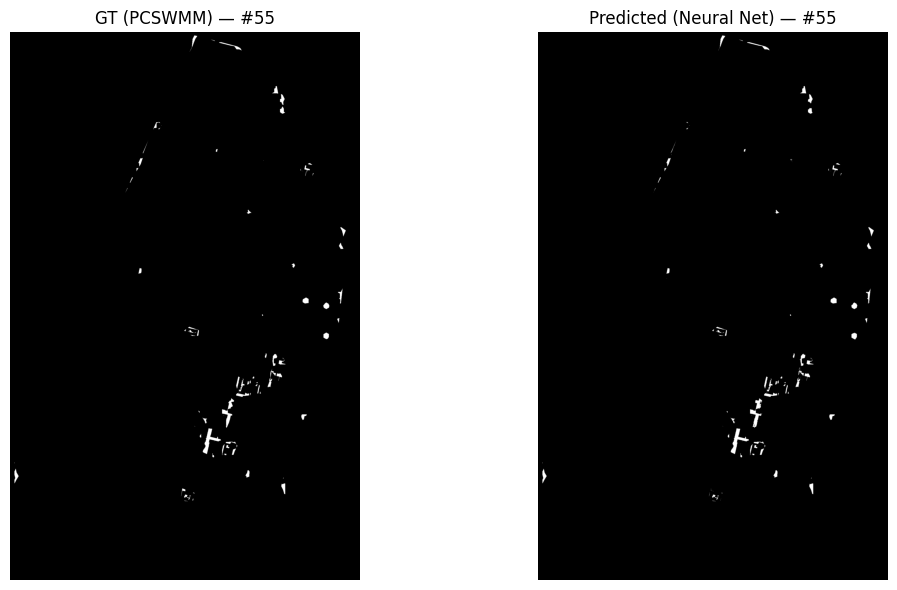

Processing Rainfall #56...


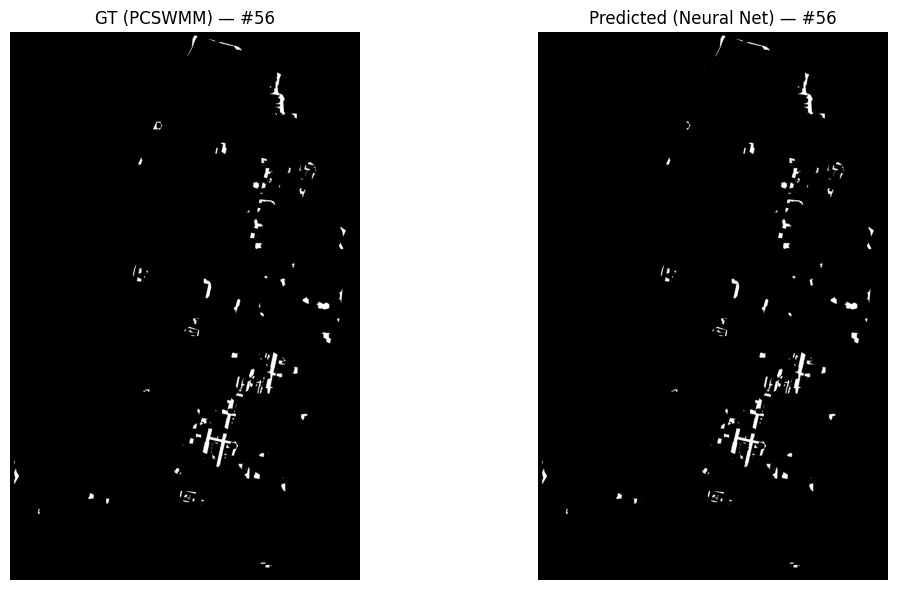

Processing Rainfall #57...


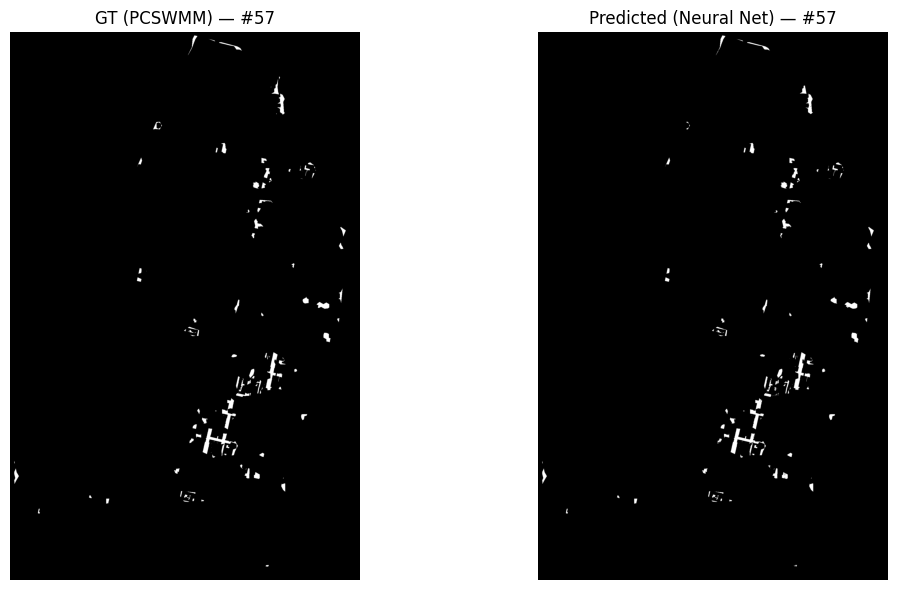

Processing Rainfall #58...


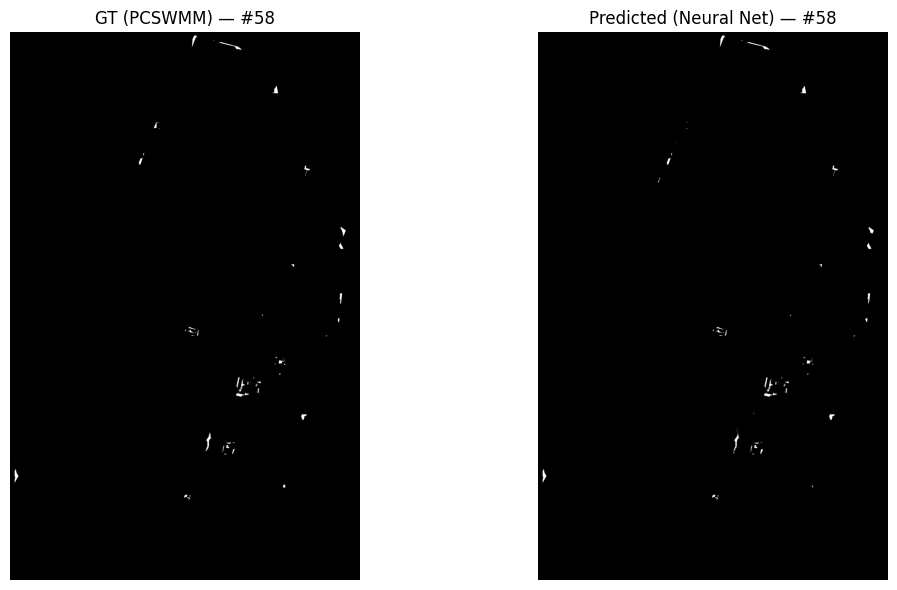

Processing Rainfall #59...


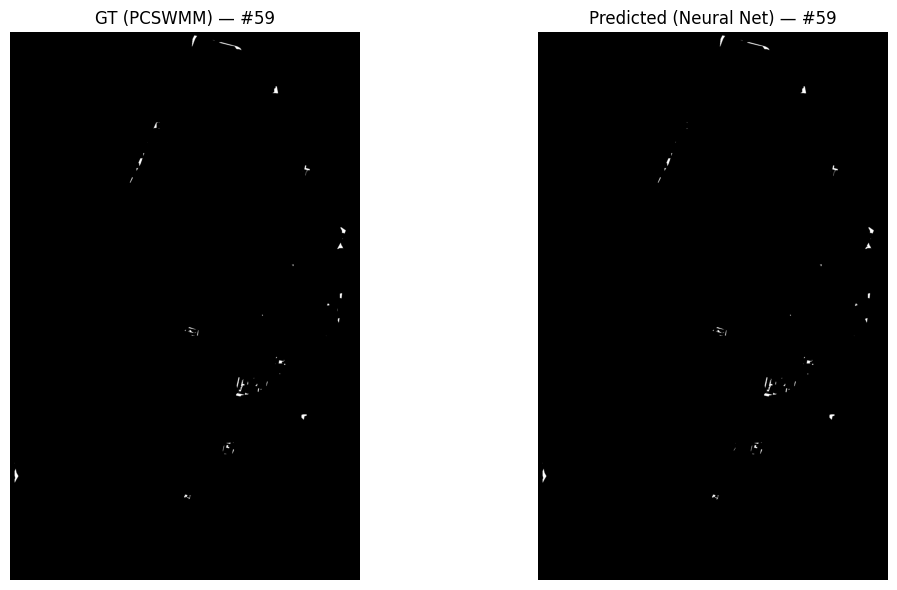

Processing Rainfall #60...


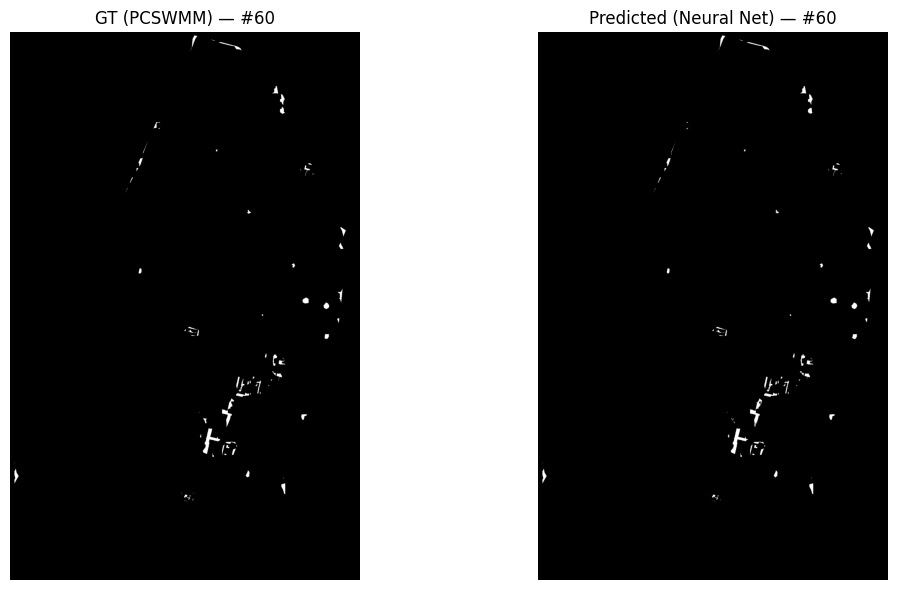

Processing Rainfall #61...


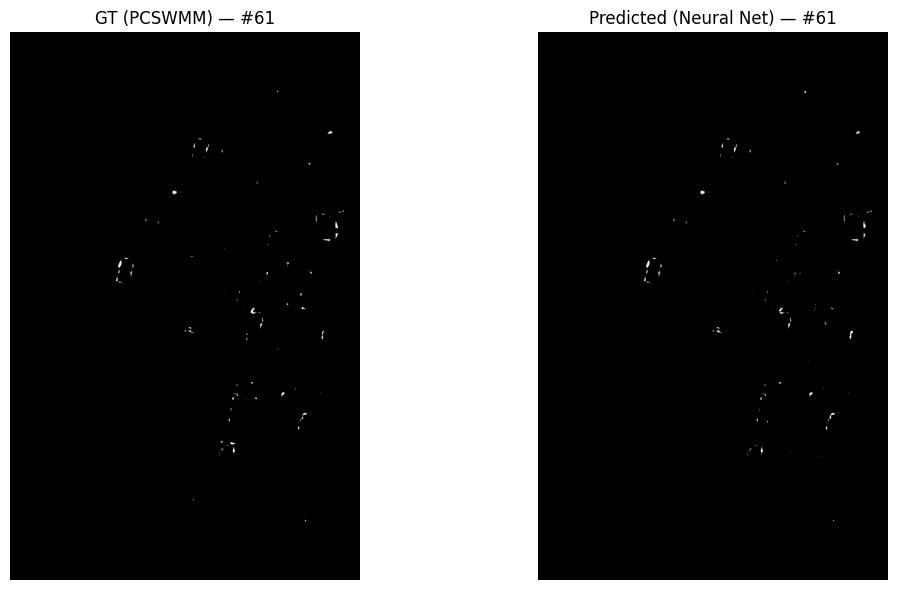

Processing Rainfall #62...


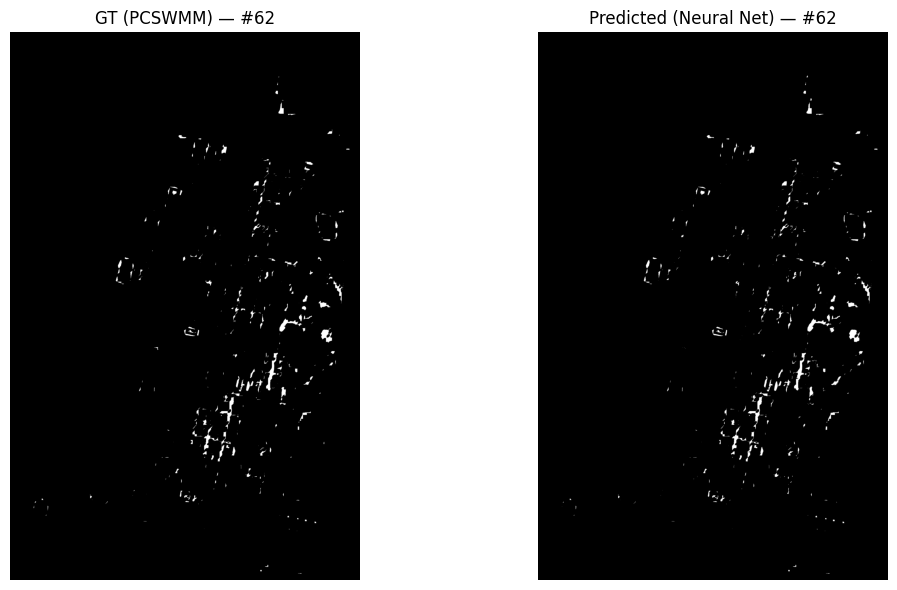

Processing Rainfall #63...


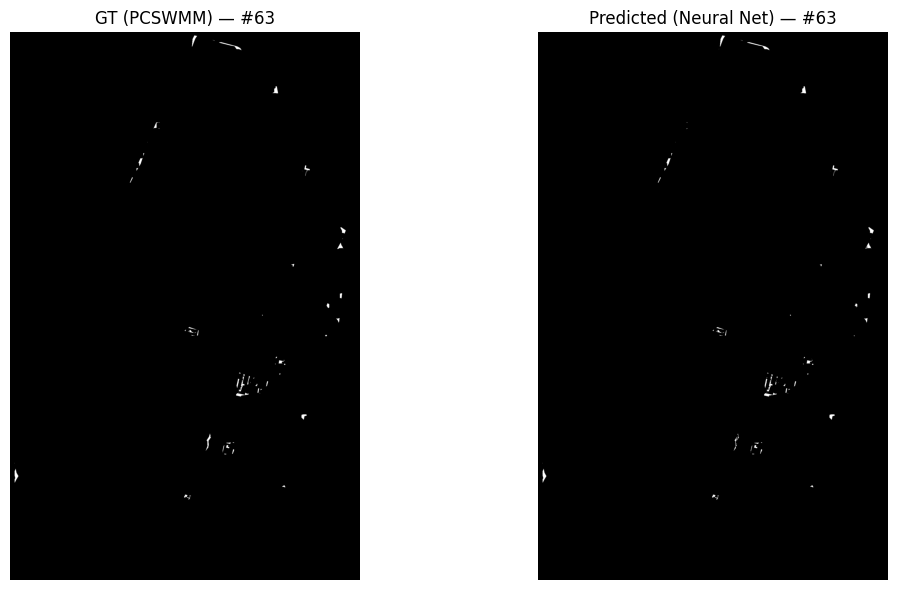

Processing Rainfall #64...


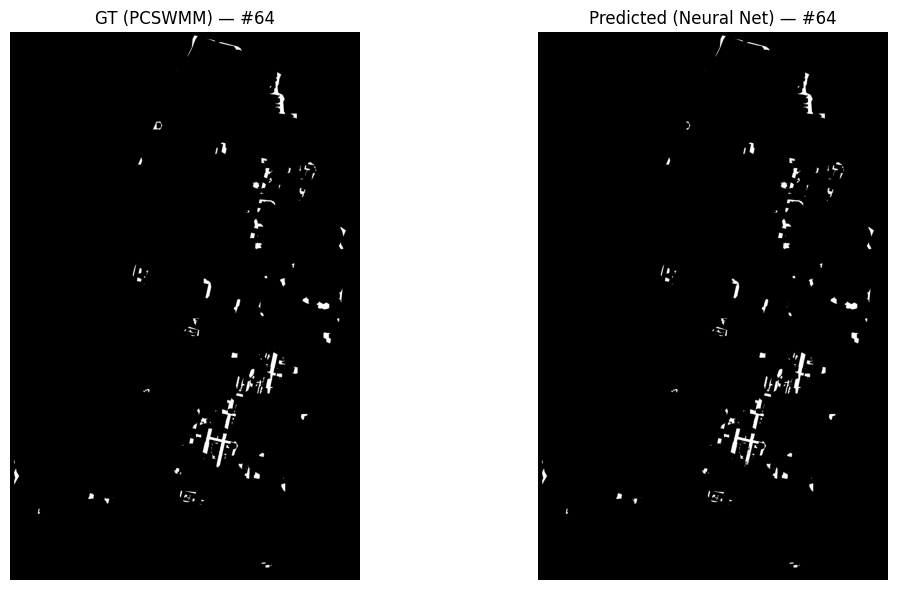

Processing Rainfall #65...


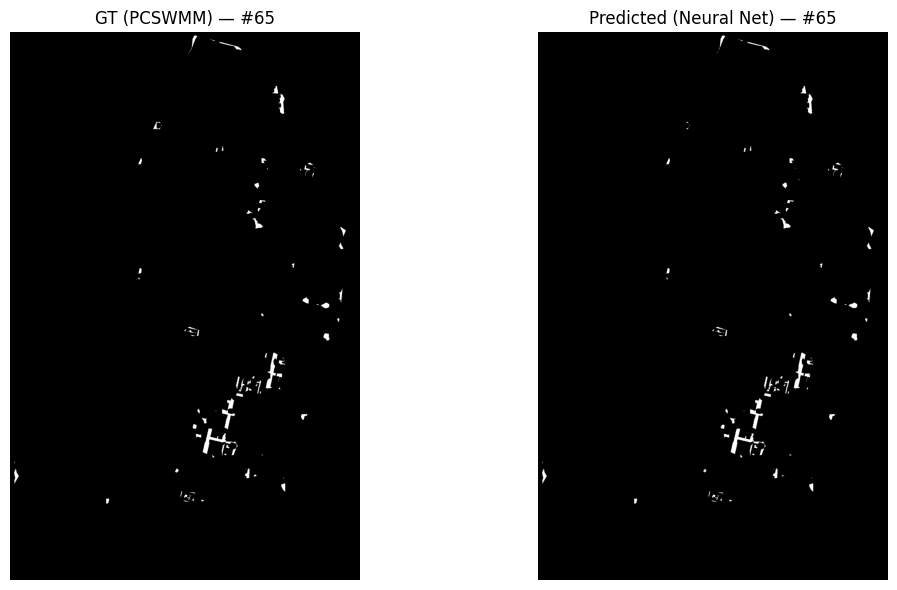

Processing Rainfall #66...


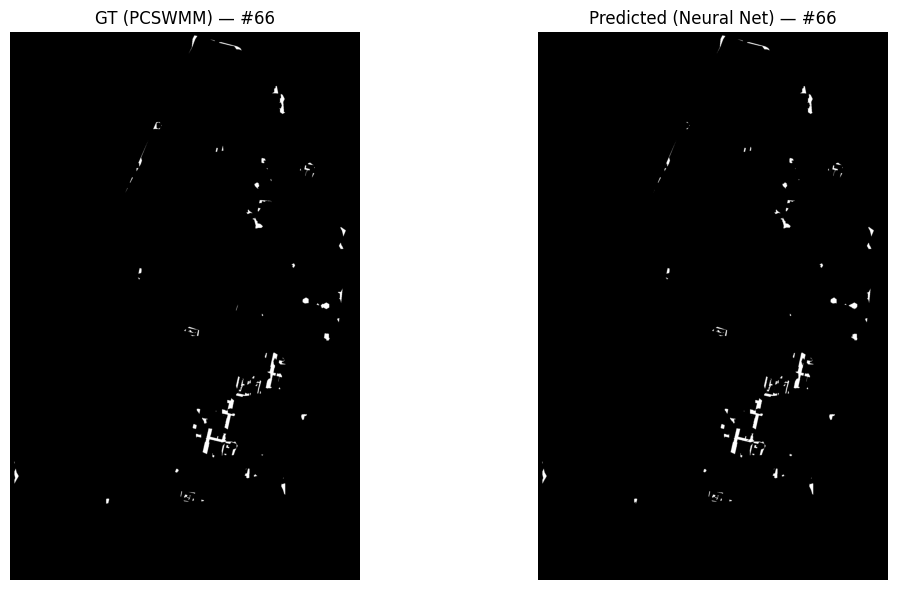

Processing Rainfall #67...


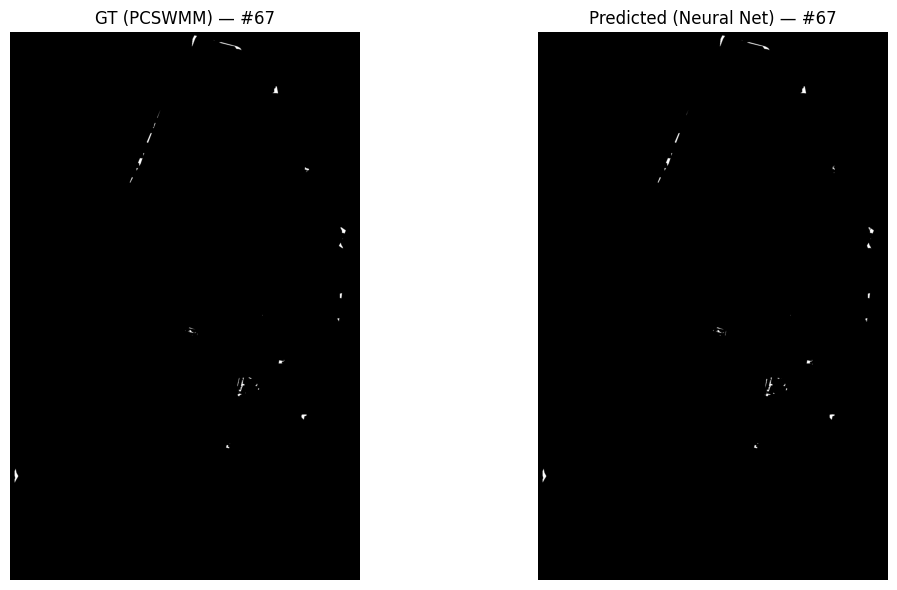

Processing Rainfall #68...


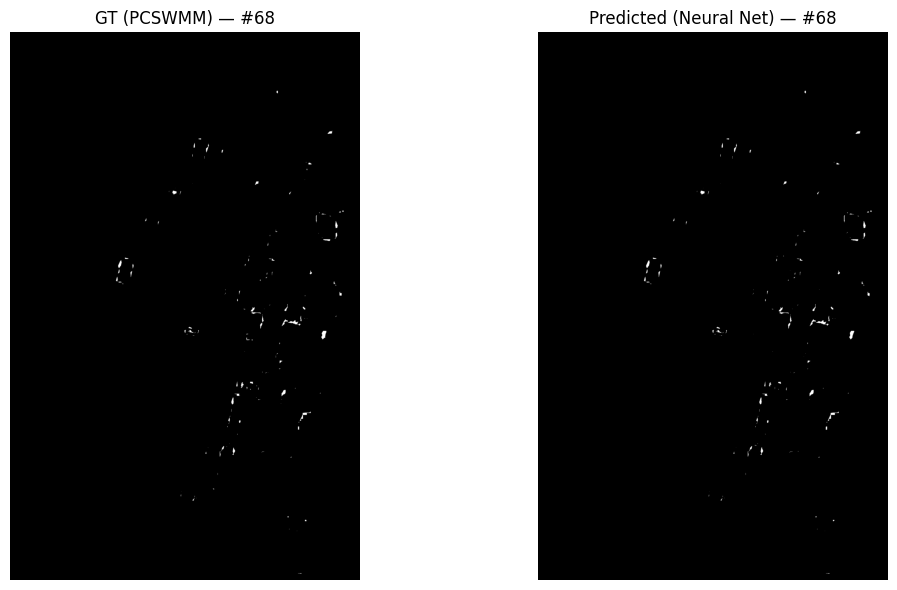

Processing Rainfall #69...


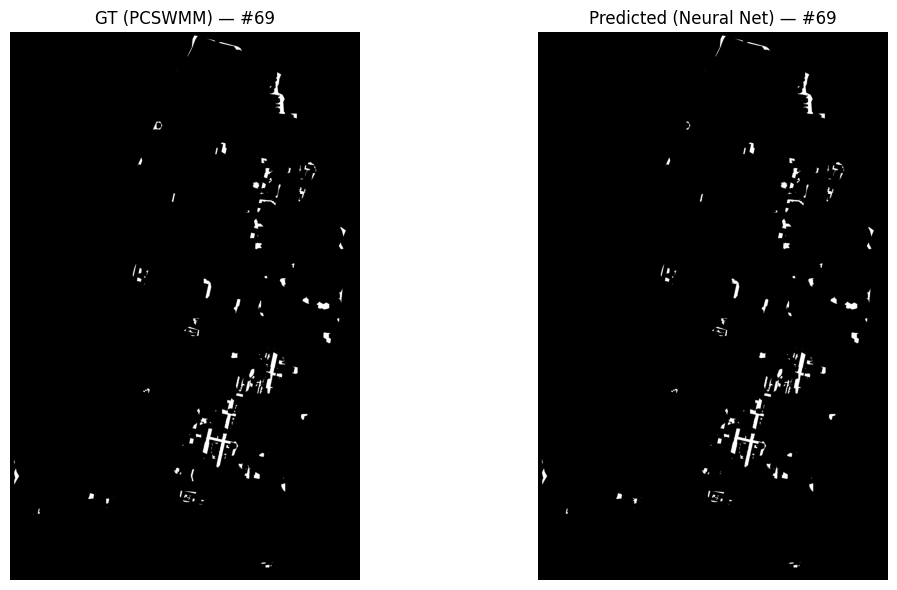

Processing Rainfall #70...


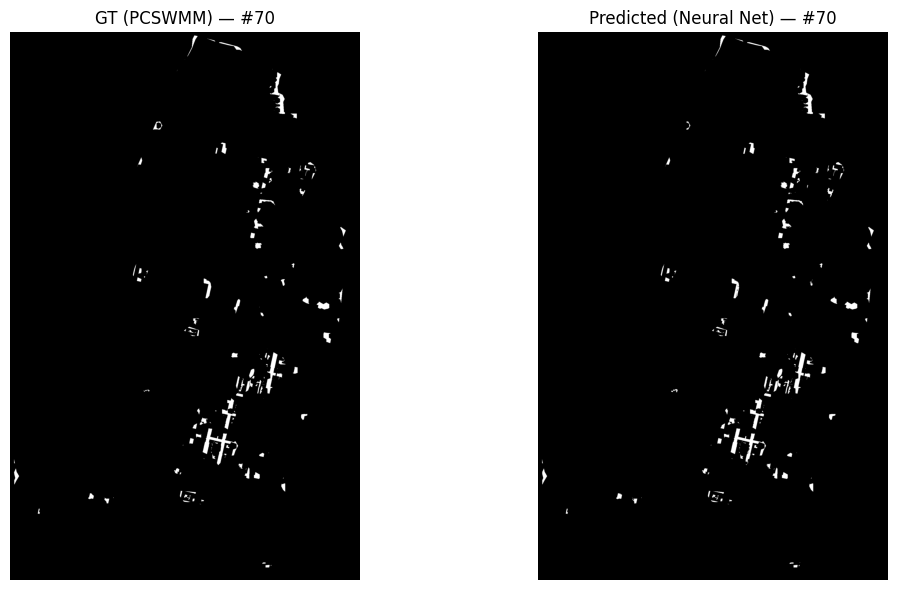

Processing Rainfall #71...


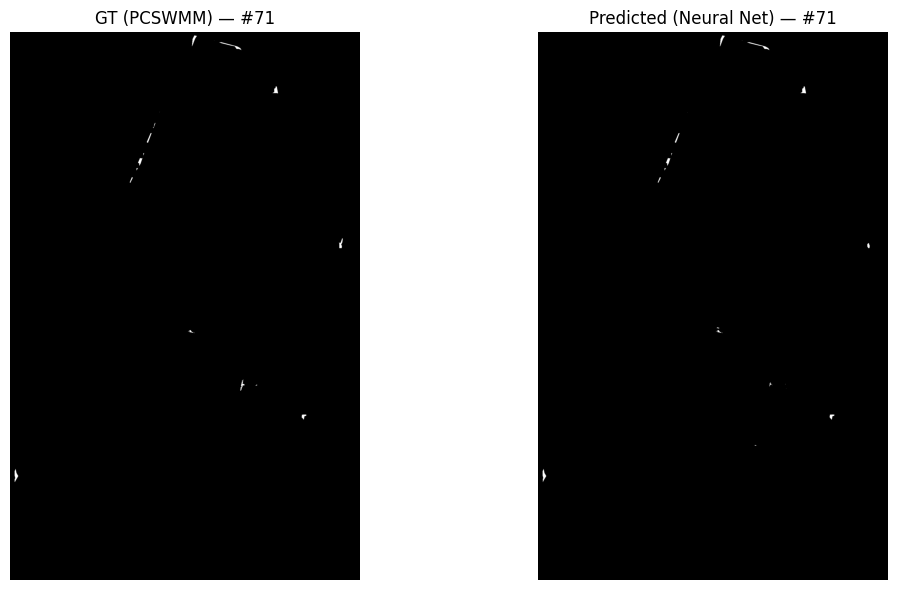

Processing Rainfall #72...


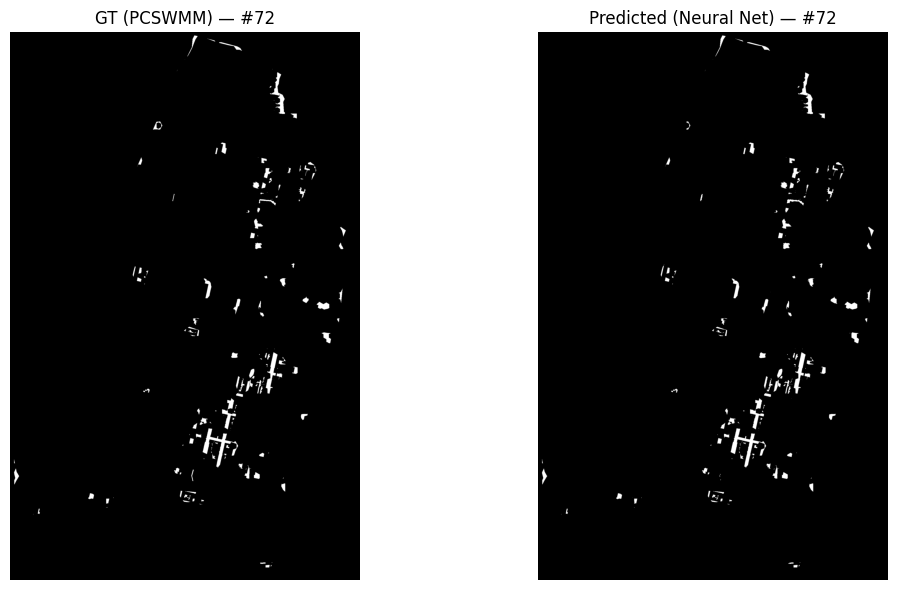

Processing Rainfall #73...


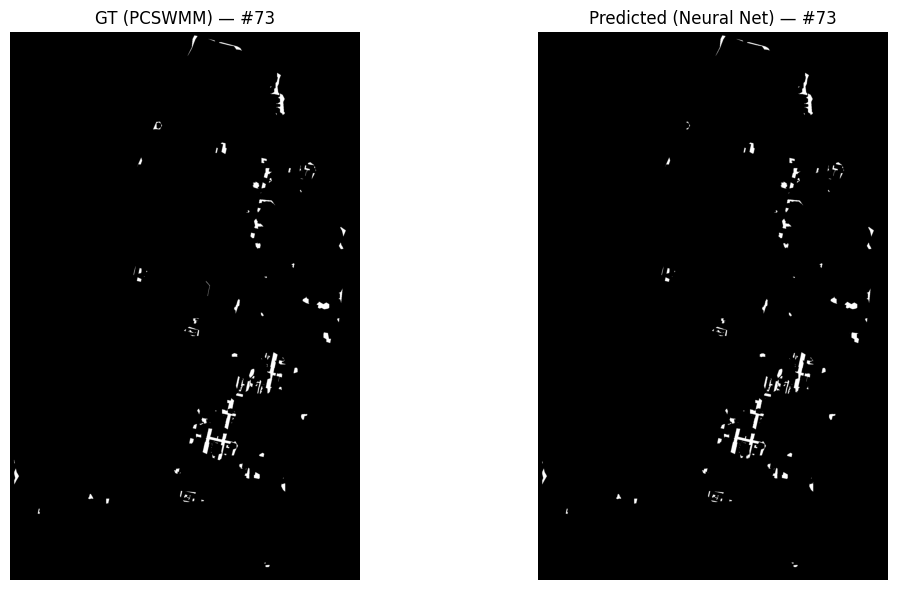

Processing Rainfall #74...


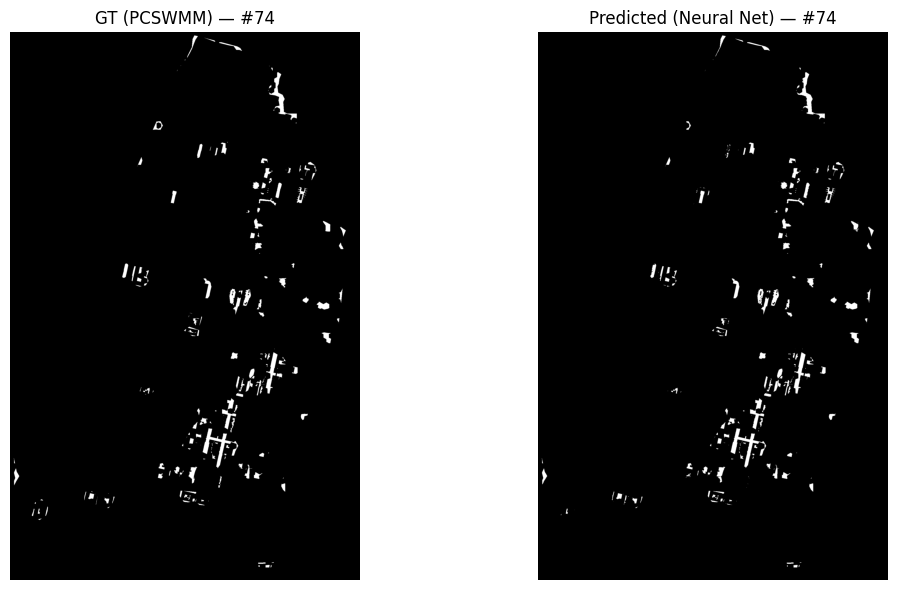

Processing Rainfall #75...


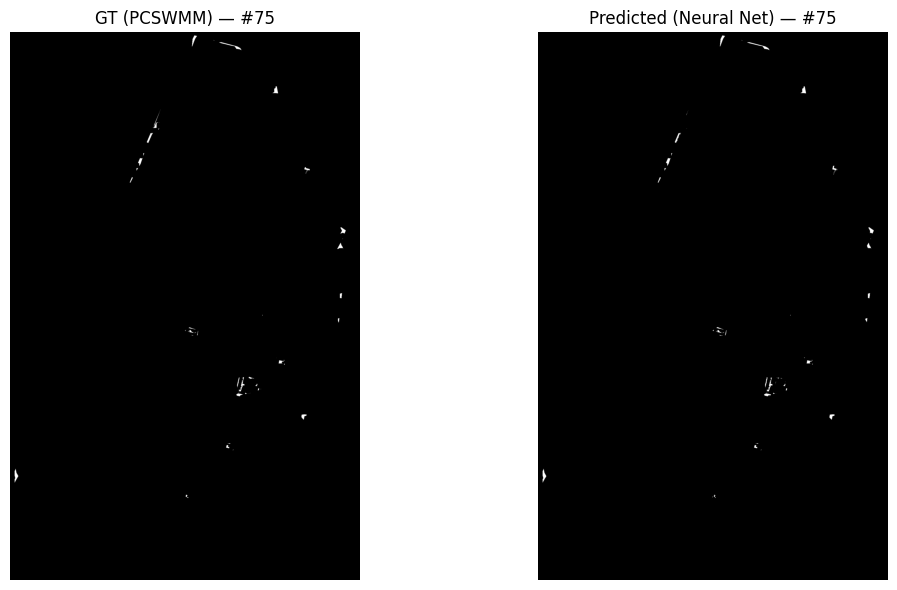

Processing Rainfall #76...


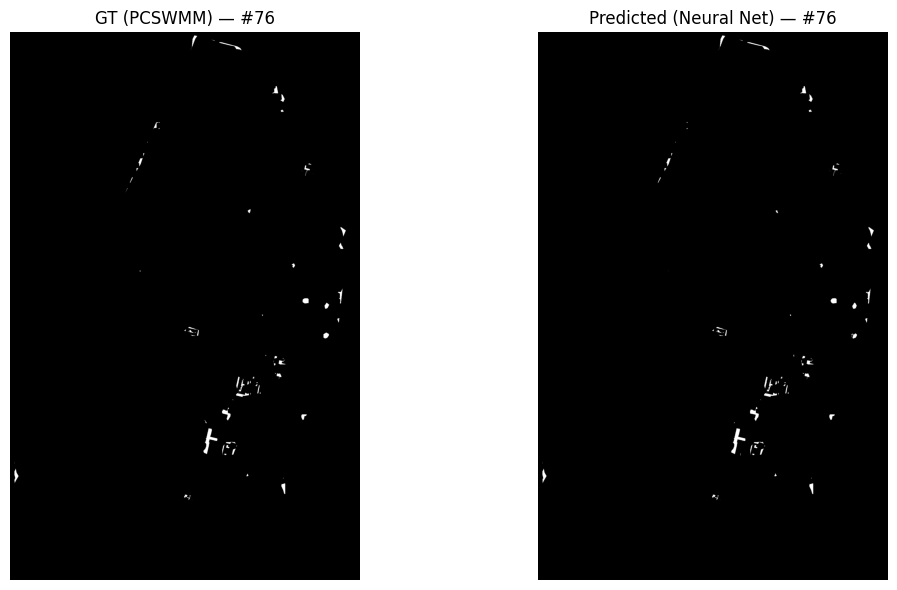

Processing Rainfall #77...


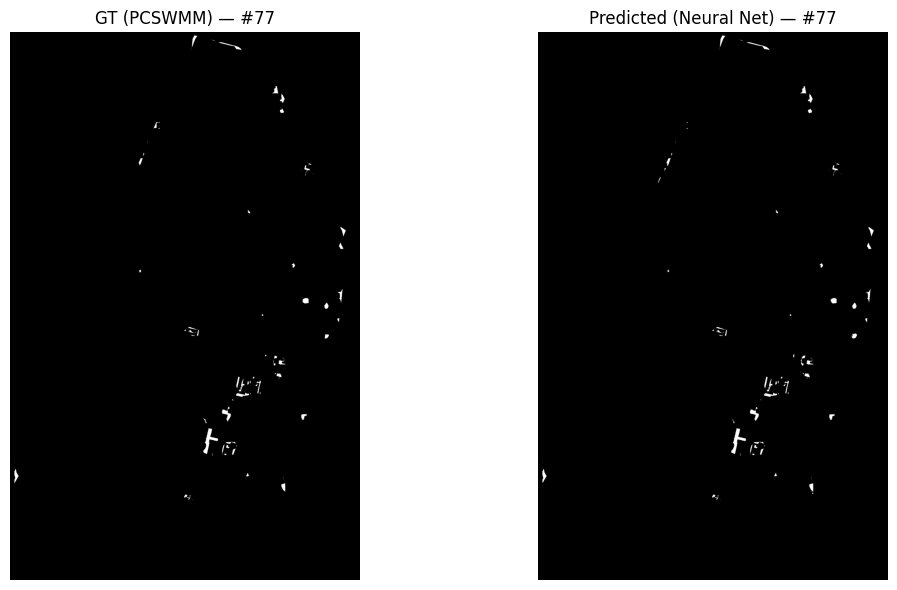

Processing Rainfall #78...


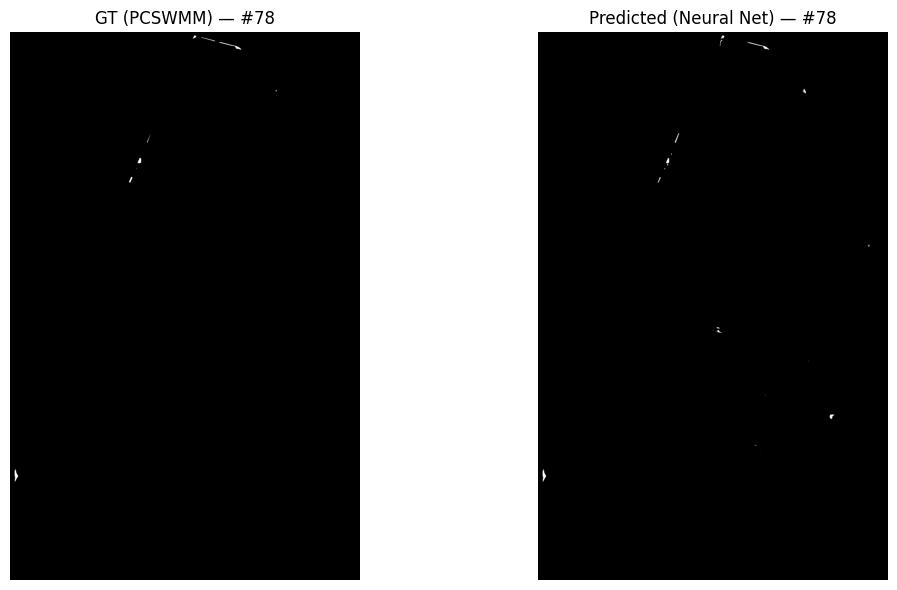

Processing Rainfall #79...


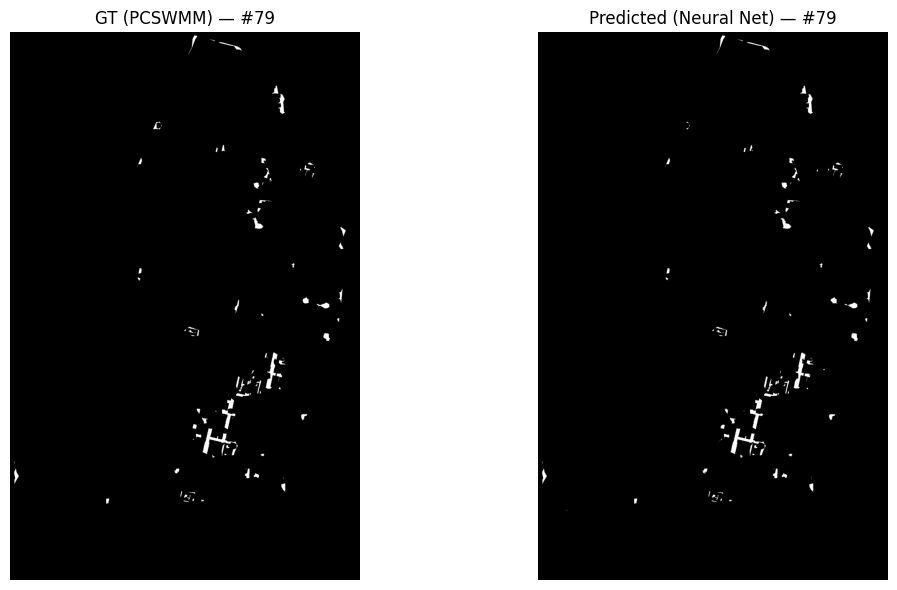

Processing Rainfall #80...


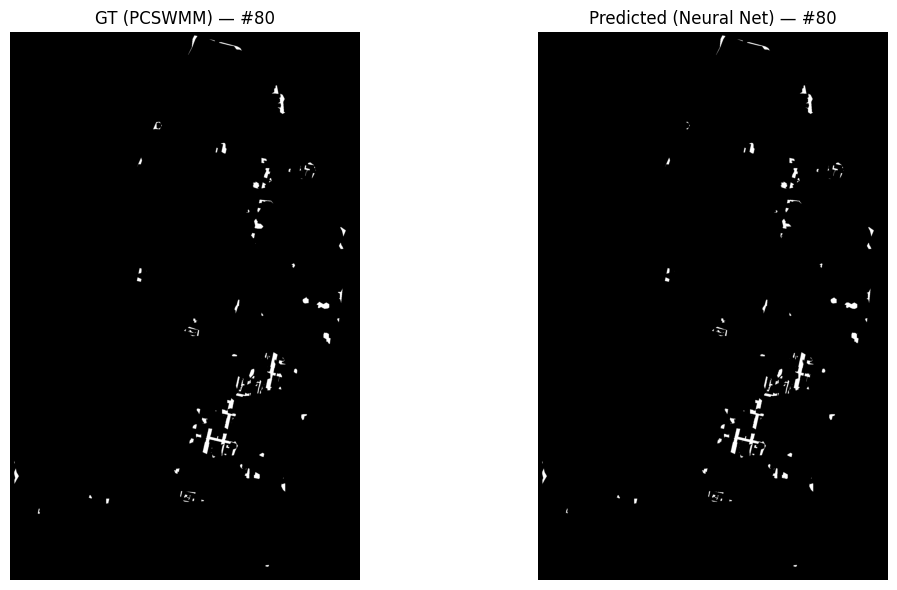

Processing Rainfall #81...


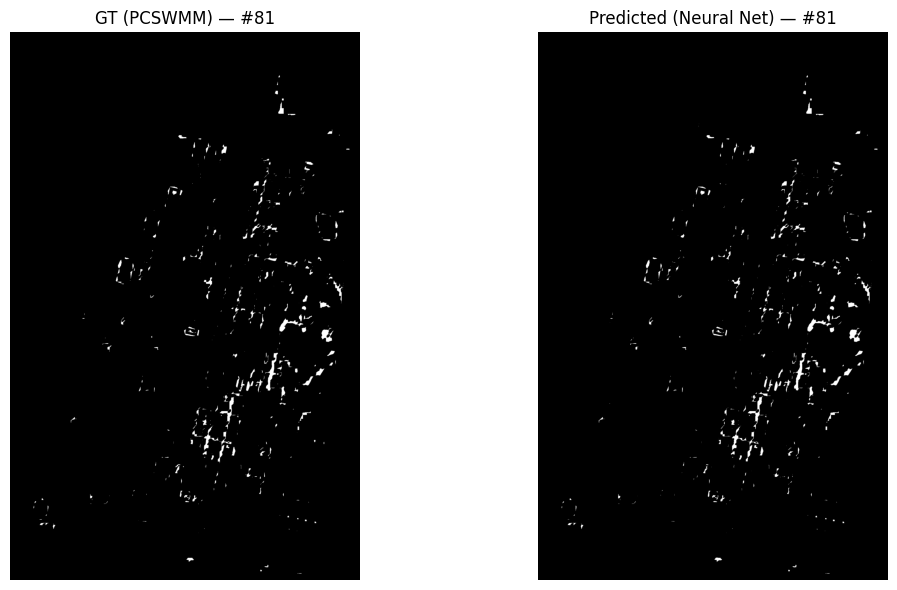

Processing Rainfall #82...


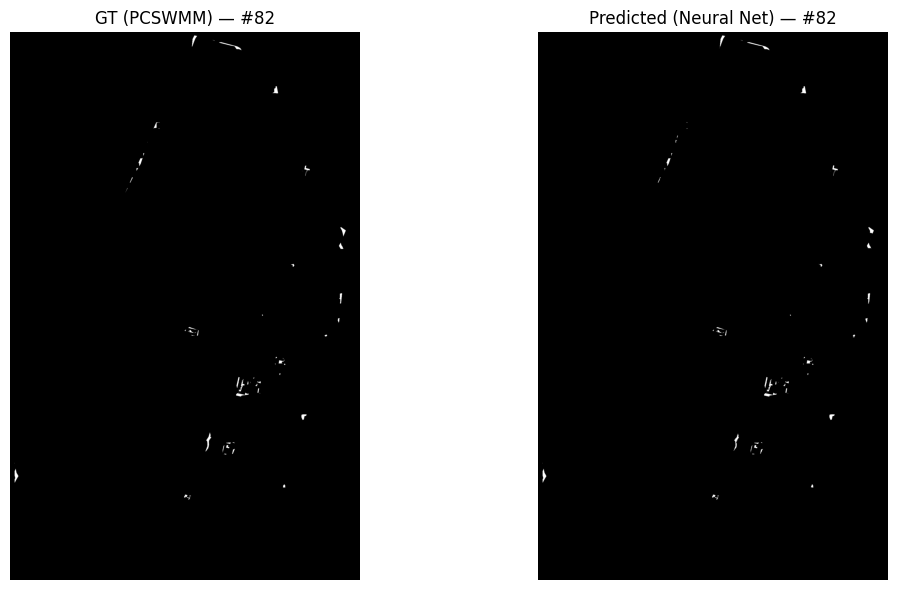

Processing Rainfall #83...


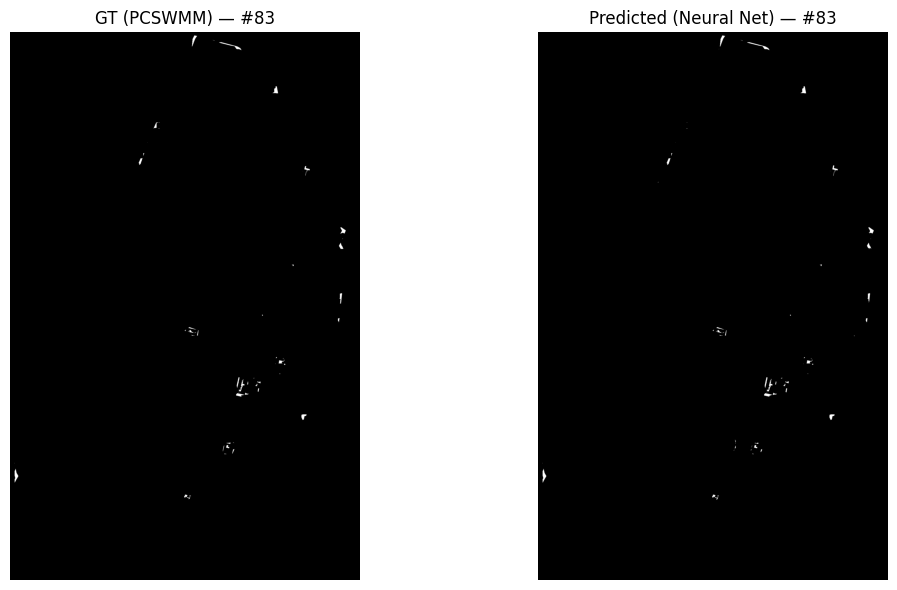

Processing Rainfall #84...


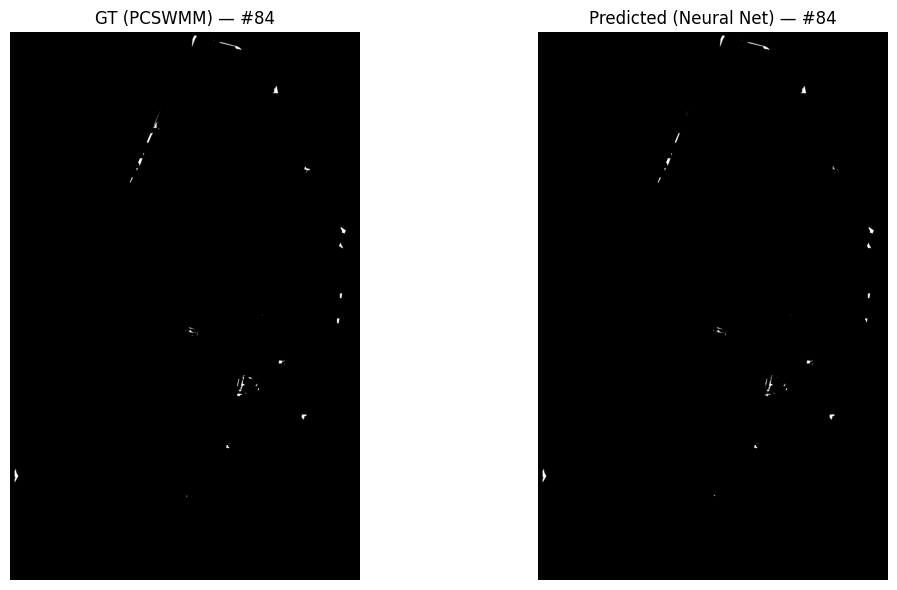

Processing Rainfall #85...


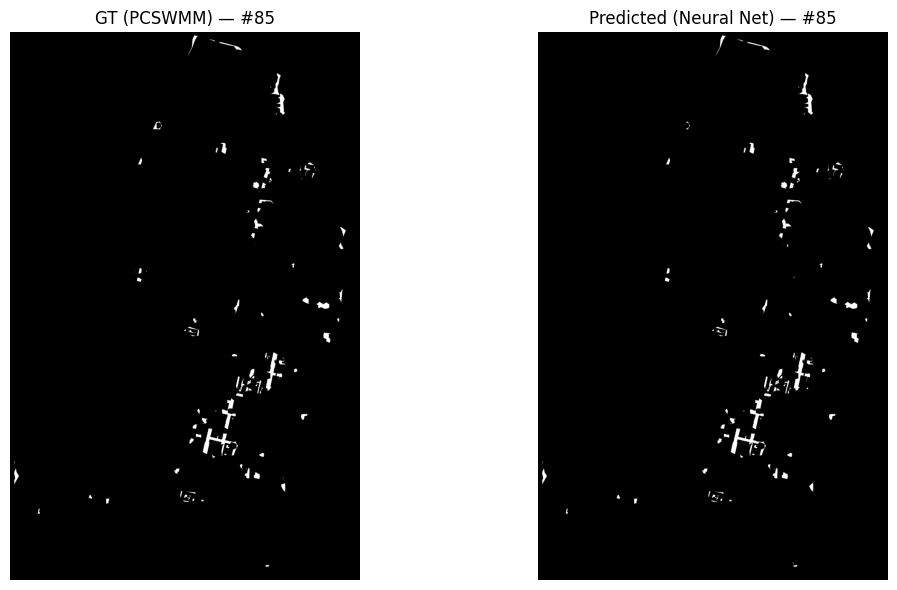

Processing Rainfall #86...


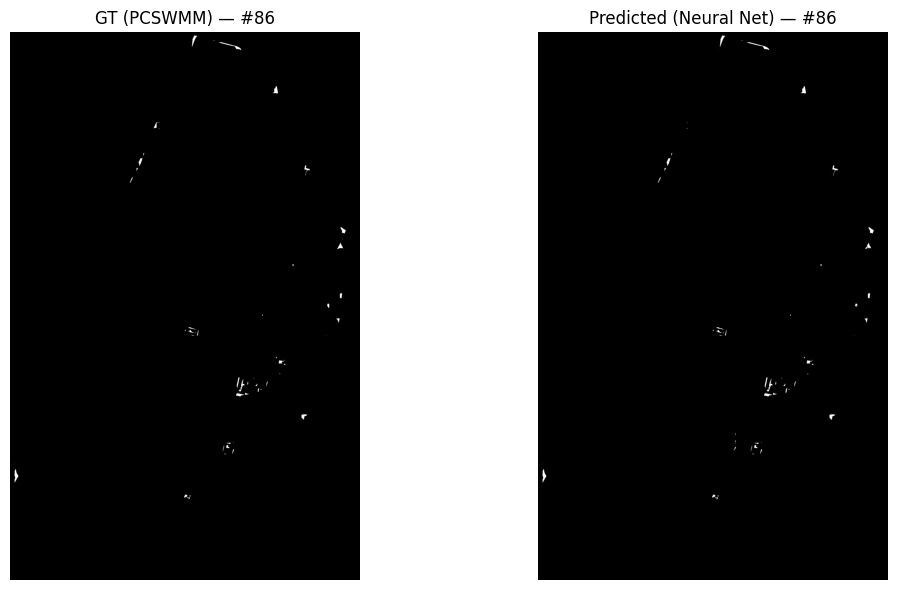

Processing Rainfall #87...


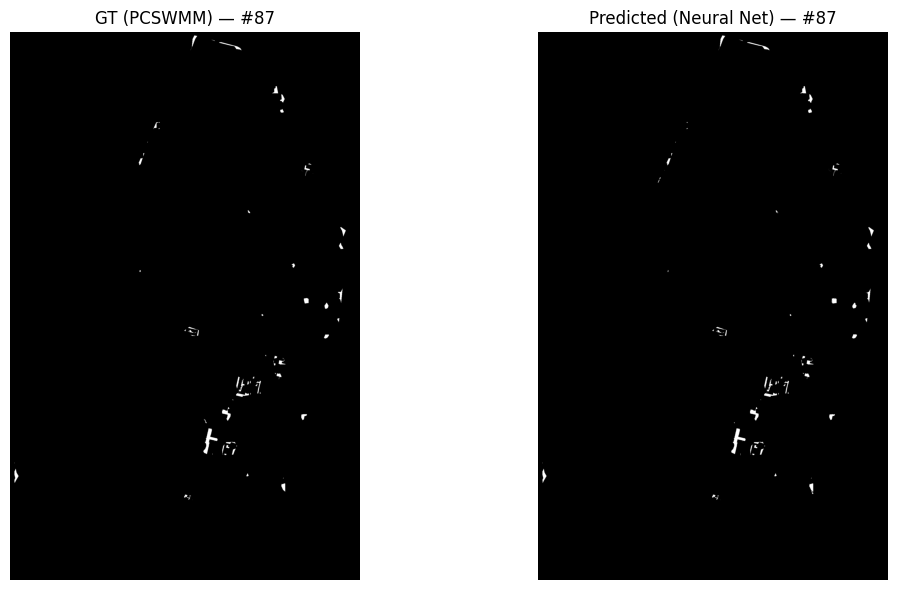

Processing Rainfall #88...


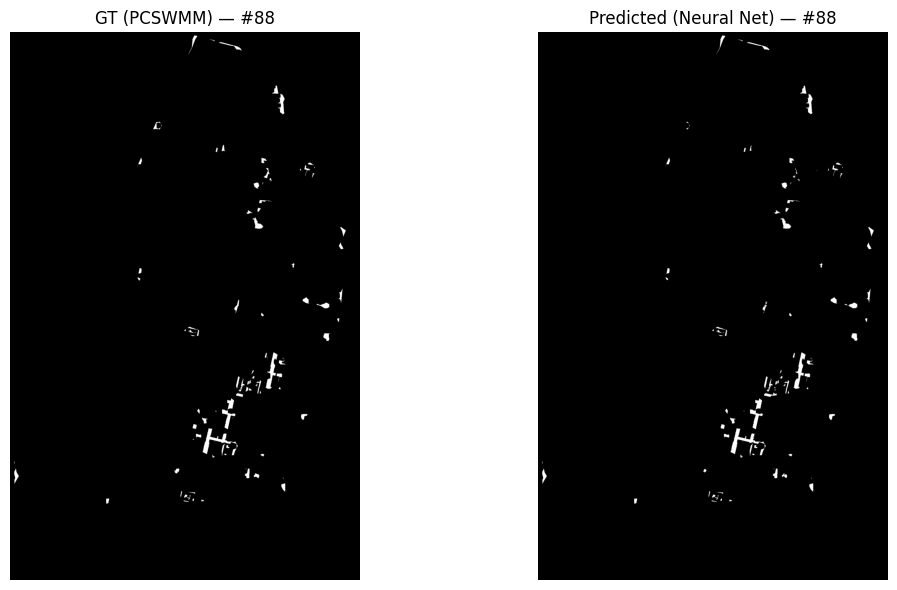

Processing Rainfall #89...


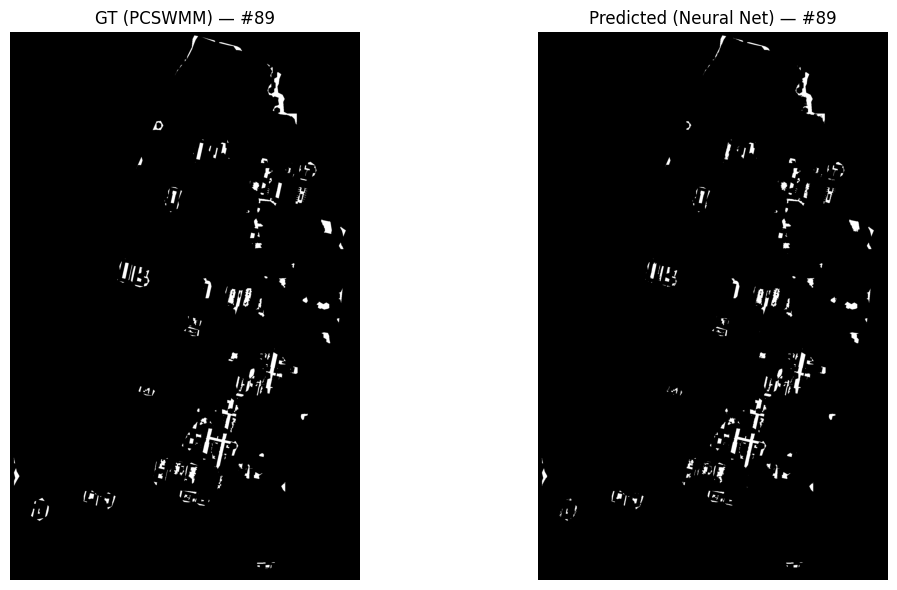

Processing Rainfall #90...


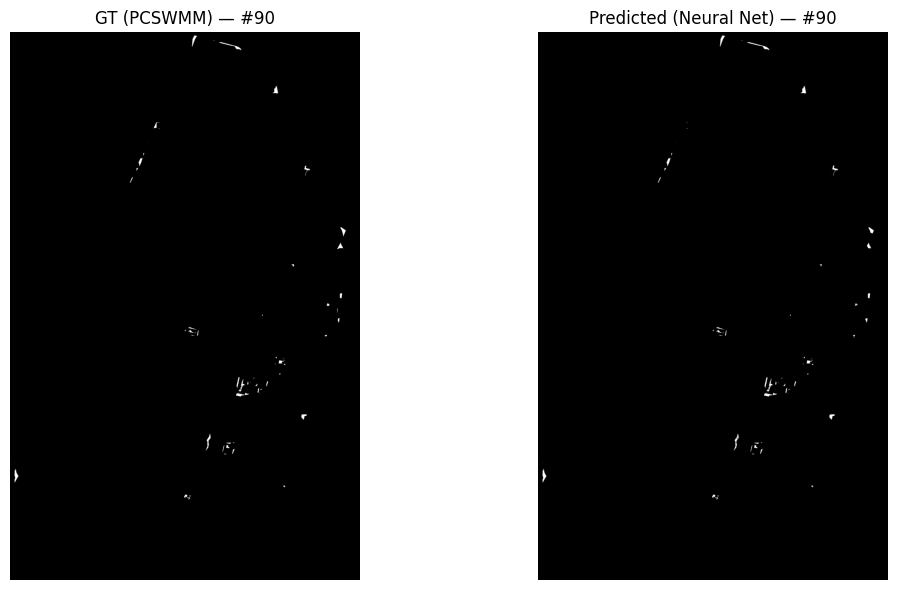

Processing Rainfall #91...


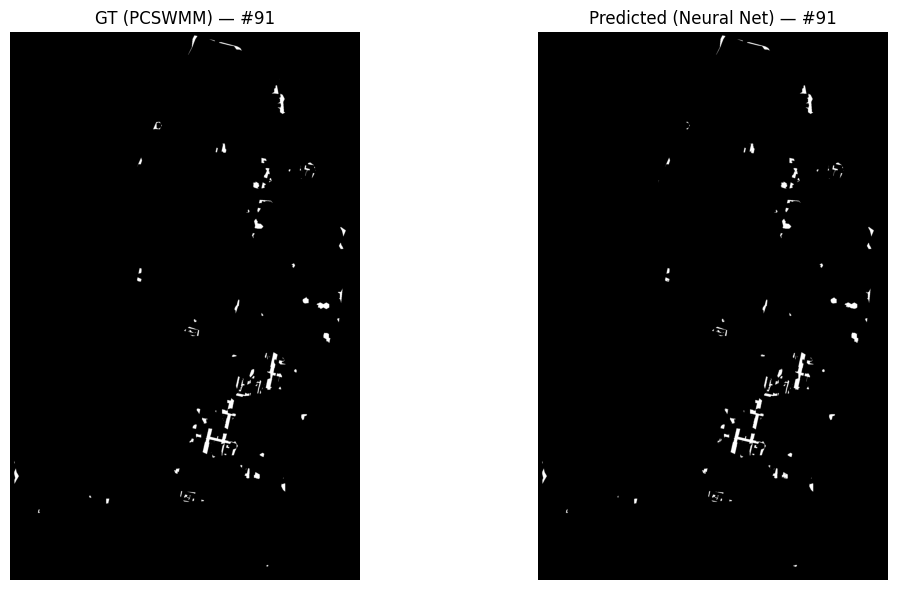

Processing Rainfall #92...


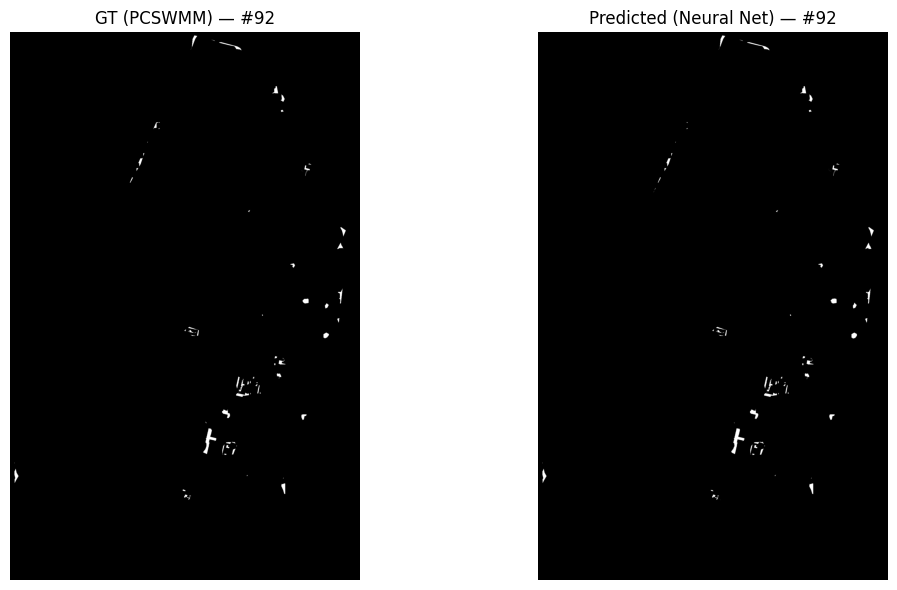

Processing Rainfall #93...


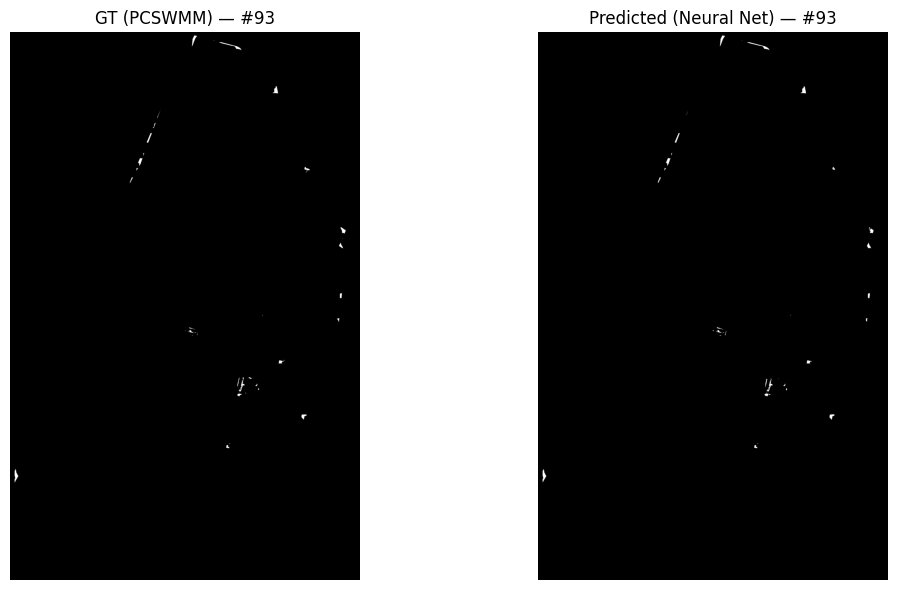

Processing Rainfall #94...


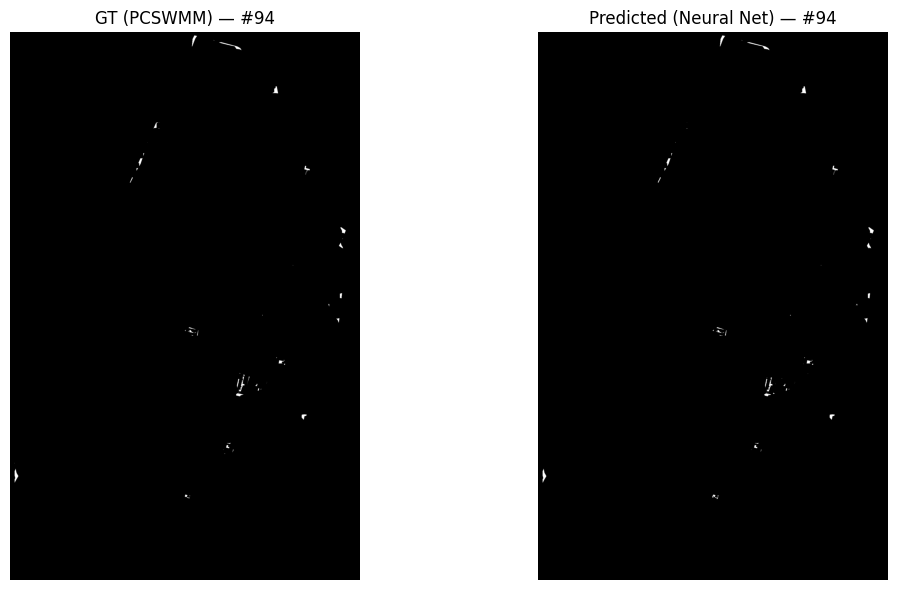

Processing Rainfall #95...


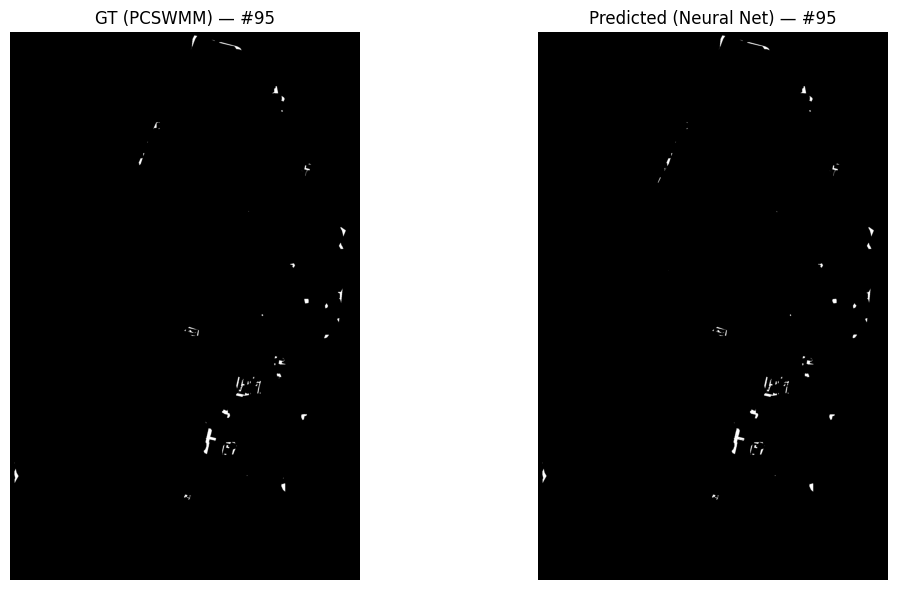

Processing Rainfall #96...


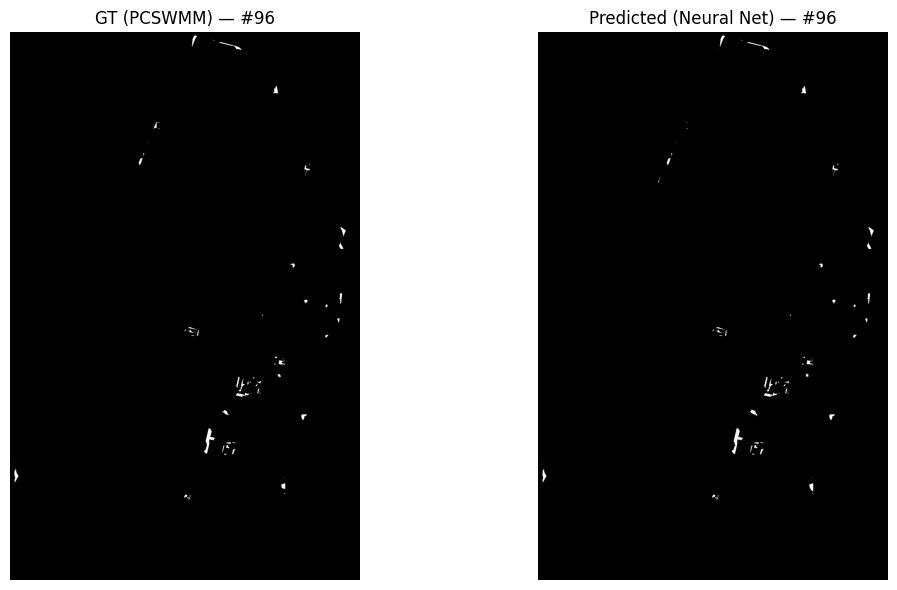

Processing Rainfall #97...


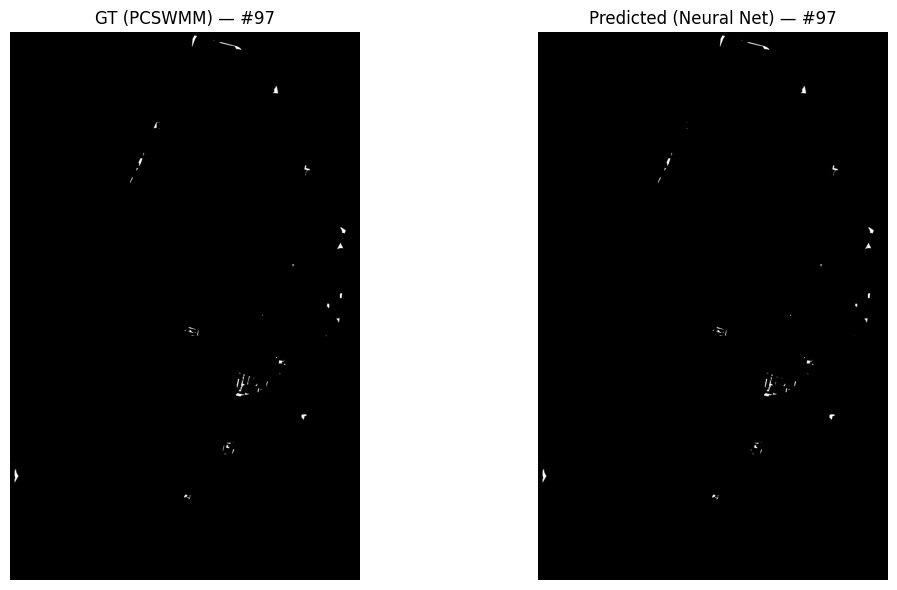

Processing Rainfall #98...


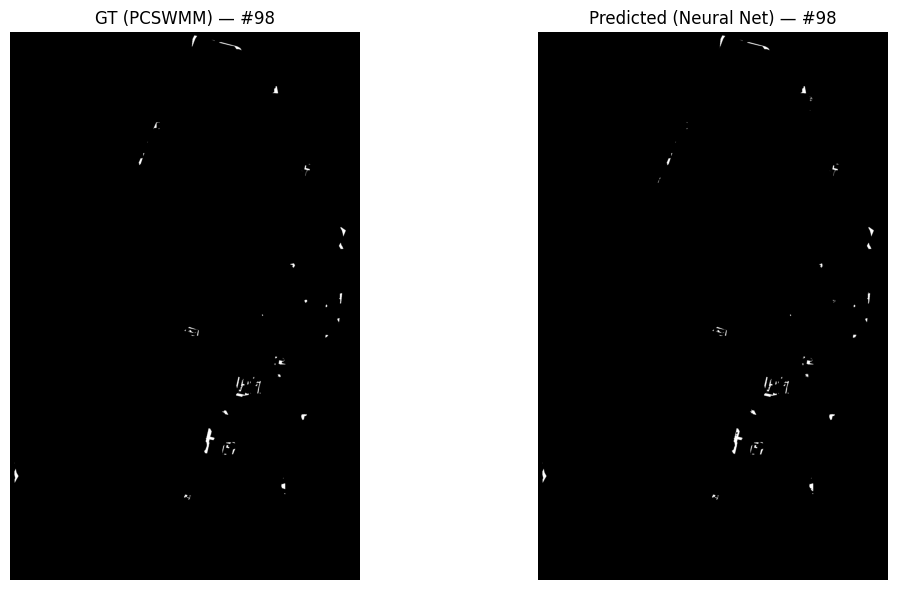

Processing Rainfall #99...


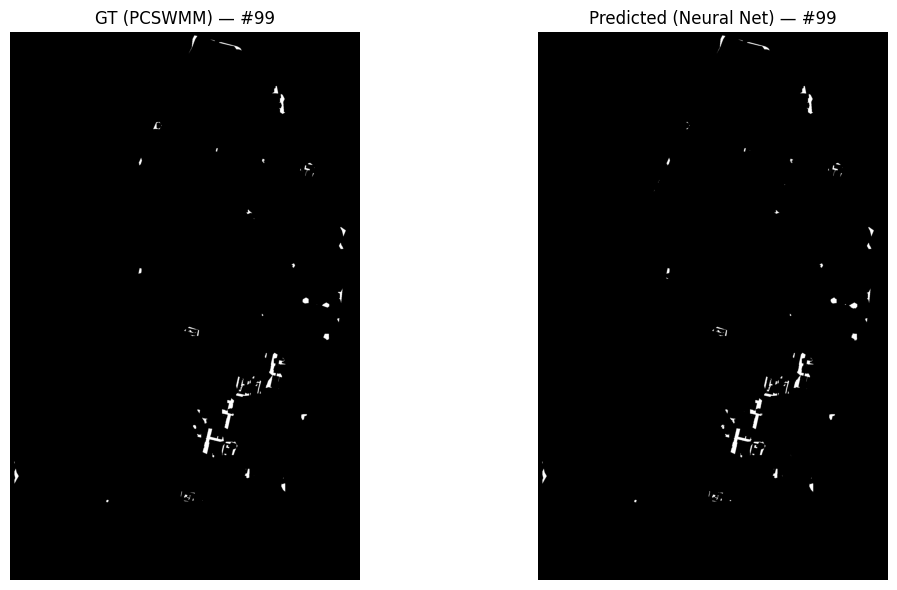

Processing Rainfall #100...


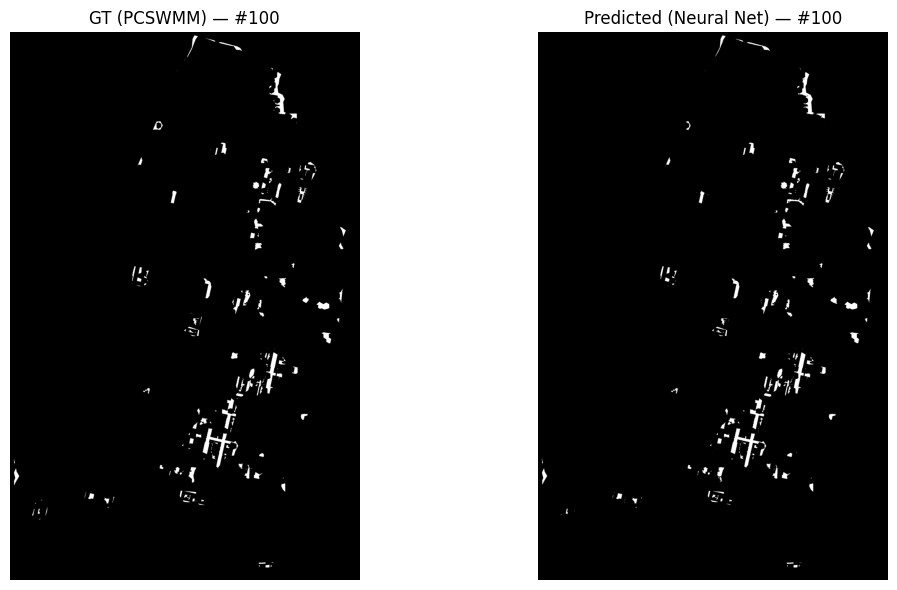

Processing Rainfall #101...


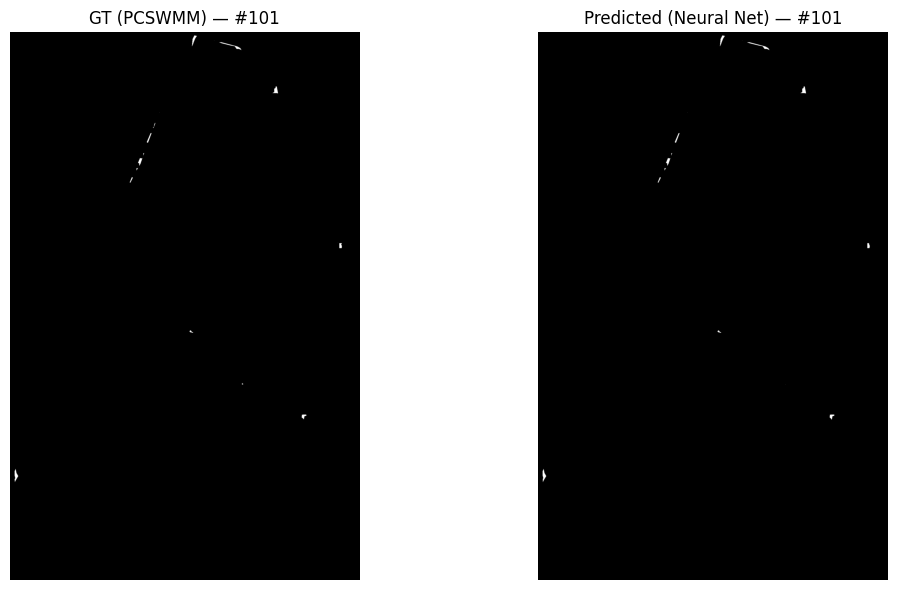

Processing Rainfall #102...


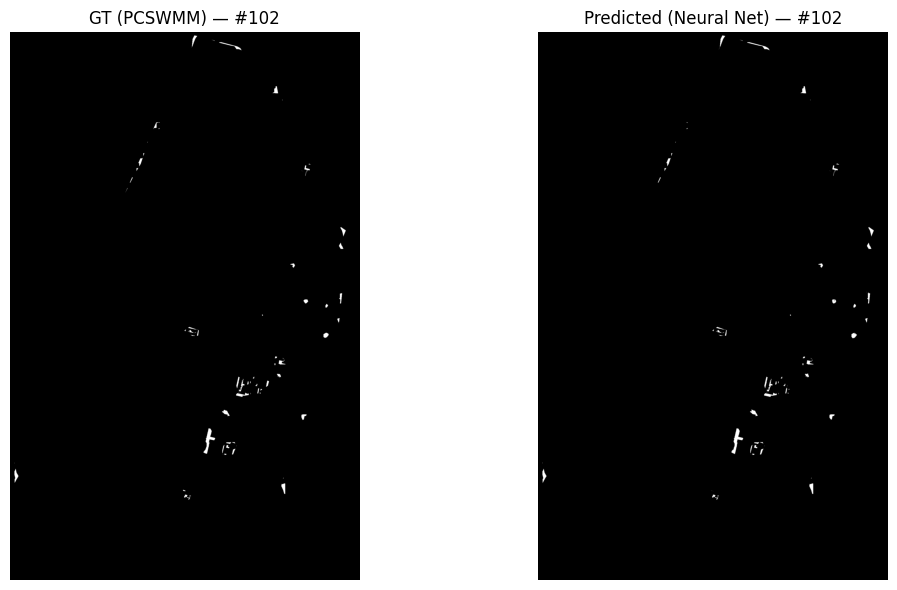

Processing Rainfall #103...


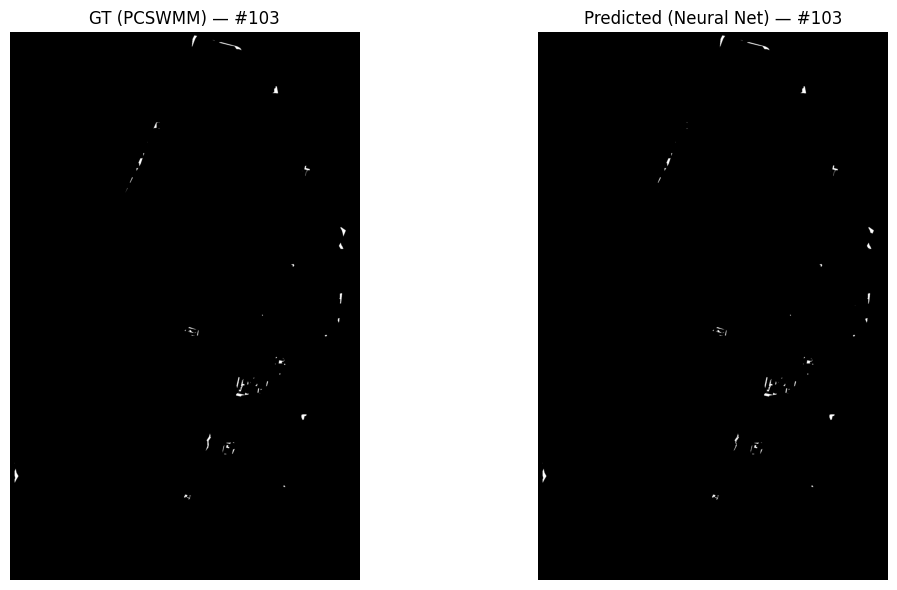

Processing Rainfall #104...


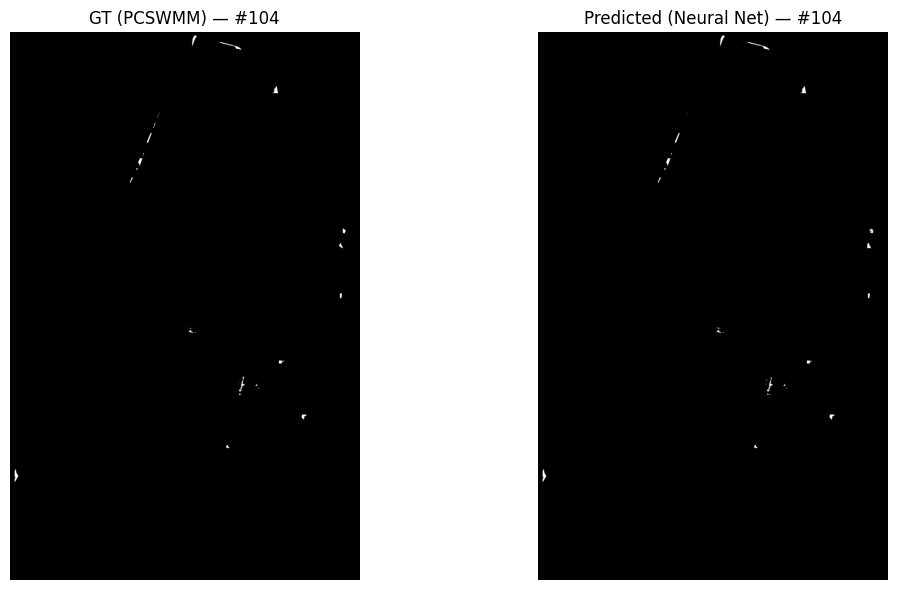

Processing Rainfall #105...


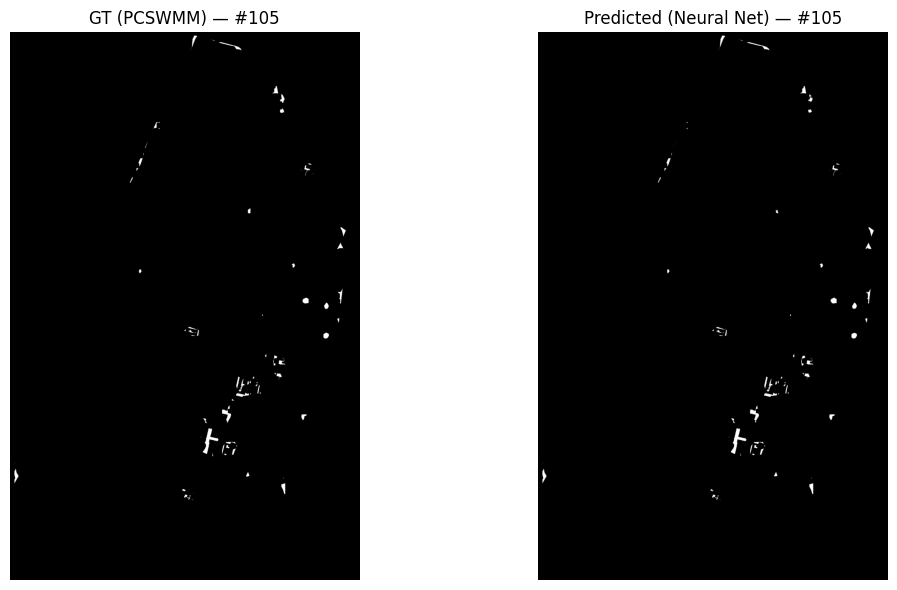

Processing Rainfall #106...


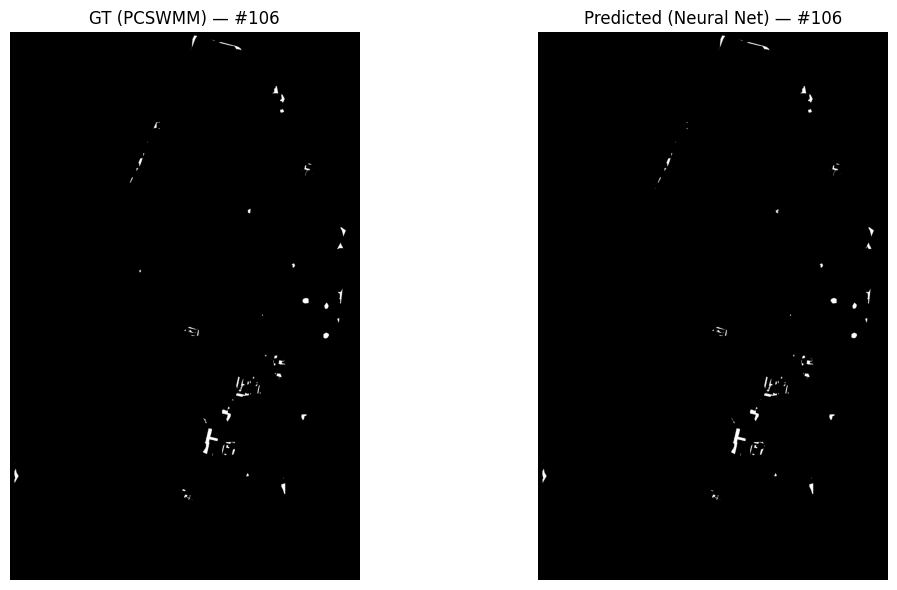

Processing Rainfall #107...


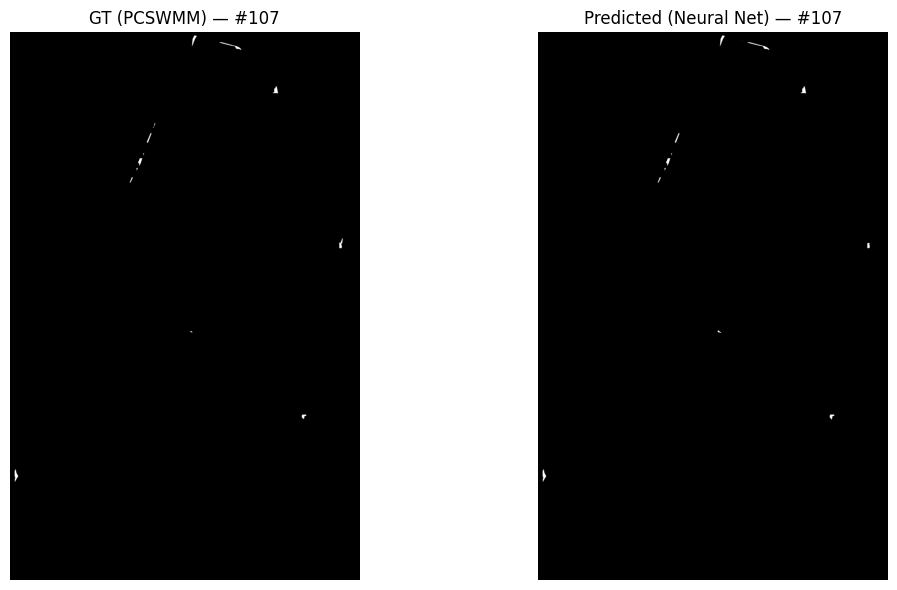

Processing Rainfall #108...


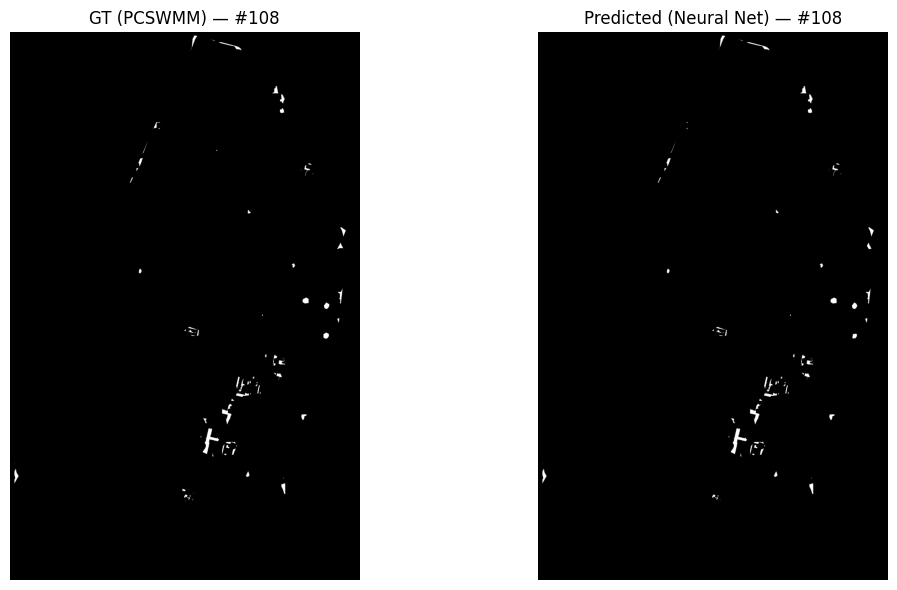

Processing Rainfall #109...


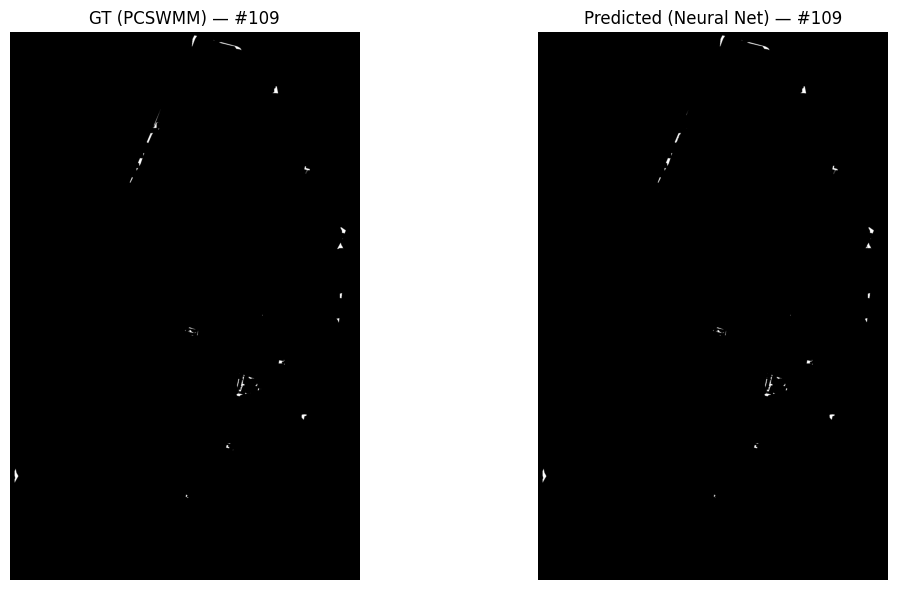

Processing Rainfall #110...


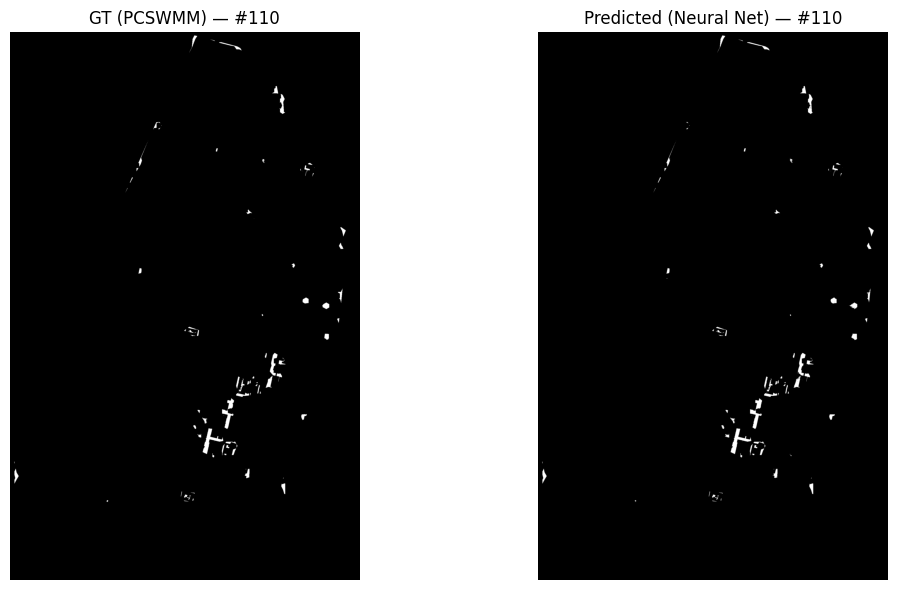

Processing Rainfall #111...


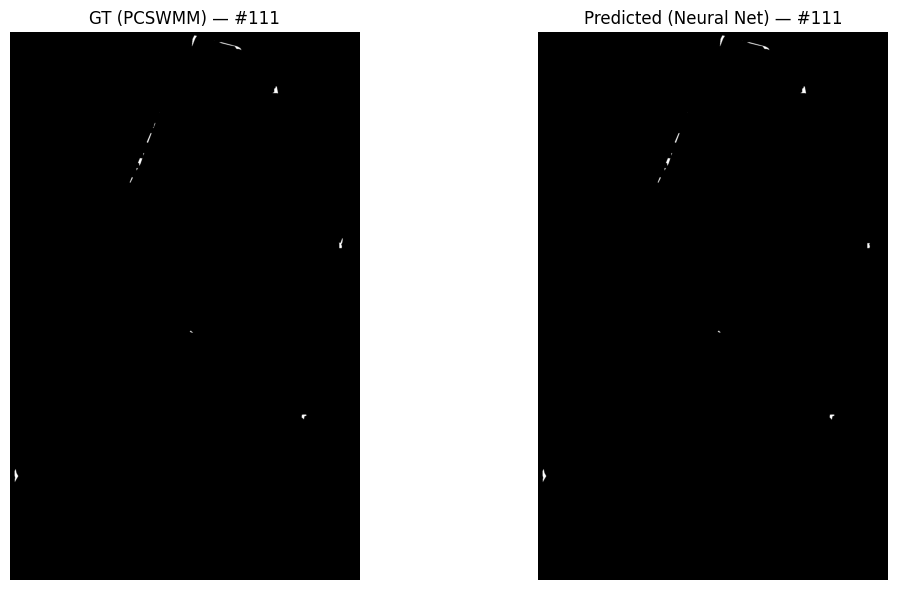

Processing Rainfall #112...


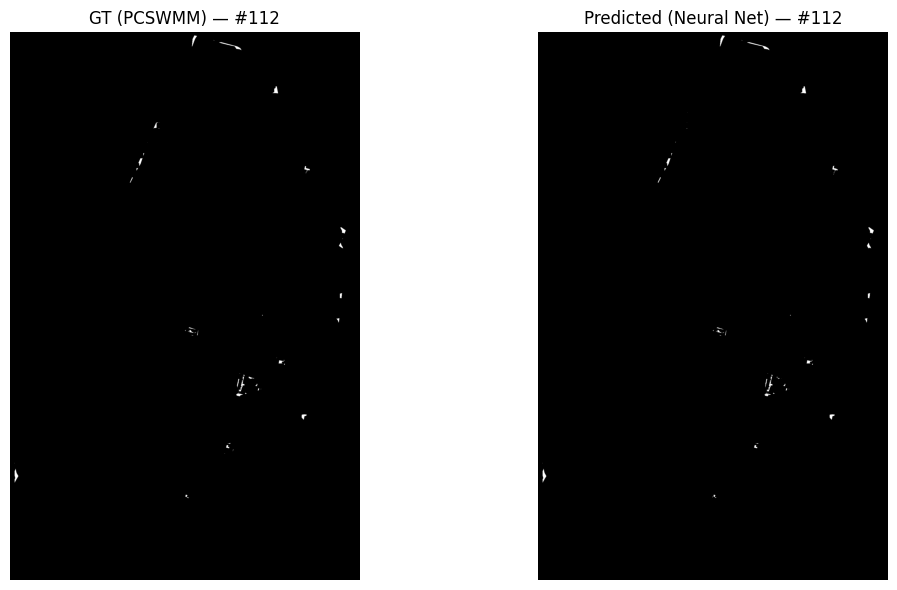

Processing Rainfall #113...


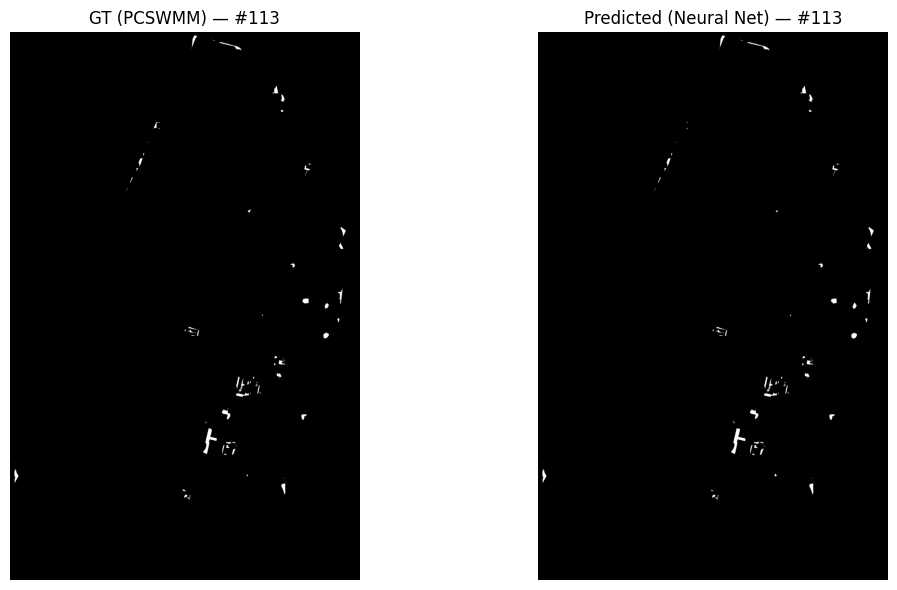

Processing Rainfall #114...


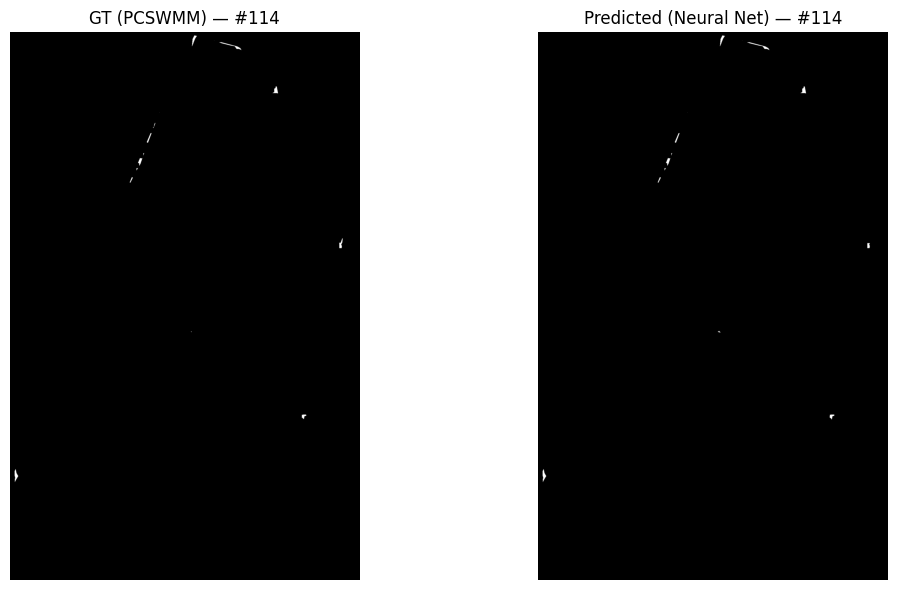

Processing Rainfall #115...


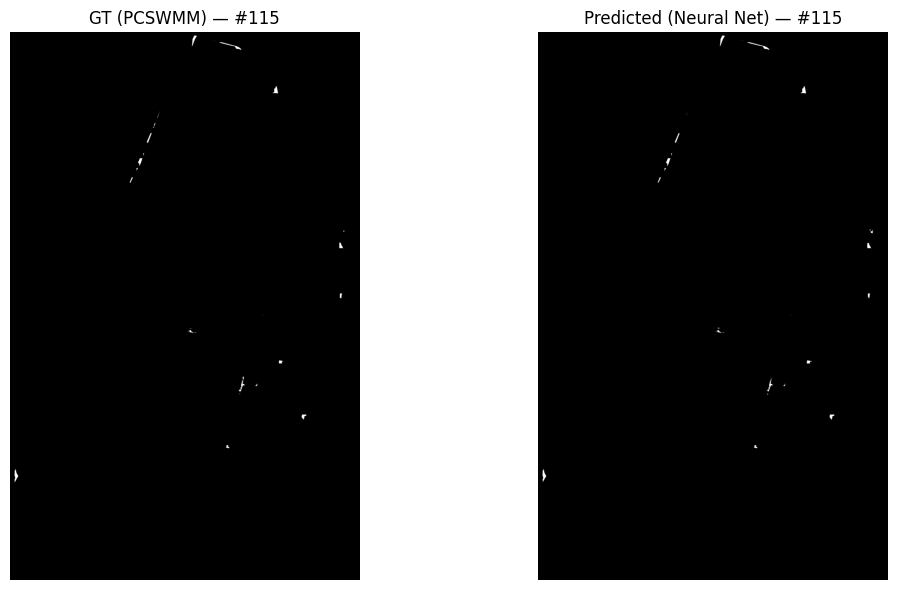

Processing Rainfall #116...


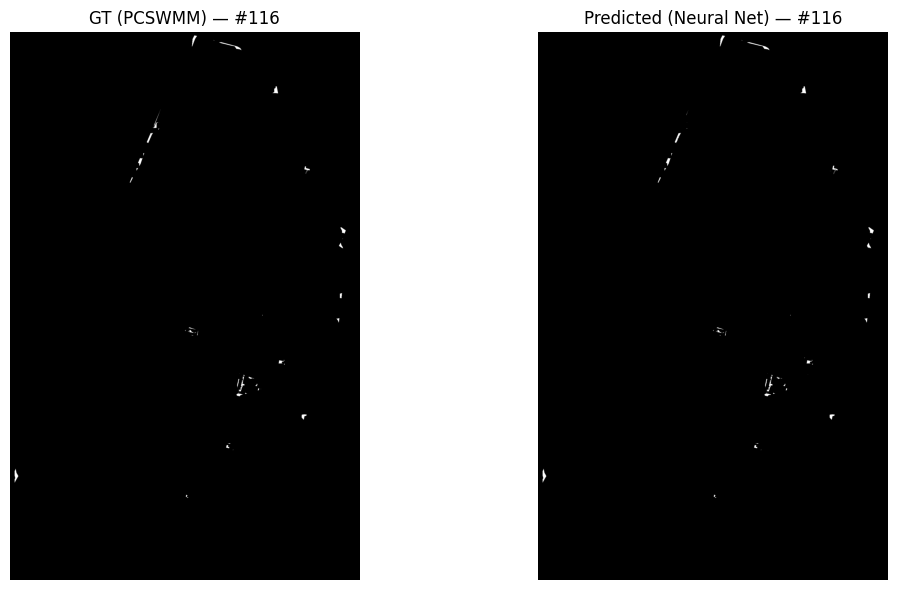

Processing Rainfall #117...


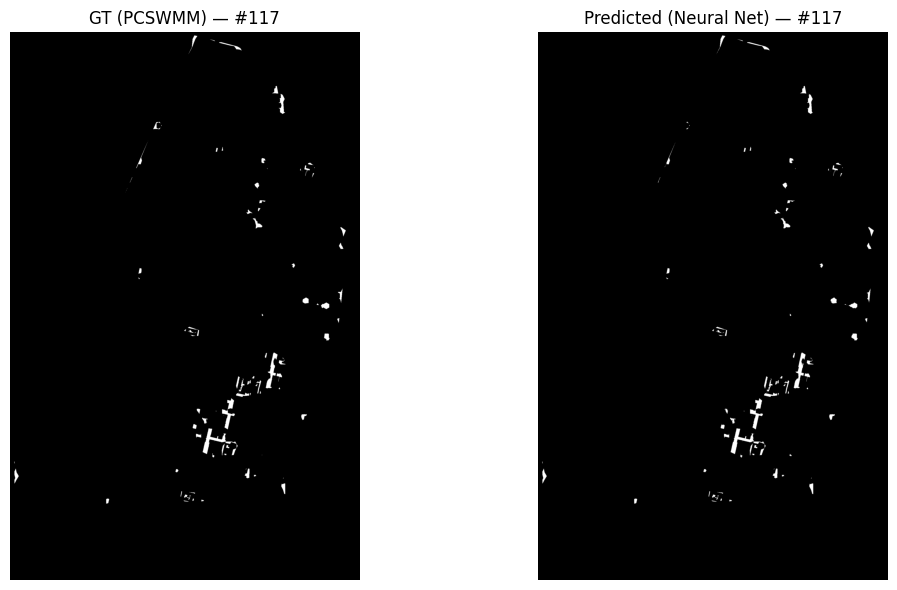

Processing Rainfall #118...


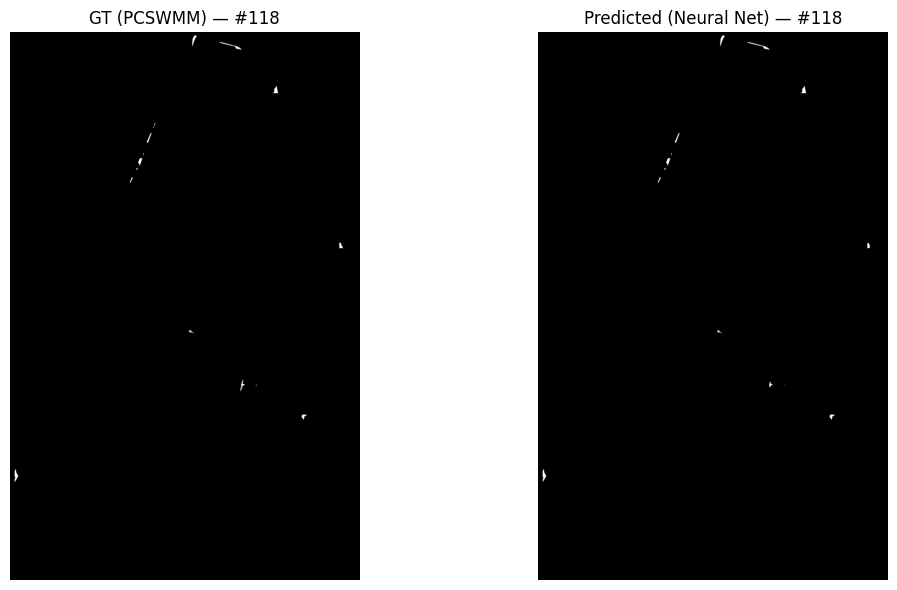

Processing Rainfall #119...


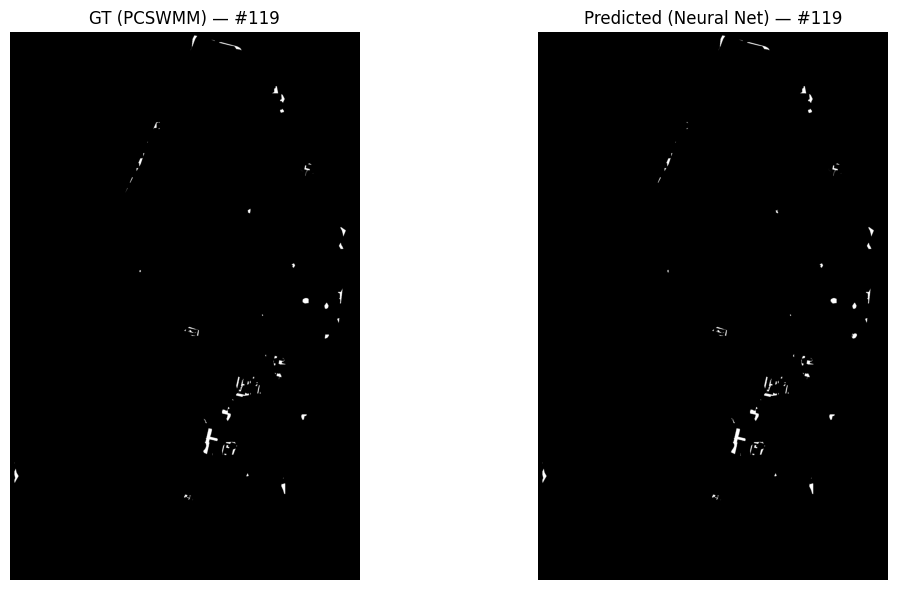

Processing Rainfall #120...


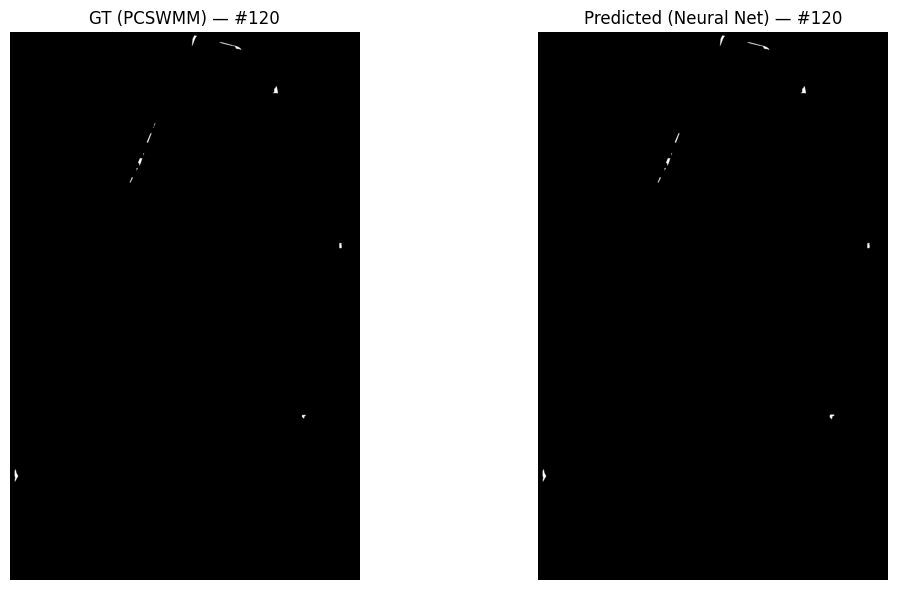

Processing Rainfall #121...


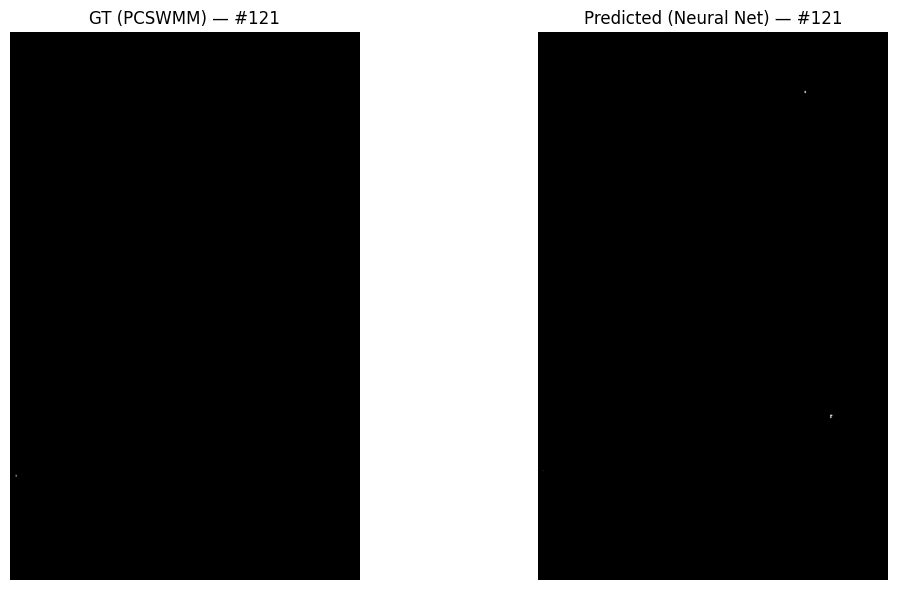

Processing Rainfall #122...


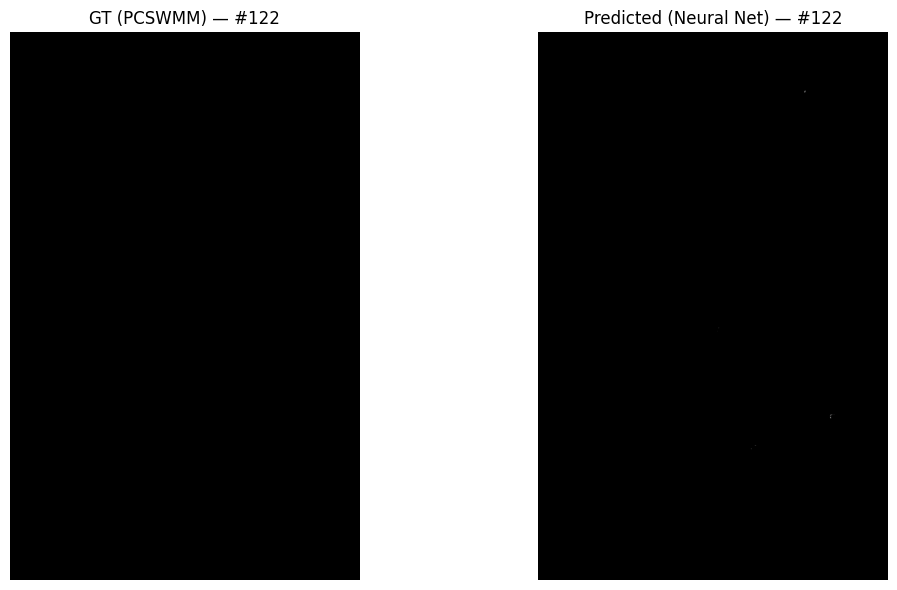

Processing Rainfall #123...


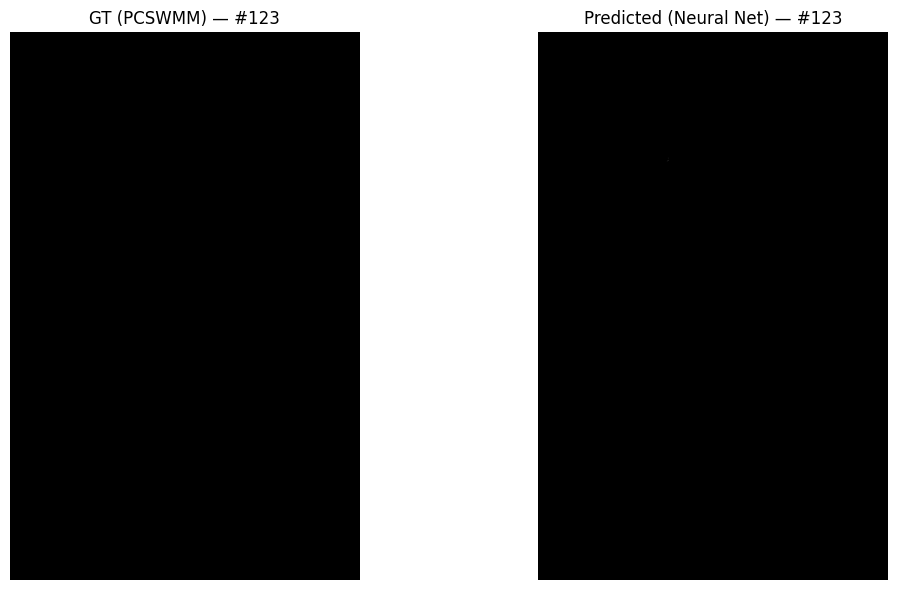

Processing Rainfall #124...


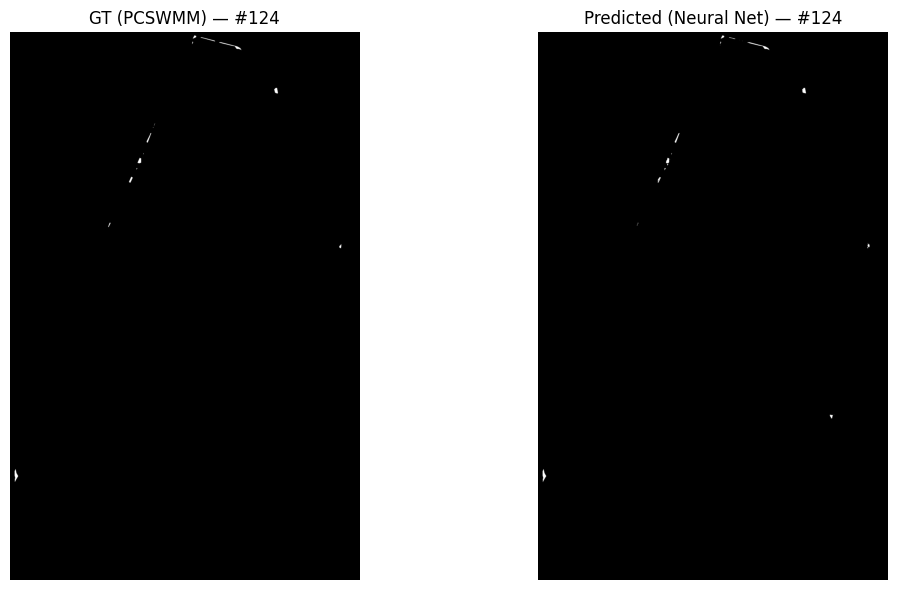

Processing Rainfall #125...


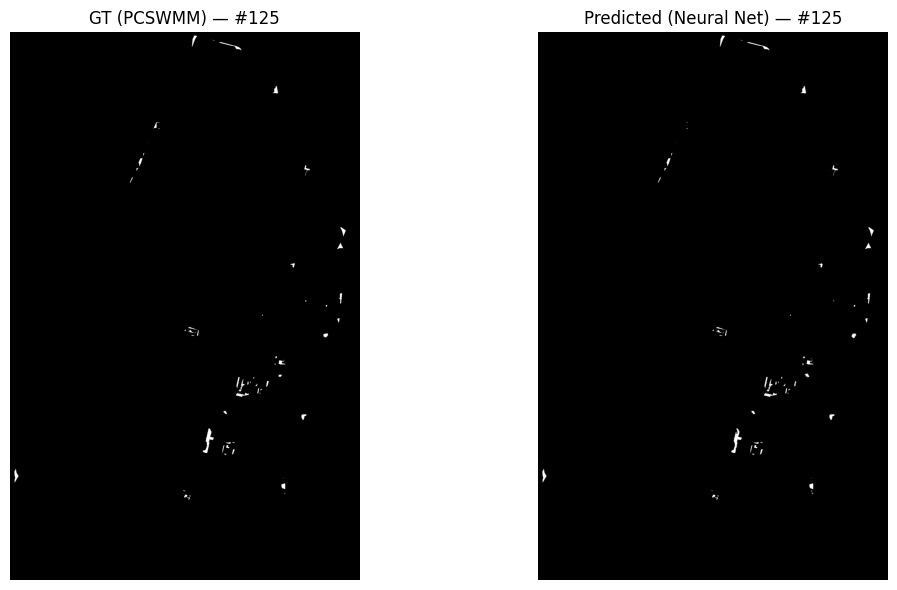

Processing Rainfall #126...


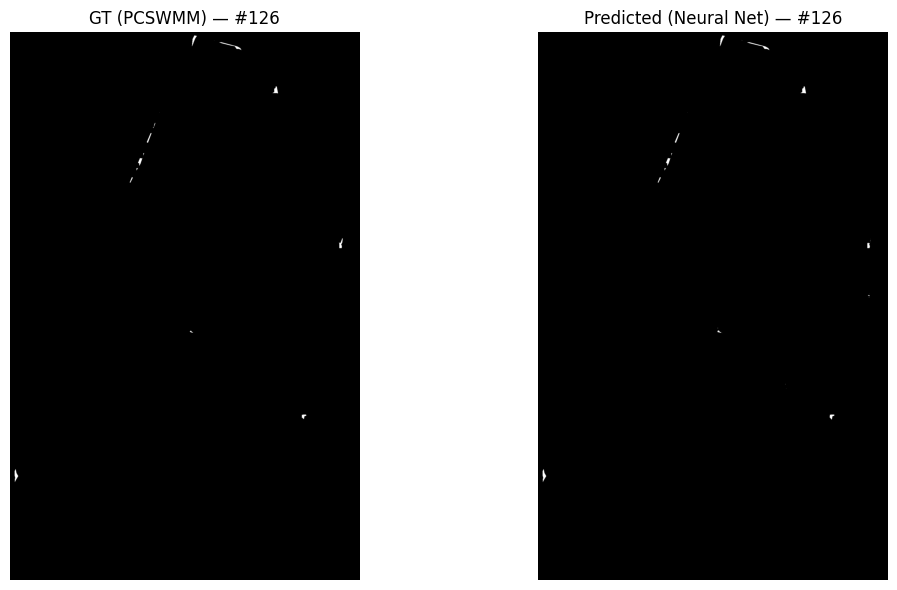

Processing Rainfall #127...


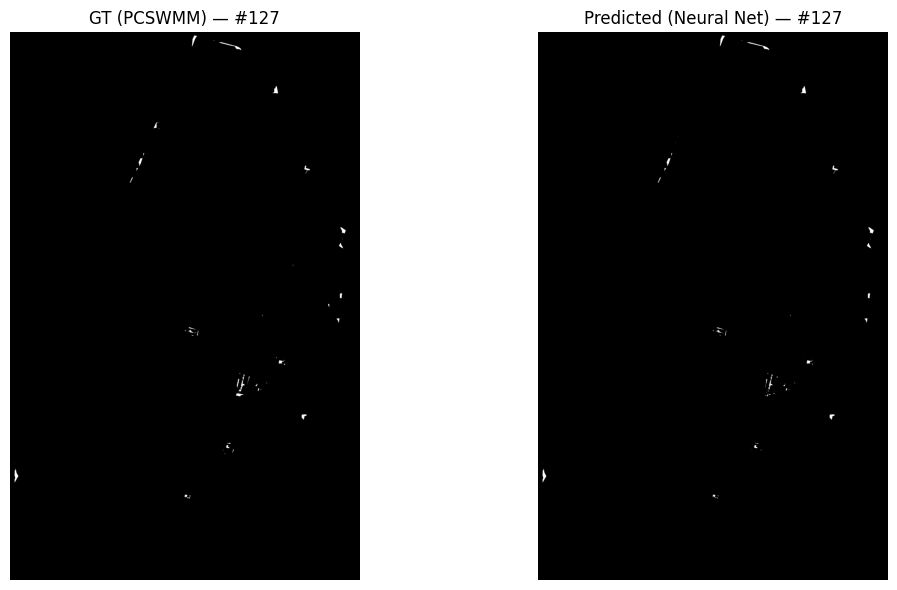

Processing Rainfall #128...


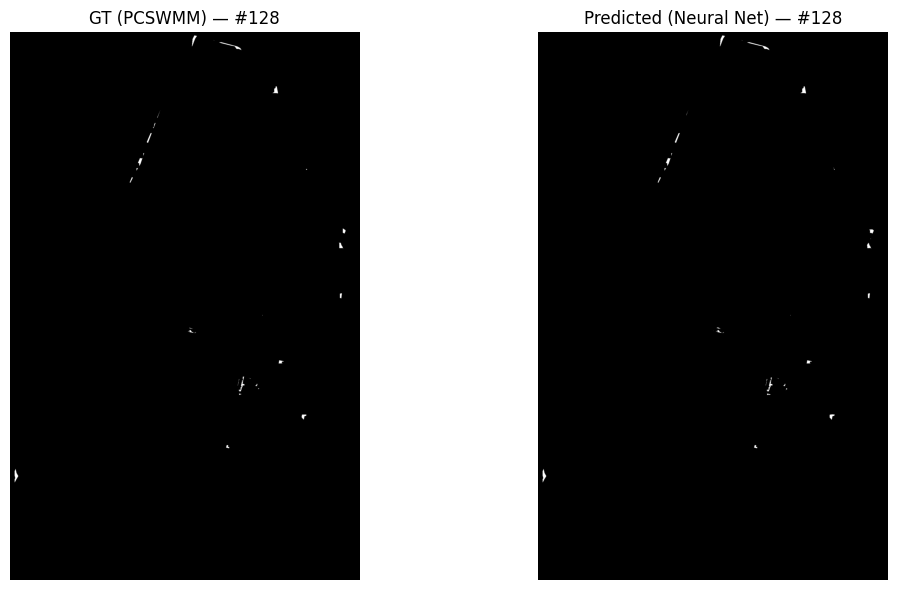

Processing Rainfall #129...


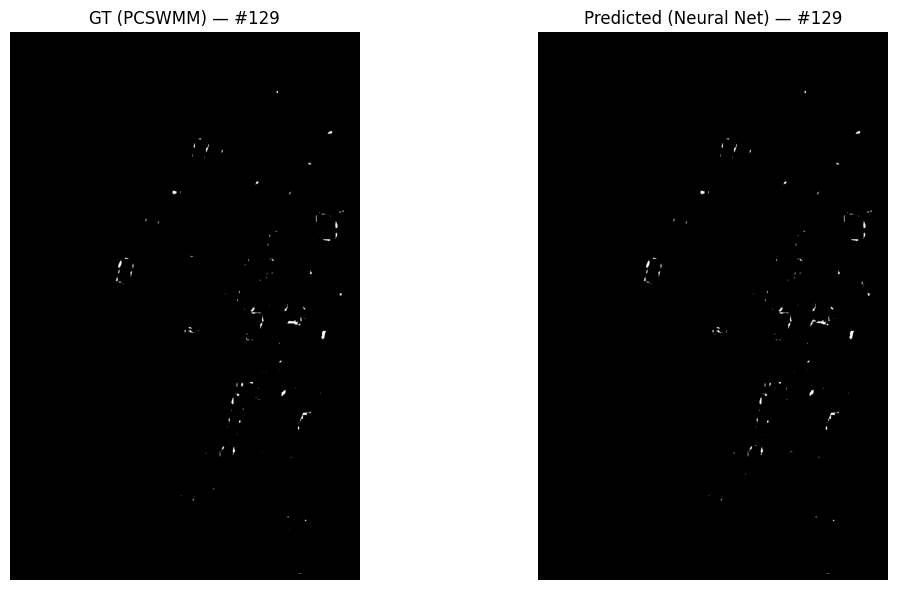

Processing Rainfall #130...


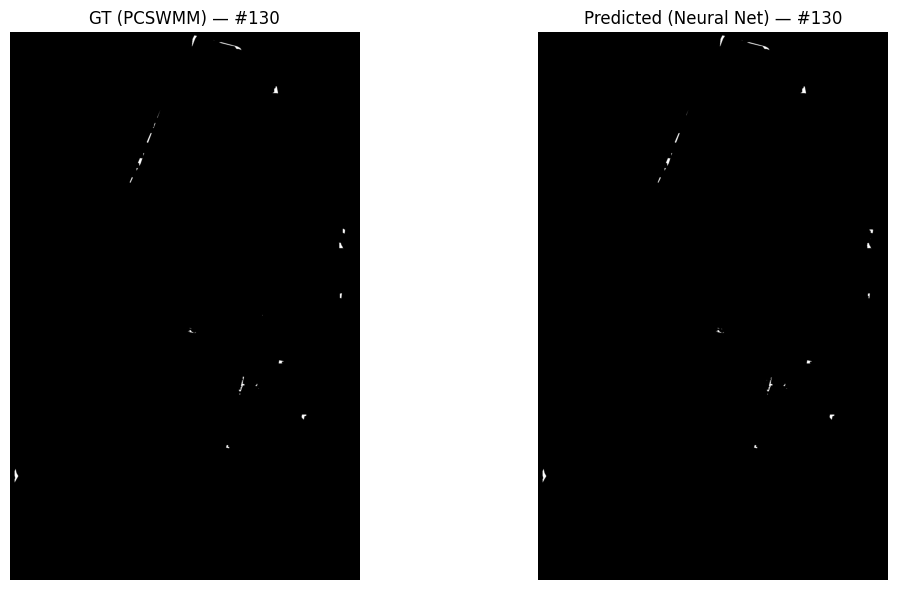

Processing Rainfall #131...


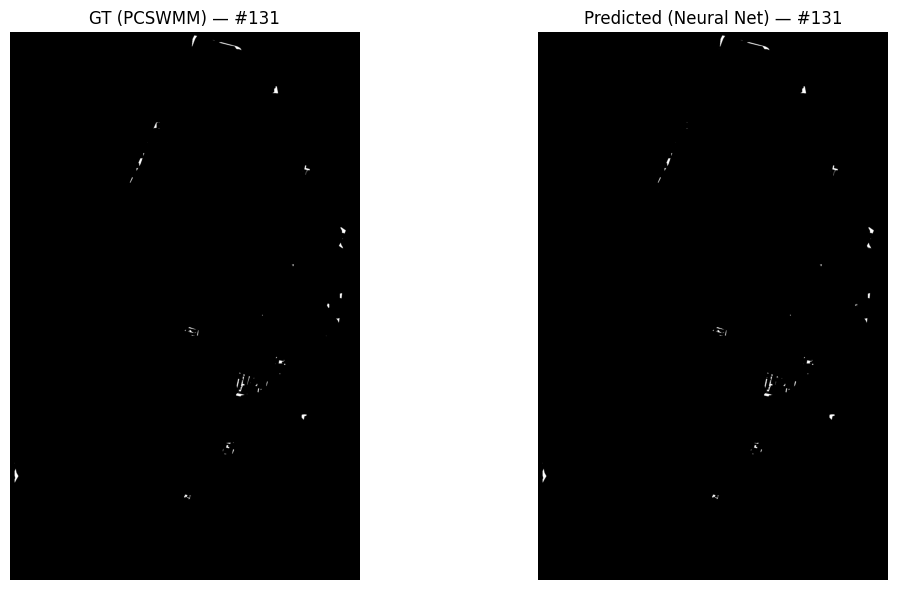

Processing Rainfall #132...


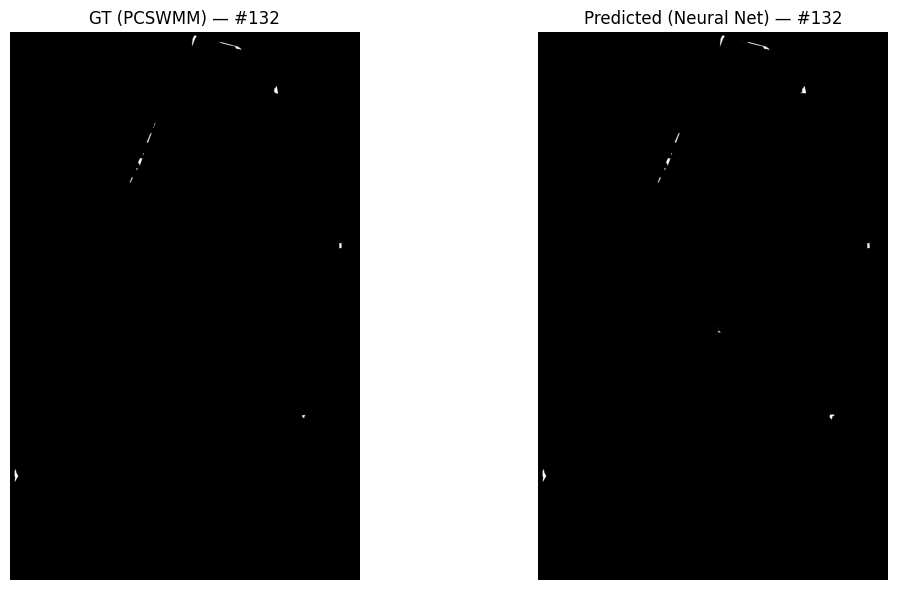

Processing Rainfall #133...


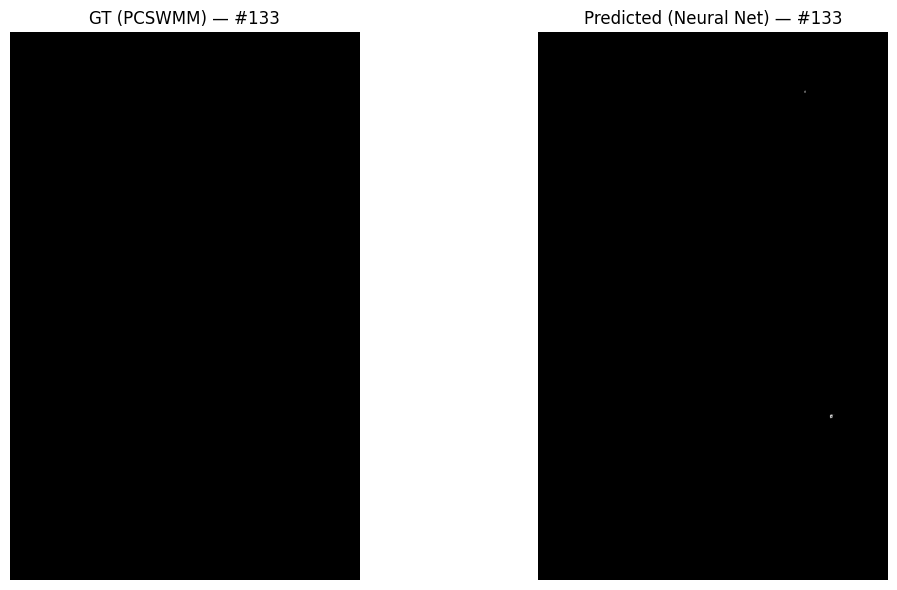

Processing Rainfall #134...


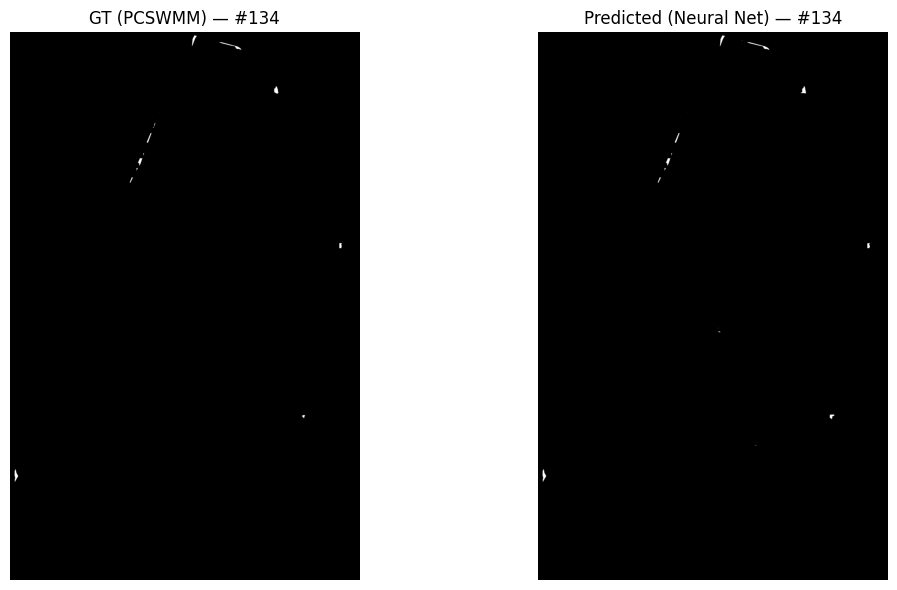

Processing Rainfall #135...


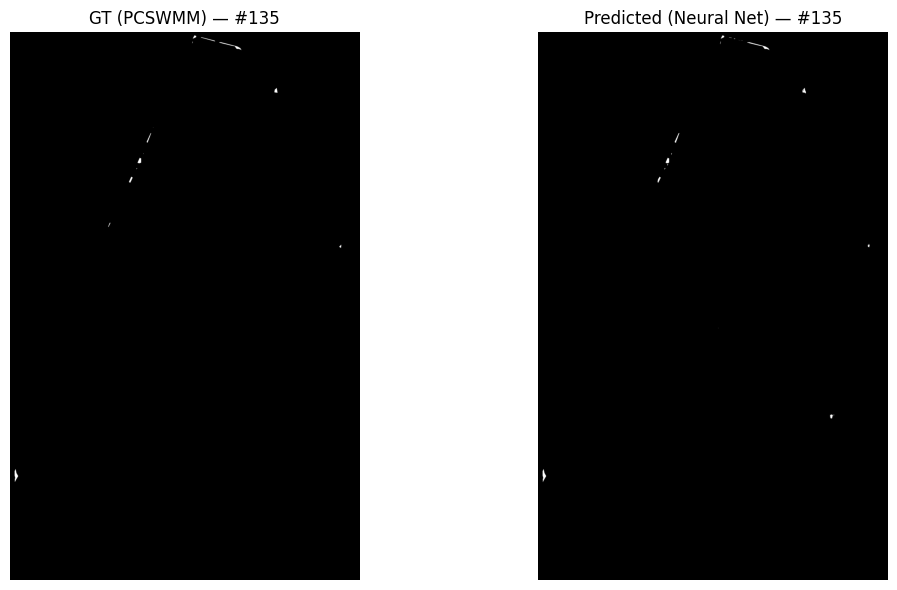

Processing Rainfall #136...


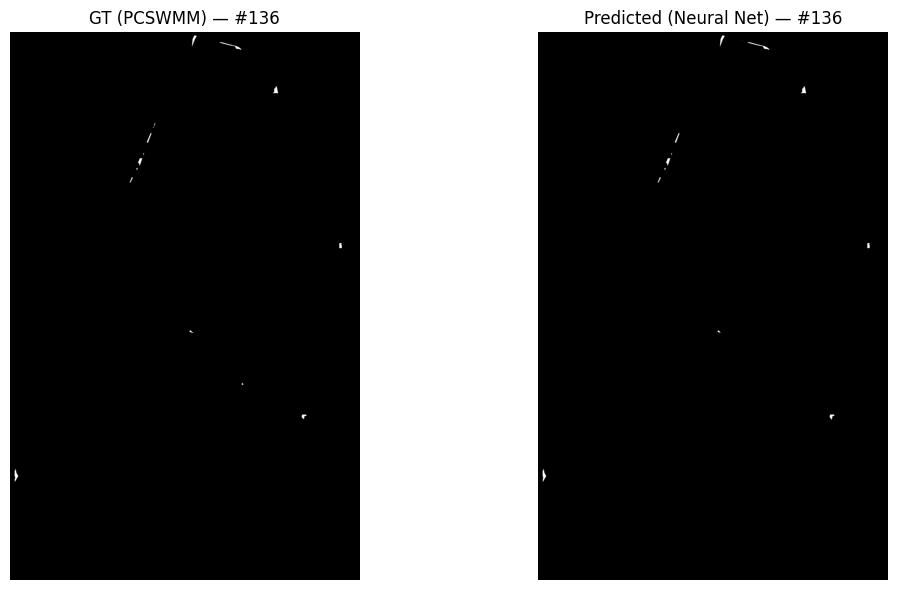

Processing Rainfall #137...


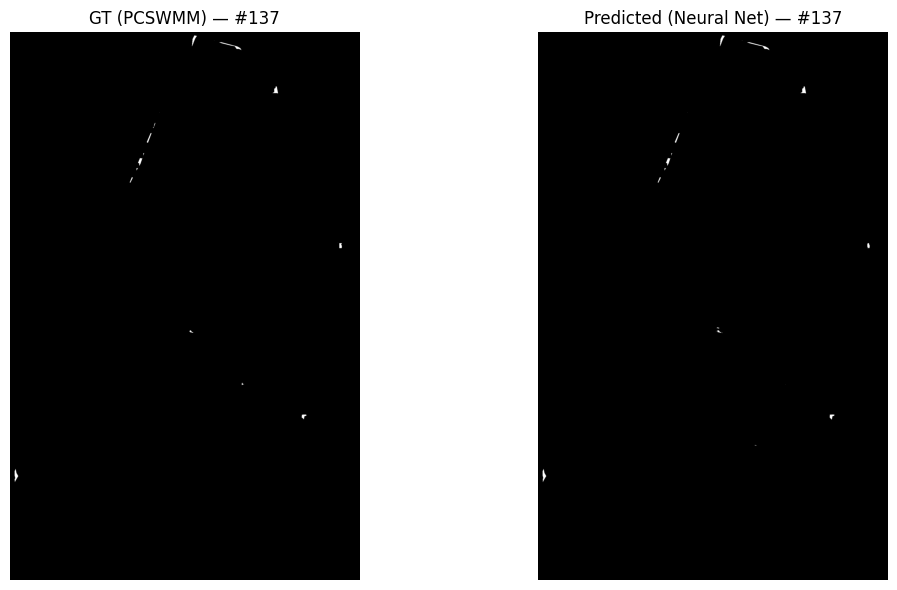

Processing Rainfall #138...


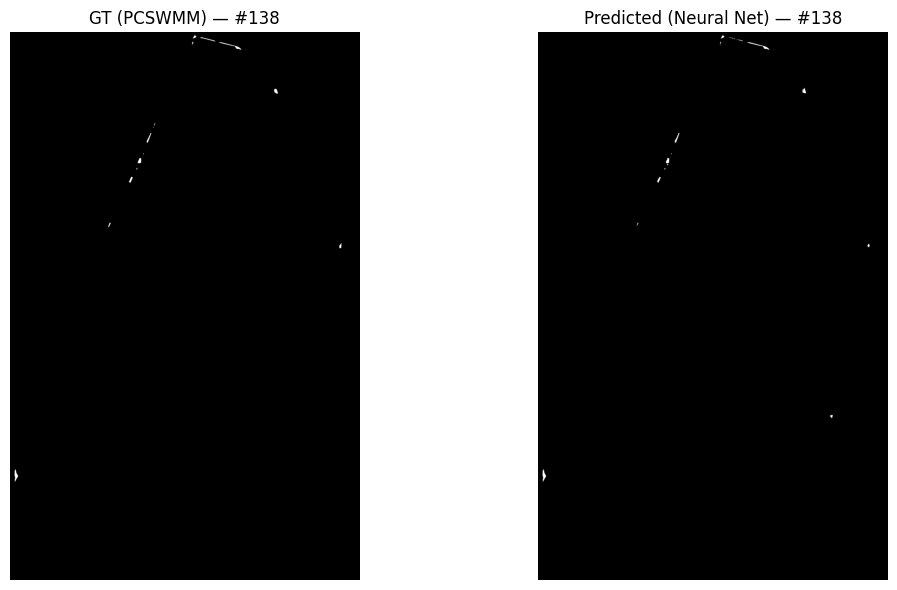

Processing Rainfall #139...


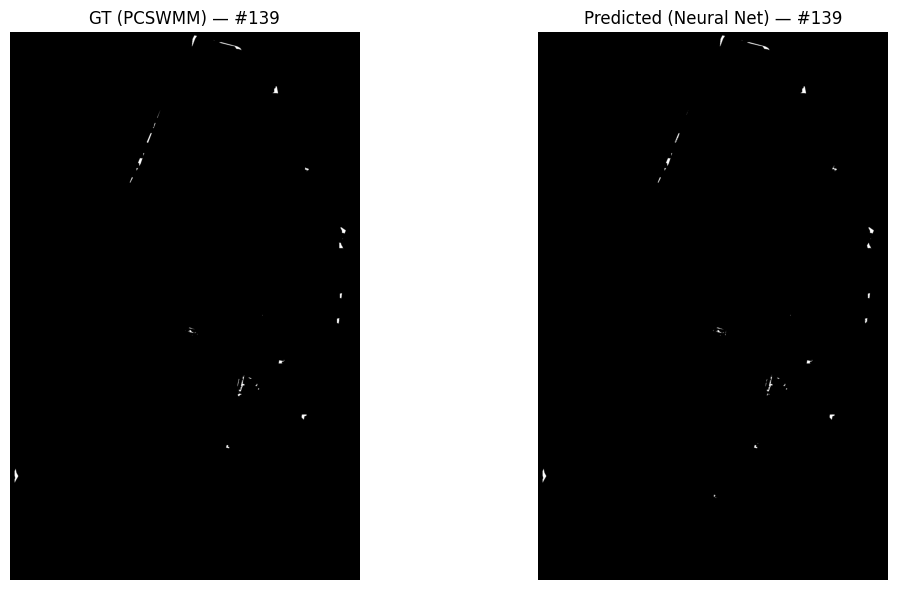

Processing Rainfall #140...


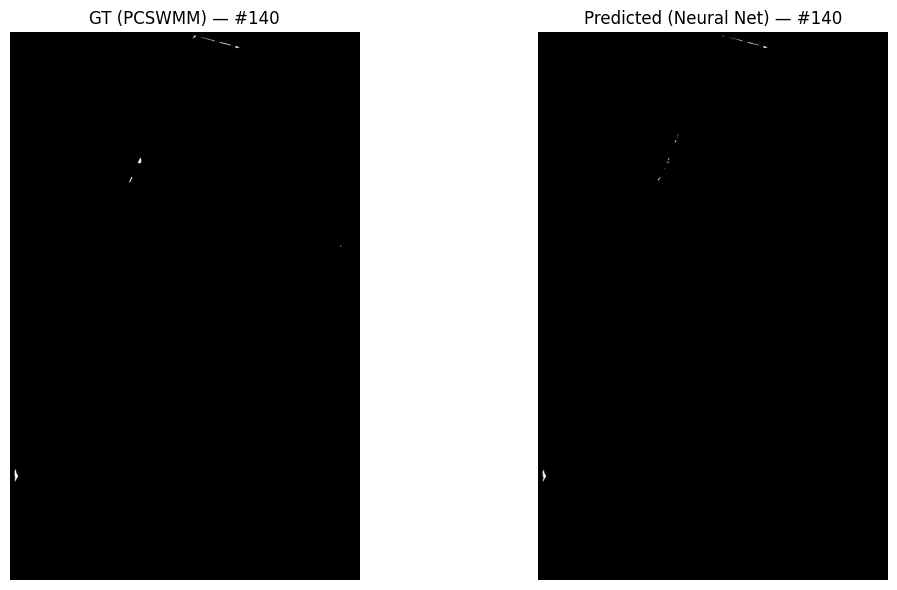

Processing Rainfall #141...


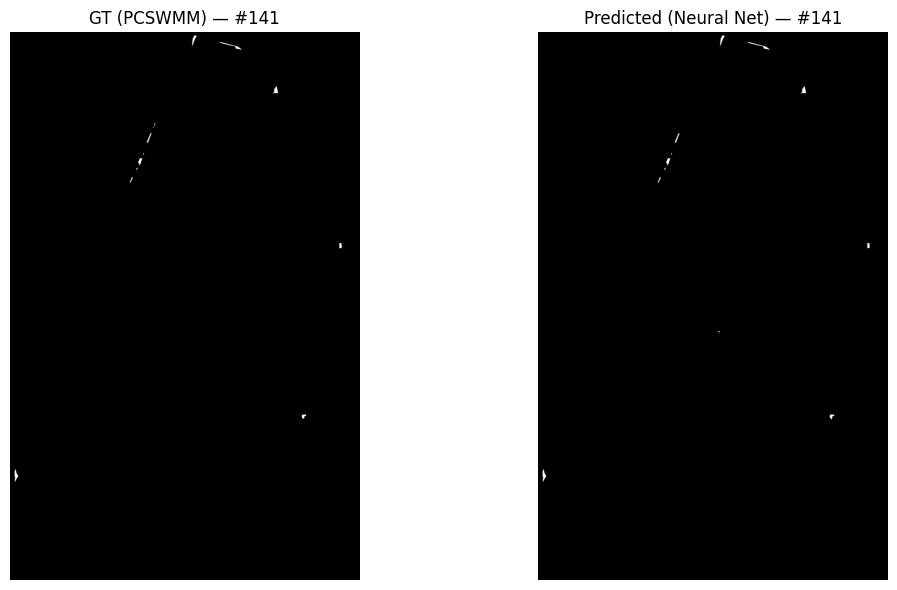

Processing Rainfall #142...


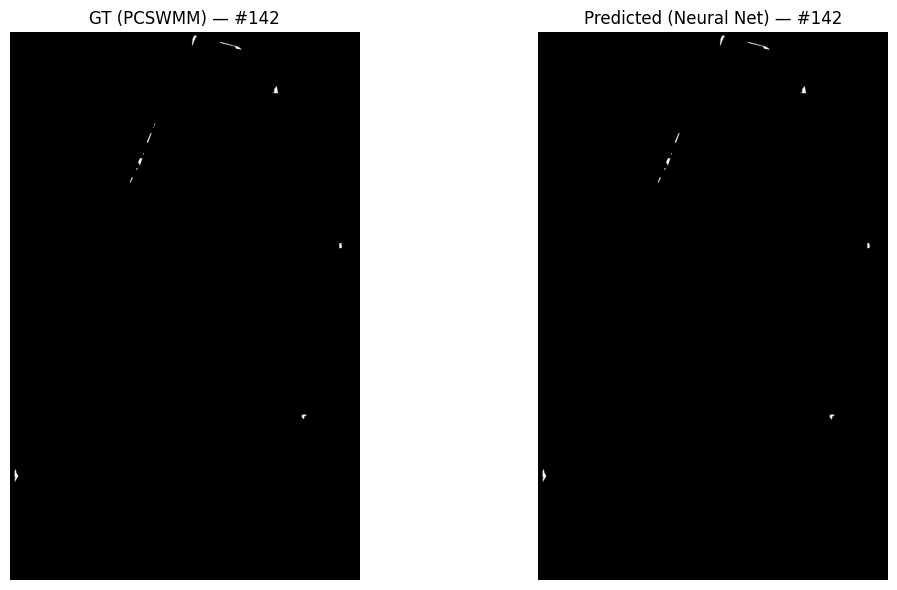

Processing Rainfall #143...


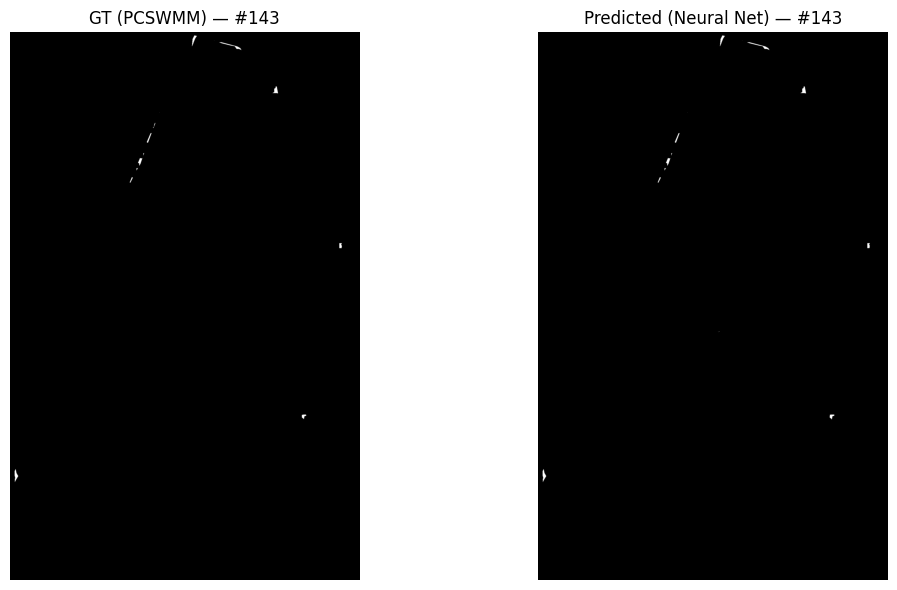

Processing Rainfall #144...


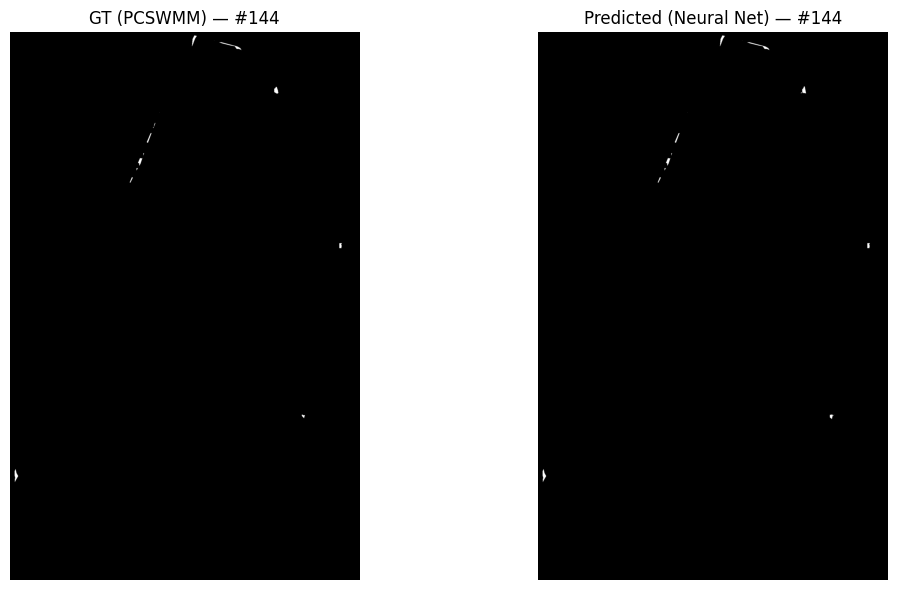

Processing Rainfall #145...


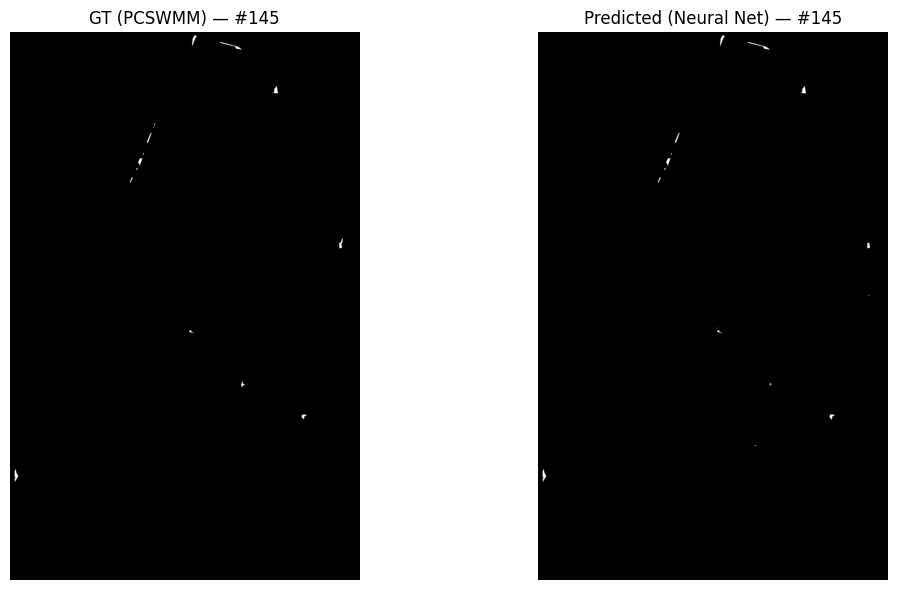

Processing Rainfall #146...


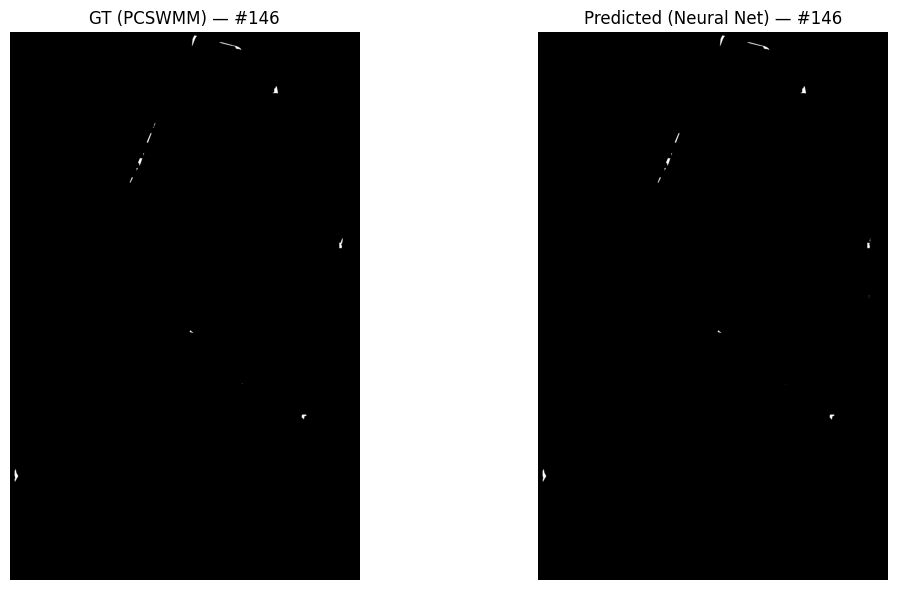

Processing Rainfall #147...


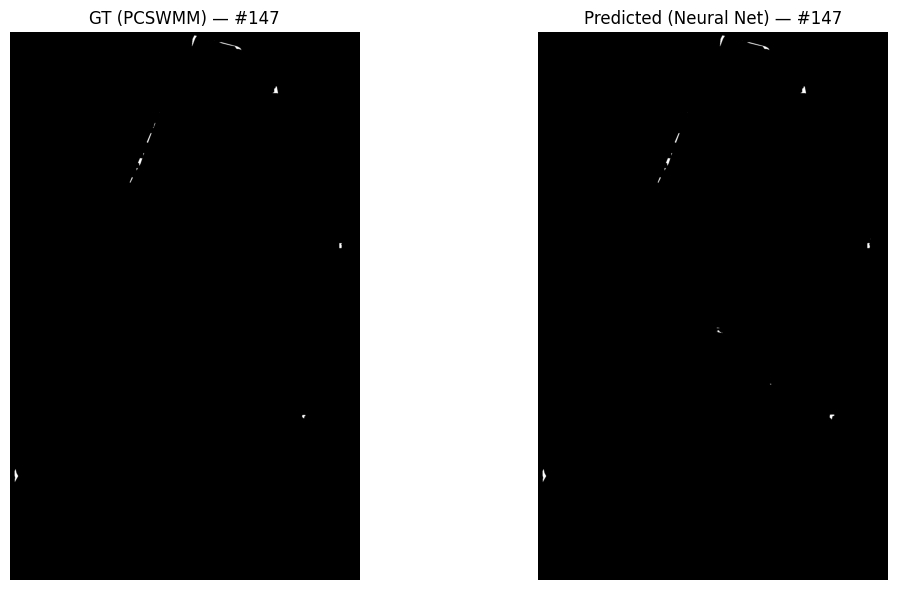

Processing Rainfall #148...


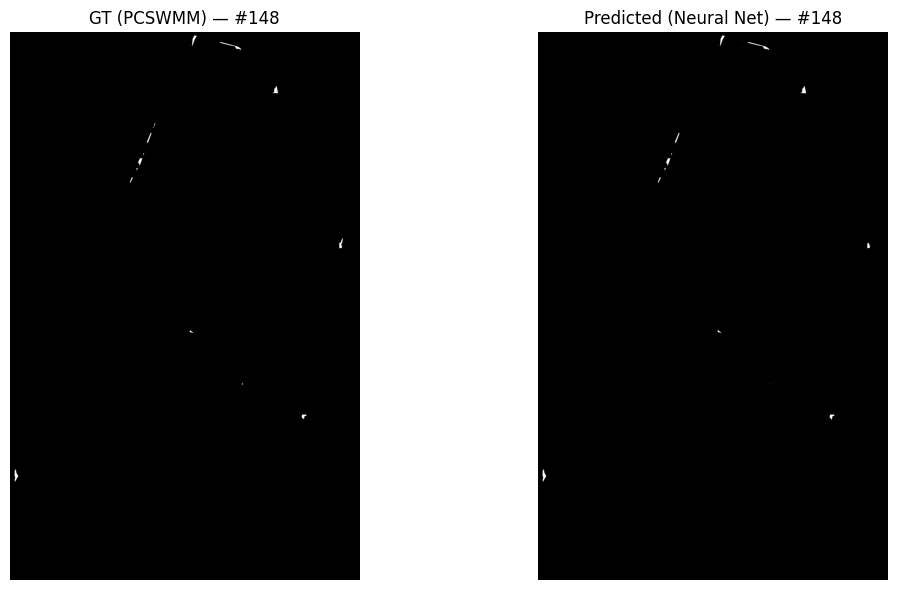

Processing Rainfall #149...


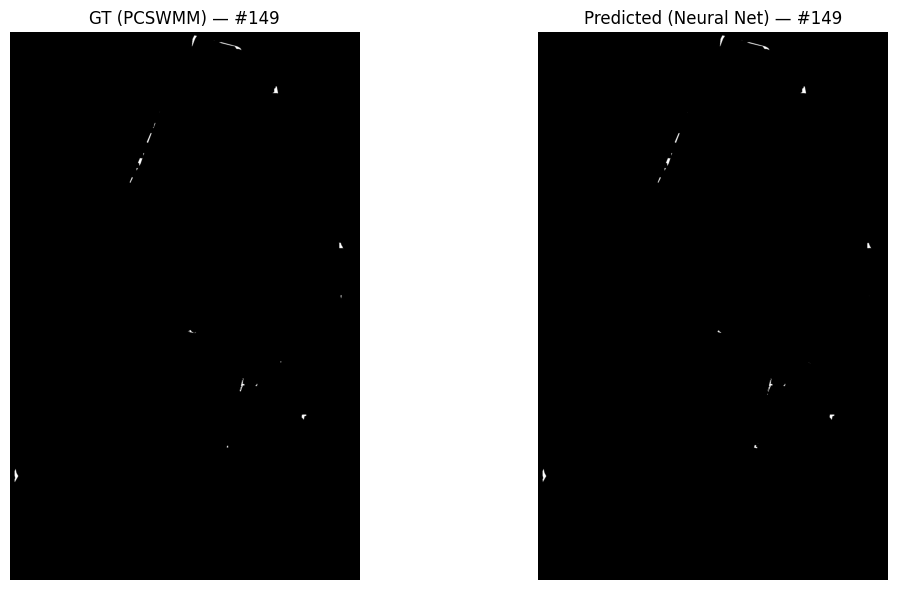

Processing Rainfall #150...


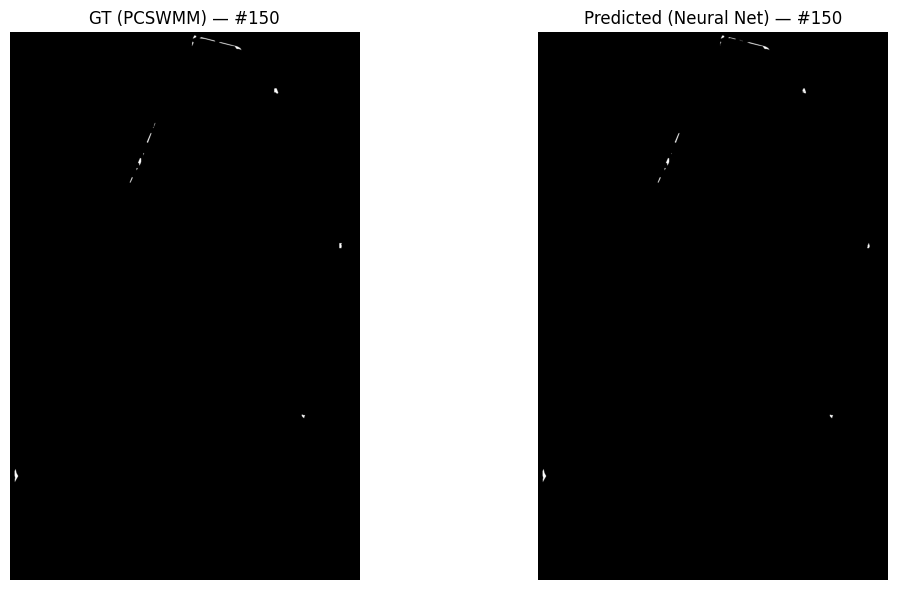

In [20]:
import os
import matplotlib.pyplot as plt

predicted_flood_maps = []
ground_truth_maps = []

for rainfall_id in range(151):
    print(f"Processing Rainfall #{rainfall_id}...")

    rainfall_vector = rainfall_vectors[rainfall_id]
    rainfall_input = np.repeat(rainfall_vector[np.newaxis, ...], len(patch_indices), axis=0)

    X_patch_batch = base_raster_patches

    Y_pred_patches = model.predict({"Raster_Input": X_patch_batch, "Rainfall_Input": rainfall_input}, verbose=0)
    Y_pred_binary = (Y_pred_patches > 0.5).astype(np.uint8)

    flood_pred_full = stitch_patches(Y_pred_binary, patch_indices)
    predicted_flood_maps.append(flood_pred_full)

    flt_path = rf'C:\Users\sistudent\Desktop\PCSWMM5\outputs\{rainfall_id}\{rainfall_id}DepthFLT\{rainfall_id}Depth.FLT'
    with rasterio.open(flt_path) as src:
        gt_depth = src.read(1)
        gt_binary = (gt_depth > 1.0).astype(np.uint8)
    ground_truth_maps.append(gt_binary)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(gt_binary, cmap='gray')
    plt.title(f"GT (PCSWMM) — #{rainfall_id}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(flood_pred_full, cmap='gray')
    plt.title(f"Predicted (Neural Net) — #{rainfall_id}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [22]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

for i in range(38):
    y_true = ground_truth_maps[i].flatten()
    y_pred = predicted_flood_maps[i].flatten()

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"Rainfall #{i:02d} — Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

Rainfall #00 — Accuracy: 0.9990, Precision: 0.9958, Recall: 0.9314, F1: 0.9626
Rainfall #01 — Accuracy: 0.9998, Precision: 0.9348, Recall: 0.9856, F1: 0.9595
Rainfall #02 — Accuracy: 0.9998, Precision: 0.9941, Recall: 0.9551, F1: 0.9742
Rainfall #03 — Accuracy: 0.9998, Precision: 0.9848, Recall: 0.9916, F1: 0.9882
Rainfall #04 — Accuracy: 0.9998, Precision: 0.9952, Recall: 0.9773, F1: 0.9861
Rainfall #05 — Accuracy: 0.9993, Precision: 0.9756, Recall: 0.9664, F1: 0.9710
Rainfall #06 — Accuracy: 0.9999, Precision: 0.9822, Recall: 0.9807, F1: 0.9814
Rainfall #07 — Accuracy: 0.9999, Precision: 0.9726, Recall: 0.9863, F1: 0.9794
Rainfall #08 — Accuracy: 0.9983, Precision: 0.9993, Recall: 0.8945, F1: 0.9440
Rainfall #09 — Accuracy: 0.9996, Precision: 0.8702, Recall: 0.8775, F1: 0.8738
Rainfall #10 — Accuracy: 0.9998, Precision: 0.9666, Recall: 0.9559, F1: 0.9613
Rainfall #11 — Accuracy: 0.9997, Precision: 0.9965, Recall: 0.9702, F1: 0.9832
Rainfall #12 — Accuracy: 0.9995, Precision: 0.9642, 

# TEST - REAL EVENTS

Processing Rainfall #200...


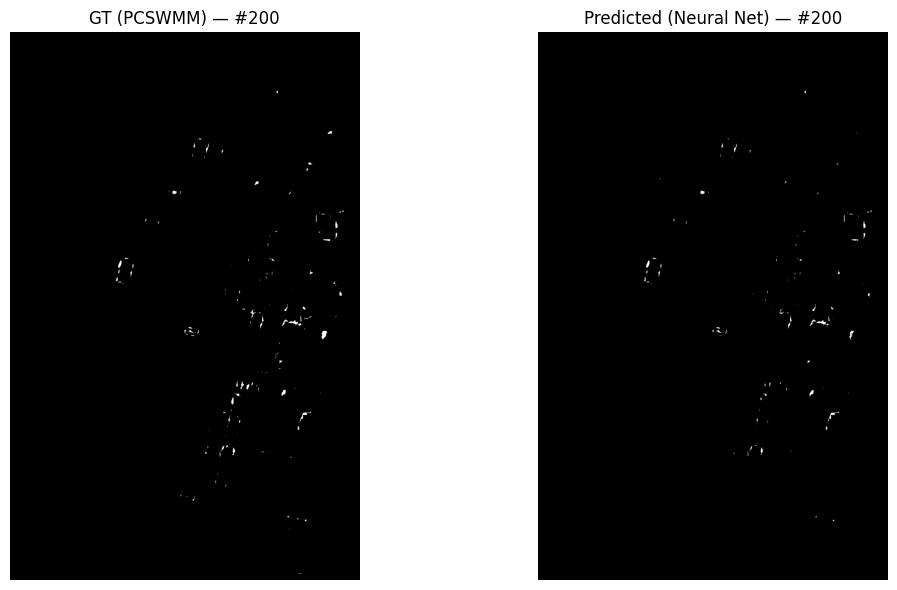

Processing Rainfall #201...


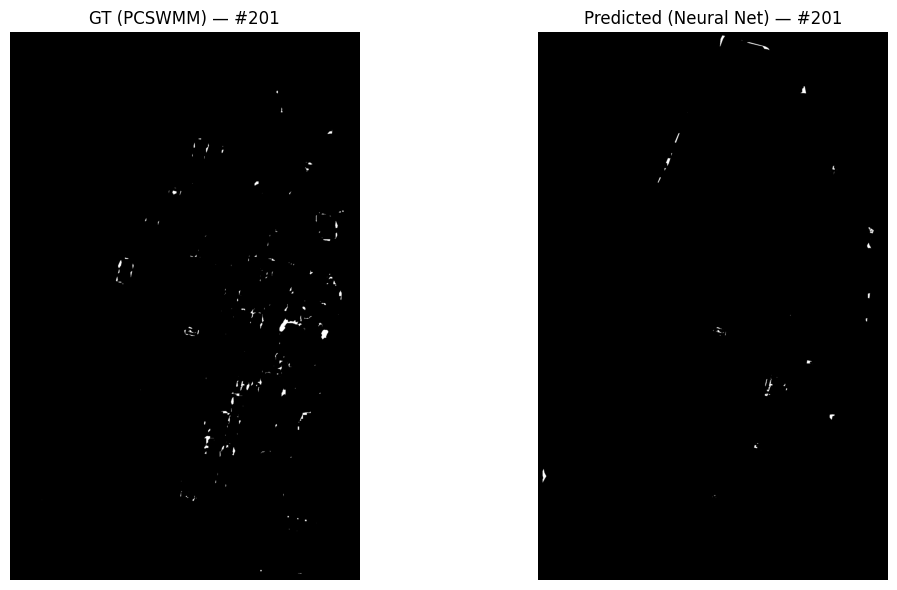

Processing Rainfall #202...


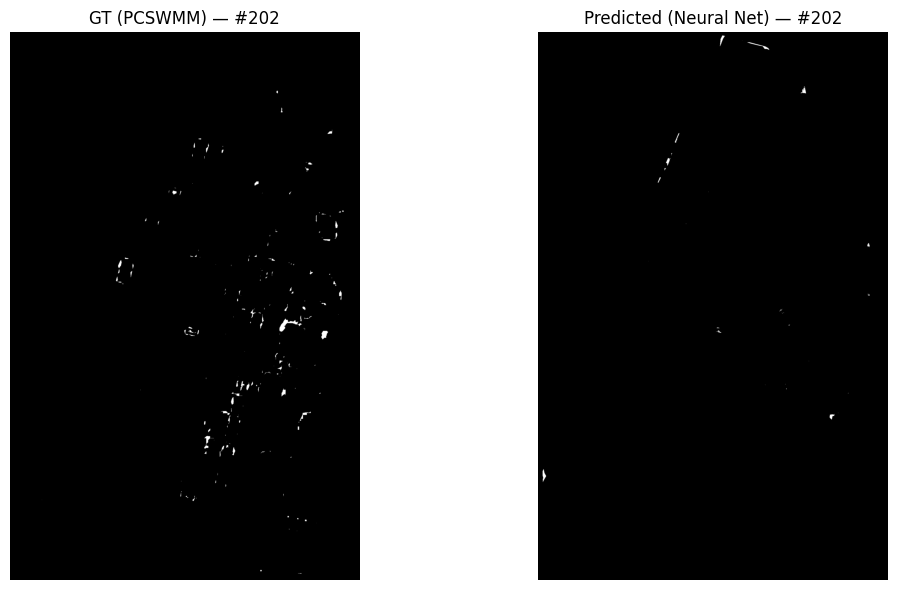

Processing Rainfall #203...


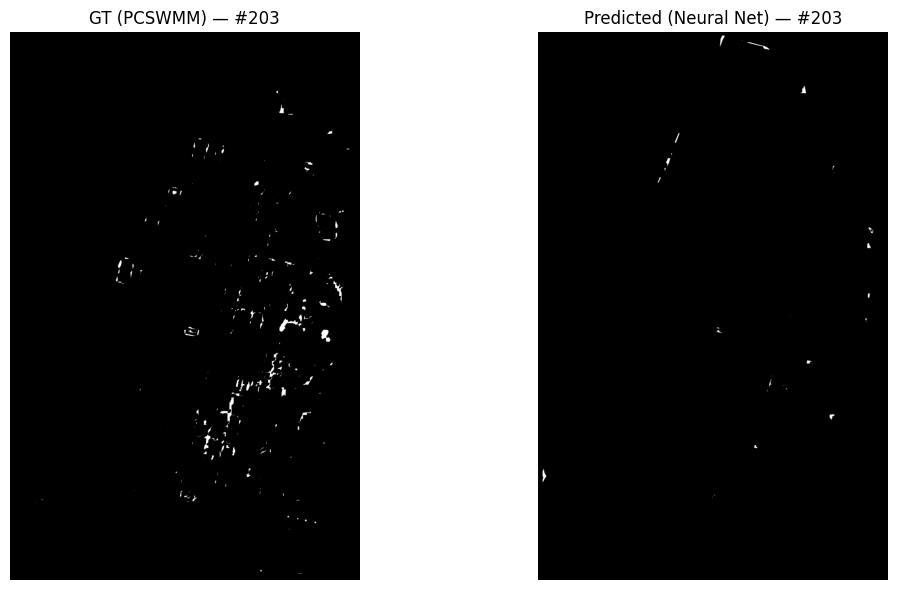

In [31]:
import os
import matplotlib.pyplot as plt

predicted_flood_maps = []
ground_truth_maps = []

for rainfall_id in [200, 201, 202, 203]:
    print(f"Processing Rainfall #{rainfall_id}...")

    rainfall_vector = rainfall_vectors[rainfall_id]
    rainfall_input = np.repeat(rainfall_vector[np.newaxis, ...], len(patch_indices), axis=0)

    X_patch_batch = base_raster_patches

    Y_pred_patches = model.predict({"Raster_Input": X_patch_batch, "Rainfall_Input": rainfall_input}, verbose=0)
    Y_pred_binary = (Y_pred_patches > 0.5).astype(np.uint8)

    flood_pred_full = stitch_patches(Y_pred_binary, patch_indices)
    predicted_flood_maps.append(flood_pred_full)

    flt_path = rf'C:\Users\sistudent\Desktop\PCSWMM5\outputs\{rainfall_id}\{rainfall_id}DepthFLT\{rainfall_id}Depth.FLT'
    with rasterio.open(flt_path) as src:
        gt_depth = src.read(1)
        gt_binary = (gt_depth > 1.0).astype(np.uint8)
    ground_truth_maps.append(gt_binary)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(gt_binary, cmap='gray')
    plt.title(f"GT (PCSWMM) — #{rainfall_id}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(flood_pred_full, cmap='gray')
    plt.title(f"Predicted (Neural Net) — #{rainfall_id}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()